In [57]:
import ray
from ray import tune
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import  seaborn as sns
import learning_lidar.utils.global_settings as gs
import matplotlib as mpl
sns.set_palette(sns.color_palette("tab10"))

plt.rcParams['figure.dpi'] = gs.FIGURE_DPI
plt.rcParams['savefig.dpi'] = gs.SAVEFIG_DPI

sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [58]:
def extract_powers(row, in_channels):
    powers = eval(row['powers']) if type(row['powers'])==str else None
    pow_y = np.array(powers[1])[0] if type(powers)==tuple else None
    pow_x = np.array(powers[0]) if type(powers)==tuple else None
    pow_xi = np.zeros(in_channels)
    if type(pow_x)==np.ndarray:
        for chan in range(in_channels):
            pow_xi[chan] = pow_x[chan] if  (len(pow_x)>=chan+1) else None
    else:
        for chan in range(in_channels):
            pow_xi[chan] = None
    return [pow_y,*pow_xi]

In [59]:
base_folder = os.path.dirname(os.path.dirname(os.path.abspath(os.curdir)))
results_folder = os.path.join(base_folder, 'results')

# postprocessing LCNET results from jason state files saved in  `runs_board.xlsx`

In [60]:
runs_df = pd.read_excel(os.path.join(results_folder,'runs_board.xlsx'))
runs_df = runs_df[runs_df.include==True][runs_df.state!='PENDING']

<ipython-input-60-1884f03031e8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  runs_df = runs_df[runs_df.include==True][runs_df.state!='PENDING']


In [61]:
for idx,row in runs_df.iterrows():
    #row = runs_df.iloc[idx]
    try:
        state_fname = sorted(glob.glob(os.path.join( row.experiment_folder,r'experiment_state*.json')))[-1]
        analysis = tune.ExperimentAnalysis(state_fname)
        ignore_MARELoss = "MARELoss" in [row.field_to_ignore]
        analysis.default_metric = "MARELoss" if ignore_MARELoss else "MARELoss"
        analysis.default_mode="min"
        results_df = analysis.dataframe(metric="MARELoss", mode="min",)

        # update fields:
        if ignore_MARELoss:
            results_df["MARELoss"]=None

        # rename column names:
        cols = results_df.columns.values.tolist()
        new_cols = [col.replace('config/',"") for col in cols]
        dict_cols ={}
        for col,new_col in zip(cols, new_cols):
            dict_cols.update({col:new_col})
        results_df = results_df.rename(columns= dict_cols)

        # update power values:
        len_pow = len(results_df[results_df.use_power==True])
        len_no_pow = len(results_df[results_df.use_power==False])
        len_pows = len(results_df[results_df.use_power !=False])
        if len_no_pow>0:
            results_df.loc[results_df[results_df.use_power==False].index,'powers']= ''
        if len_pows!=len_pow:
            results_df.loc[results_df[results_df.use_power!=False].index,'powers']=results_df.use_power
            results_df.loc[results_df[results_df.use_power!=False].index,'use_power']=True
        else:
            results_df.loc[results_df[results_df.use_power==True].index,'powers']= '([0.5,0.5],[0.5])'

        # Update Notes
        note = row['note']
        results_df['note']= note if type(note)==str else 'ok'

        # drop irrelevant columns:
        drop_cols = [ 'time_this_iter_s', 'should_checkpoint', 'done',
                   'timesteps_total', 'episodes_total',
                   'experiment_id',  'timestamp',  'pid', 'hostname',
                   'node_ip', 'time_since_restore', 'timesteps_since_restore',
                   'iterations_since_restore']
        results_df.drop(columns=drop_cols,inplace=True)


        # reorganize columns:
        new_order = ['trial_id', 'date','time_total_s','training_iteration',
                     'loss', 'MARELoss',
                     'bsize', 'dfilter', 'dnorm','fc_size', 'hsizes', 'lr',
                     'ltype', 'source', 'use_bg', 'use_power','powers','note','logdir']
        results_df = results_df.reindex(columns=new_order)

        # keep index trial (especially for cases when trails are ignored)
        #results_df['idx']=results_df.index
        #new_cols = ['idx']
        #new_cols.extend(cols)
        #results_df = results_df.reindex(columns=new_cols)

        # remove irrelevant trials (e.g. when dnorm had wrong calculation)
        if row.trial_to_ignore is not np.nan:
            key,cond = eval(row.trial_to_ignore)
            results_df.drop(index=results_df[results_df[key]==cond].index,inplace=True)

        # save csv
        results_csv = os.path.join(analysis._experiment_dir, f'experiment_results.csv')
        results_df.to_csv(results_csv, index=False)

        # update csv path in main runs_board
        runs_df.loc[idx,'results_csv']=results_csv
        print(results_csv,idx)

    except:
        continue
# TODO: save runs_df with results_csv paths

# %%

#runs_df


# %% concatante all csv files with include =1

paths = [row['results_csv'] for idx,row in runs_df.iterrows()]
results_dfs=[pd.read_csv(path) for path in paths]
total_results = pd.concat(results_dfs,ignore_index=True)
# %%
total_results['fc_size'] = total_results.fc_size.apply(lambda x: eval(str(x))[0])
# update powers
in_channels = 3
res= total_results.apply(extract_powers,args=(in_channels,), axis=1, result_type='expand')
cols_powx = [f"pow_x{ind+1}" for ind in range(in_channels)]
res.rename( columns={0:'pow_y',1:cols_powx[0],2:cols_powx[1],3:cols_powx[2]},inplace=True)
total_results[res.columns.values] = res
total_results['powers'] = total_results.powers.apply(lambda x: eval(x) if type(x)==str else None)

# %%

hsizes=total_results.hsizes.apply(lambda x: eval(x))
total_results['u_hsize']=hsizes.apply(lambda x: all([(hi==x[0]) for hi in x])) # The test of changing the with at the last level , didn't show improvements

No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.

C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-20_07-01-41\experiment_results.csv 14
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-20_13-05-53\experiment_results.csv 15
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-21_01-40-10\experiment_results.csv 16
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-21_12-12-43\experiment_results.csv 17
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-22_20-09-17\experiment_results.csv 18
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-22_23-36-51\experiment_results.csv 19
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-23_19-35-00\experiment_results.csv 20
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-23_23-40-05\experiment_results.csv 21
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-24_08-38-28\experiment_results.csv 22
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\m

In [62]:
wavelengths=[]
filtered = total_results.dfilter.apply(lambda x:type(x)==str)
inds = total_results.dfilter[filtered].index
for ind,f in enumerate(filtered):
    if f:
        [filter_by,filter_values] = eval(total_results.dfilter.iloc[ind])
        if filter_by=='wavelength':
            wavelength = tuple(filter_values) if len(filter_values)>1 else filter_values[0]
        else:
            wavelength = 'all'
    else:
        wavelength='all'
    wavelengths.append(wavelength)

total_results['wavelength'] = wavelengths


In [63]:
analyse_results = total_results[total_results.training_iteration>=1]
#analyse_results = analyse_results[analyse_results.note=='ok']
analyse_results = analyse_results[analyse_results.u_hsize]

# %%
configs= []
use_bg = []
for idx,row in analyse_results.iterrows():
    hsize = eval(row.hsizes)[0]
    fcsize = row.fc_size
    if (hsize==4) and (fcsize==16):
        configs.append('A')
    elif (hsize==4) and (fcsize==32):
        configs.append('B')
    elif (hsize==5) and (fcsize==16):
        configs.append('C')
    elif (hsize==5) and (fcsize==32):
        configs.append('D')
    elif (hsize==6) and (fcsize==16):
        configs.append('E')
    elif (hsize==6) and (fcsize==32):
        configs.append('F')
    else:
        configs.append('Other')

    flag_bg = row.use_bg
    if type(flag_bg)==str:
        if flag_bg=='False' or flag_bg=='True':
            use_bg.append(eval(flag_bg))
        else :
            use_bg.append(flag_bg)
    else:
        use_bg.append(flag_bg)

analyse_results['config'] = configs
analyse_results['use_bg'] = use_bg

## 1. Choosing Learning rate
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar

<ipython-input-64-0f009be118df>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(pow_lidar[pow_lidar.bsize==32][pow_lidar.fc_size>4],#[pow_lidar.note=='ok'],


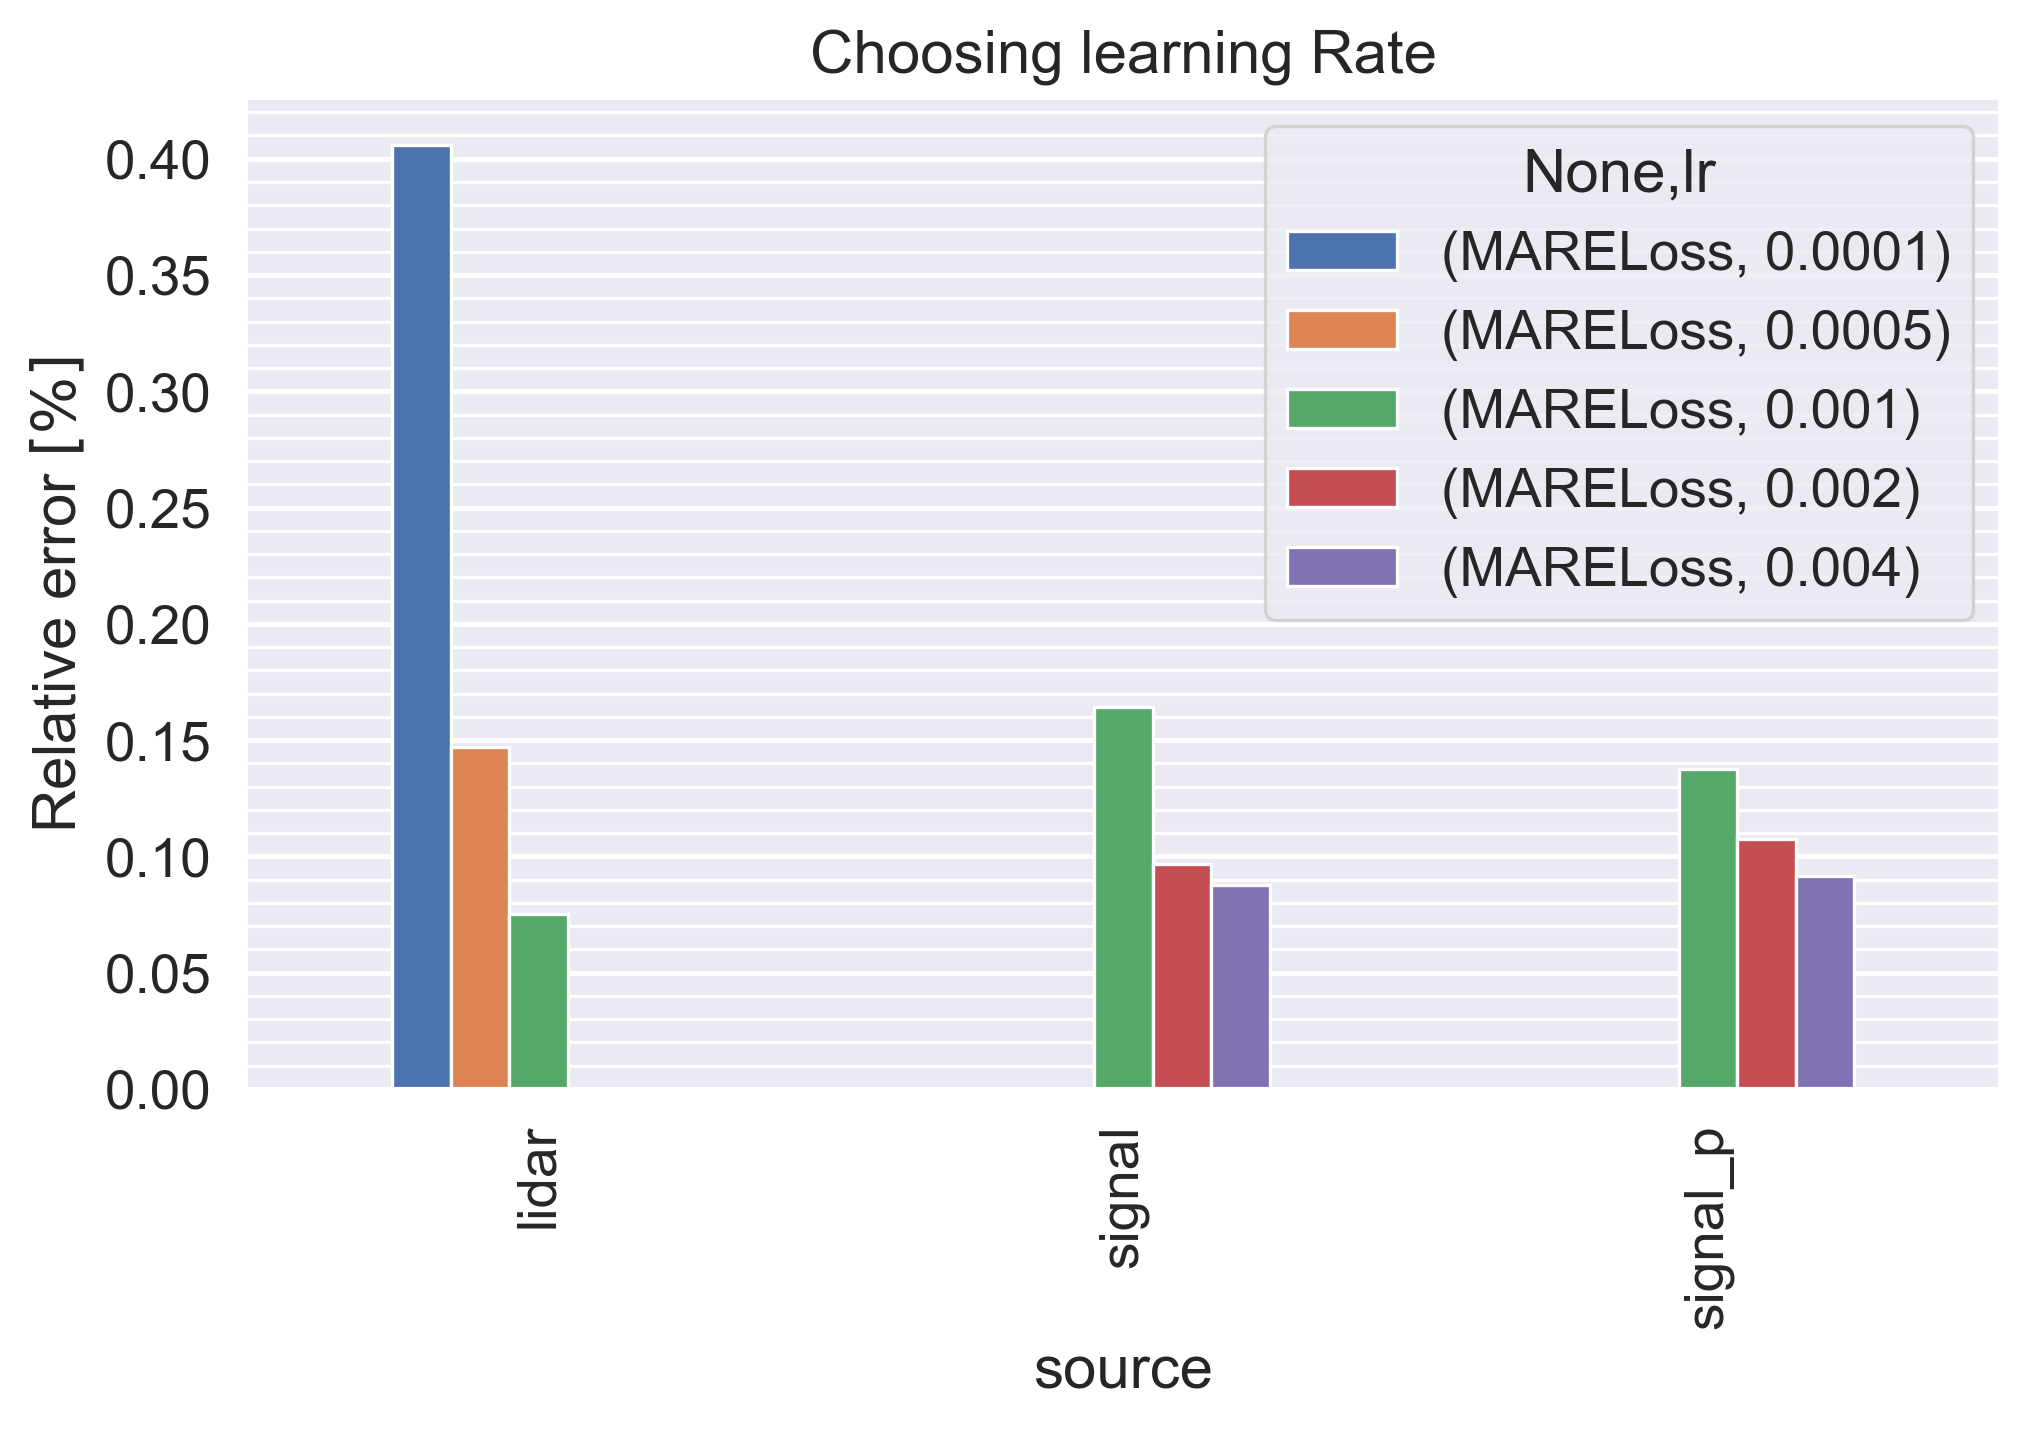

In [64]:
lidar_res = analyse_results#[analyse_results.source=='lidar' ]
lidar_res = lidar_res[lidar_res.use_bg==False]
pow_lidar = lidar_res[(~lidar_res.dnorm & lidar_res.use_power ) ]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar[pow_lidar.bsize==32][pow_lidar.fc_size>4],#[pow_lidar.note=='ok'],
               values=['MARELoss'],
               columns= ['lr'],
               index=['source'],#'fc_size'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Choosing learning Rate')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
ax.set_ylabel(r'Relative error $[\%]$')
plt.tight_layout()
plt.show()

## 2. FC vs. hidden sizes
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar
> lr = 0.001 or lr = 0.005

In [65]:
all_wav = analyse_results #[analyse_results.wavelength=='all']
all_wavs_configABCD = all_wav[all_wav.config!='Other']

<ipython-input-66-58788e14ef31>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr'][all_wavs_configABCD.use_power!=False][all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],
<ipython-input-66-58788e14ef31>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr'][all_wavs_configABCD.use_power!=False][all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],


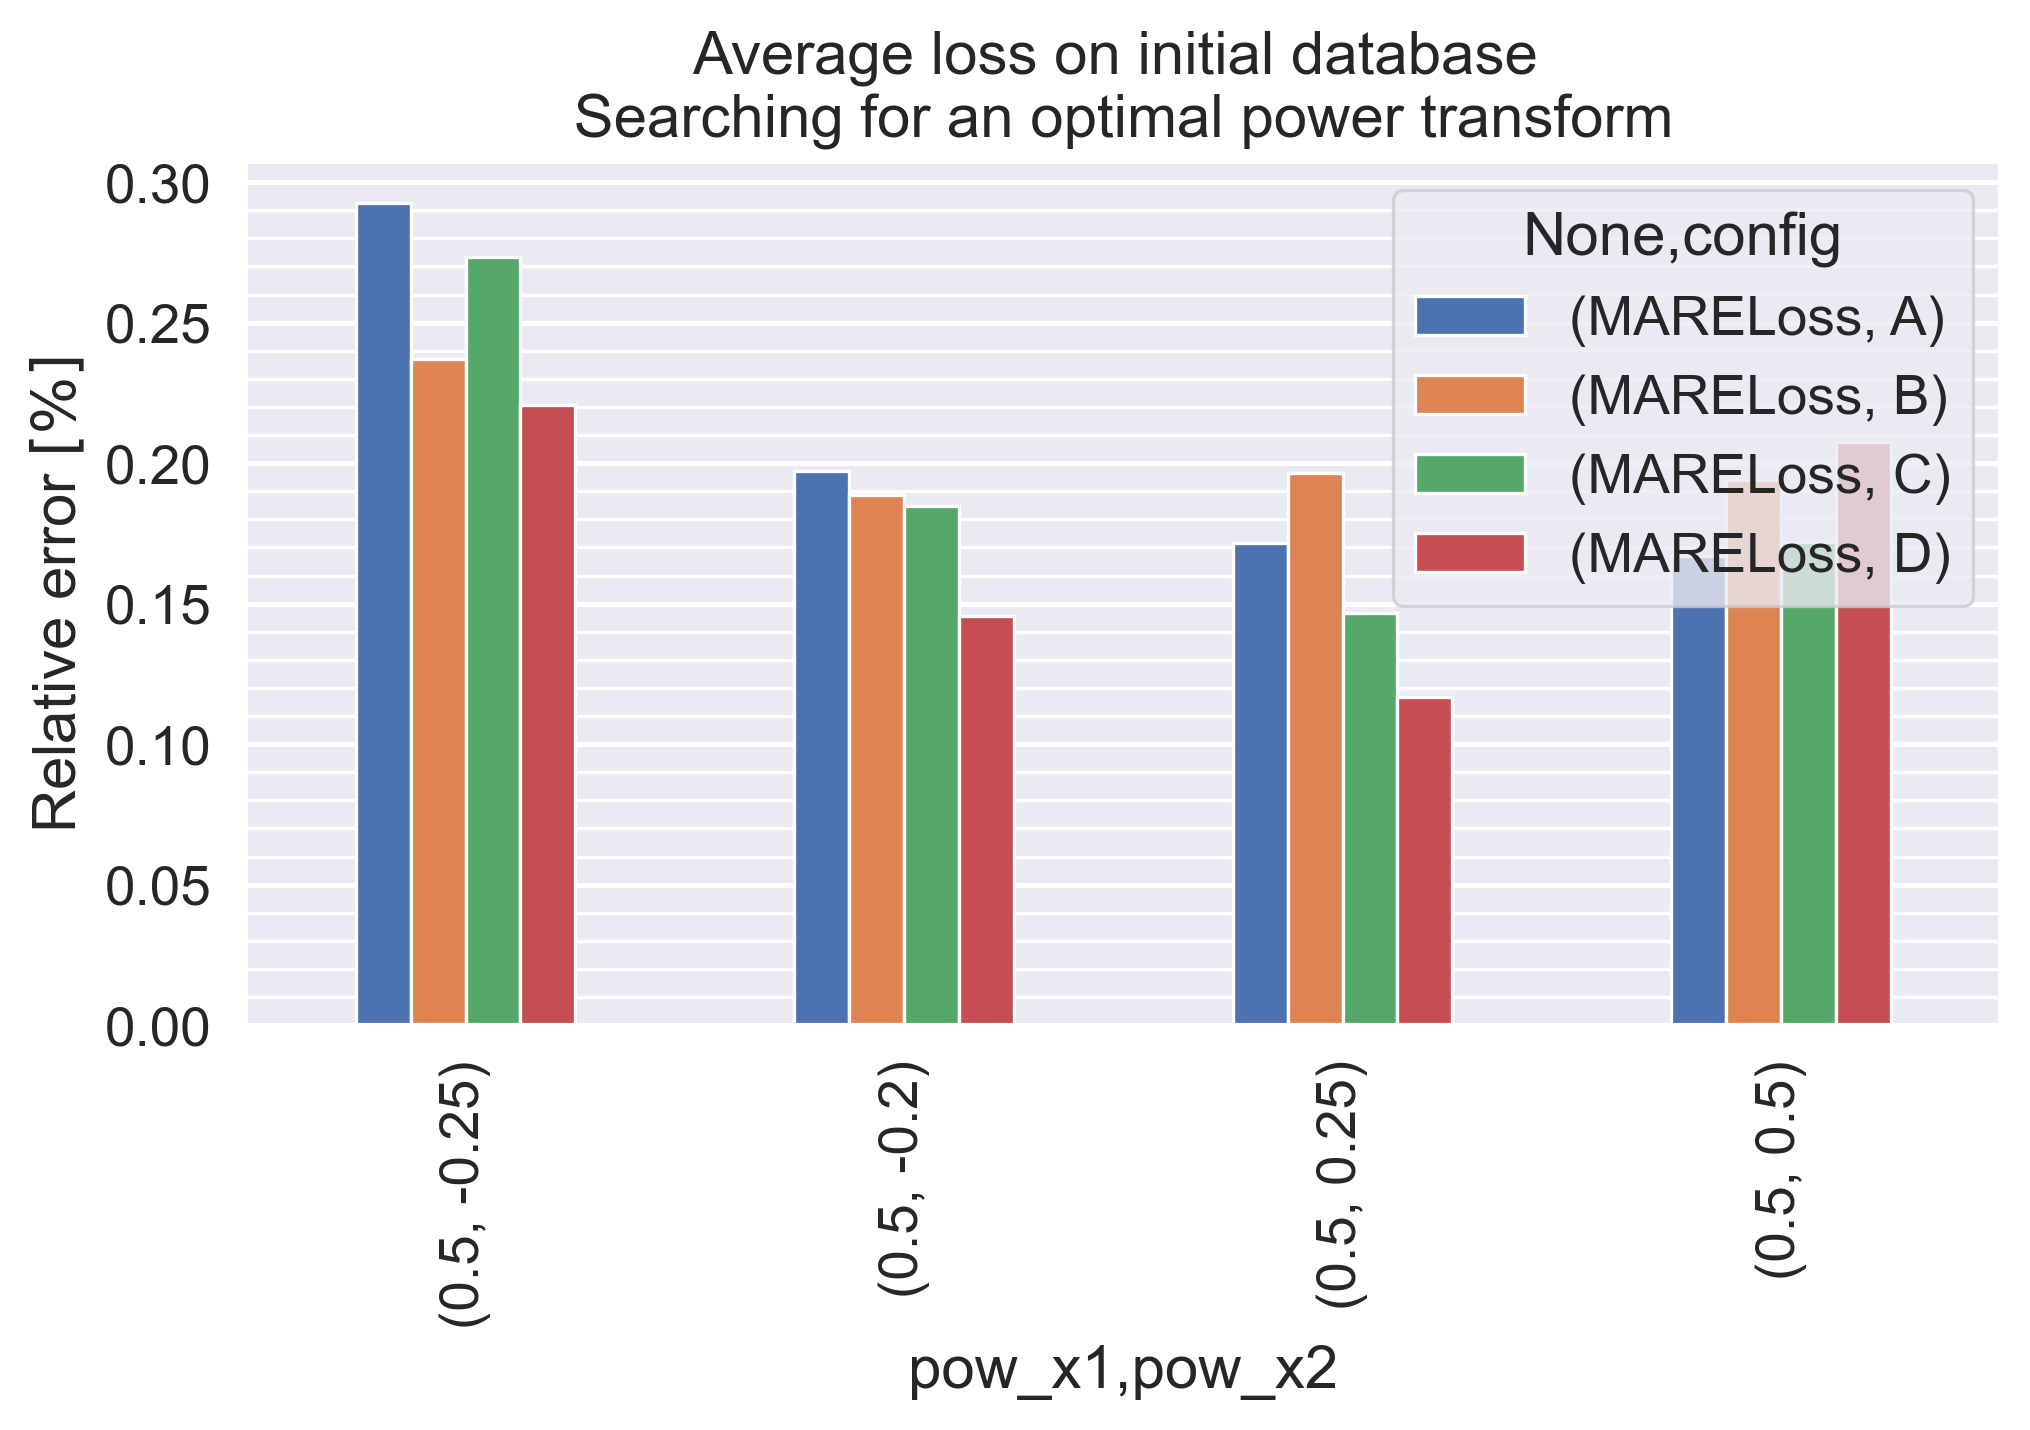

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr'][all_wavs_configABCD.use_power!=False][all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['pow_x1','pow_x2'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Searching for an optimal power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()


<ipython-input-67-b23f3d78b36a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr'][all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],


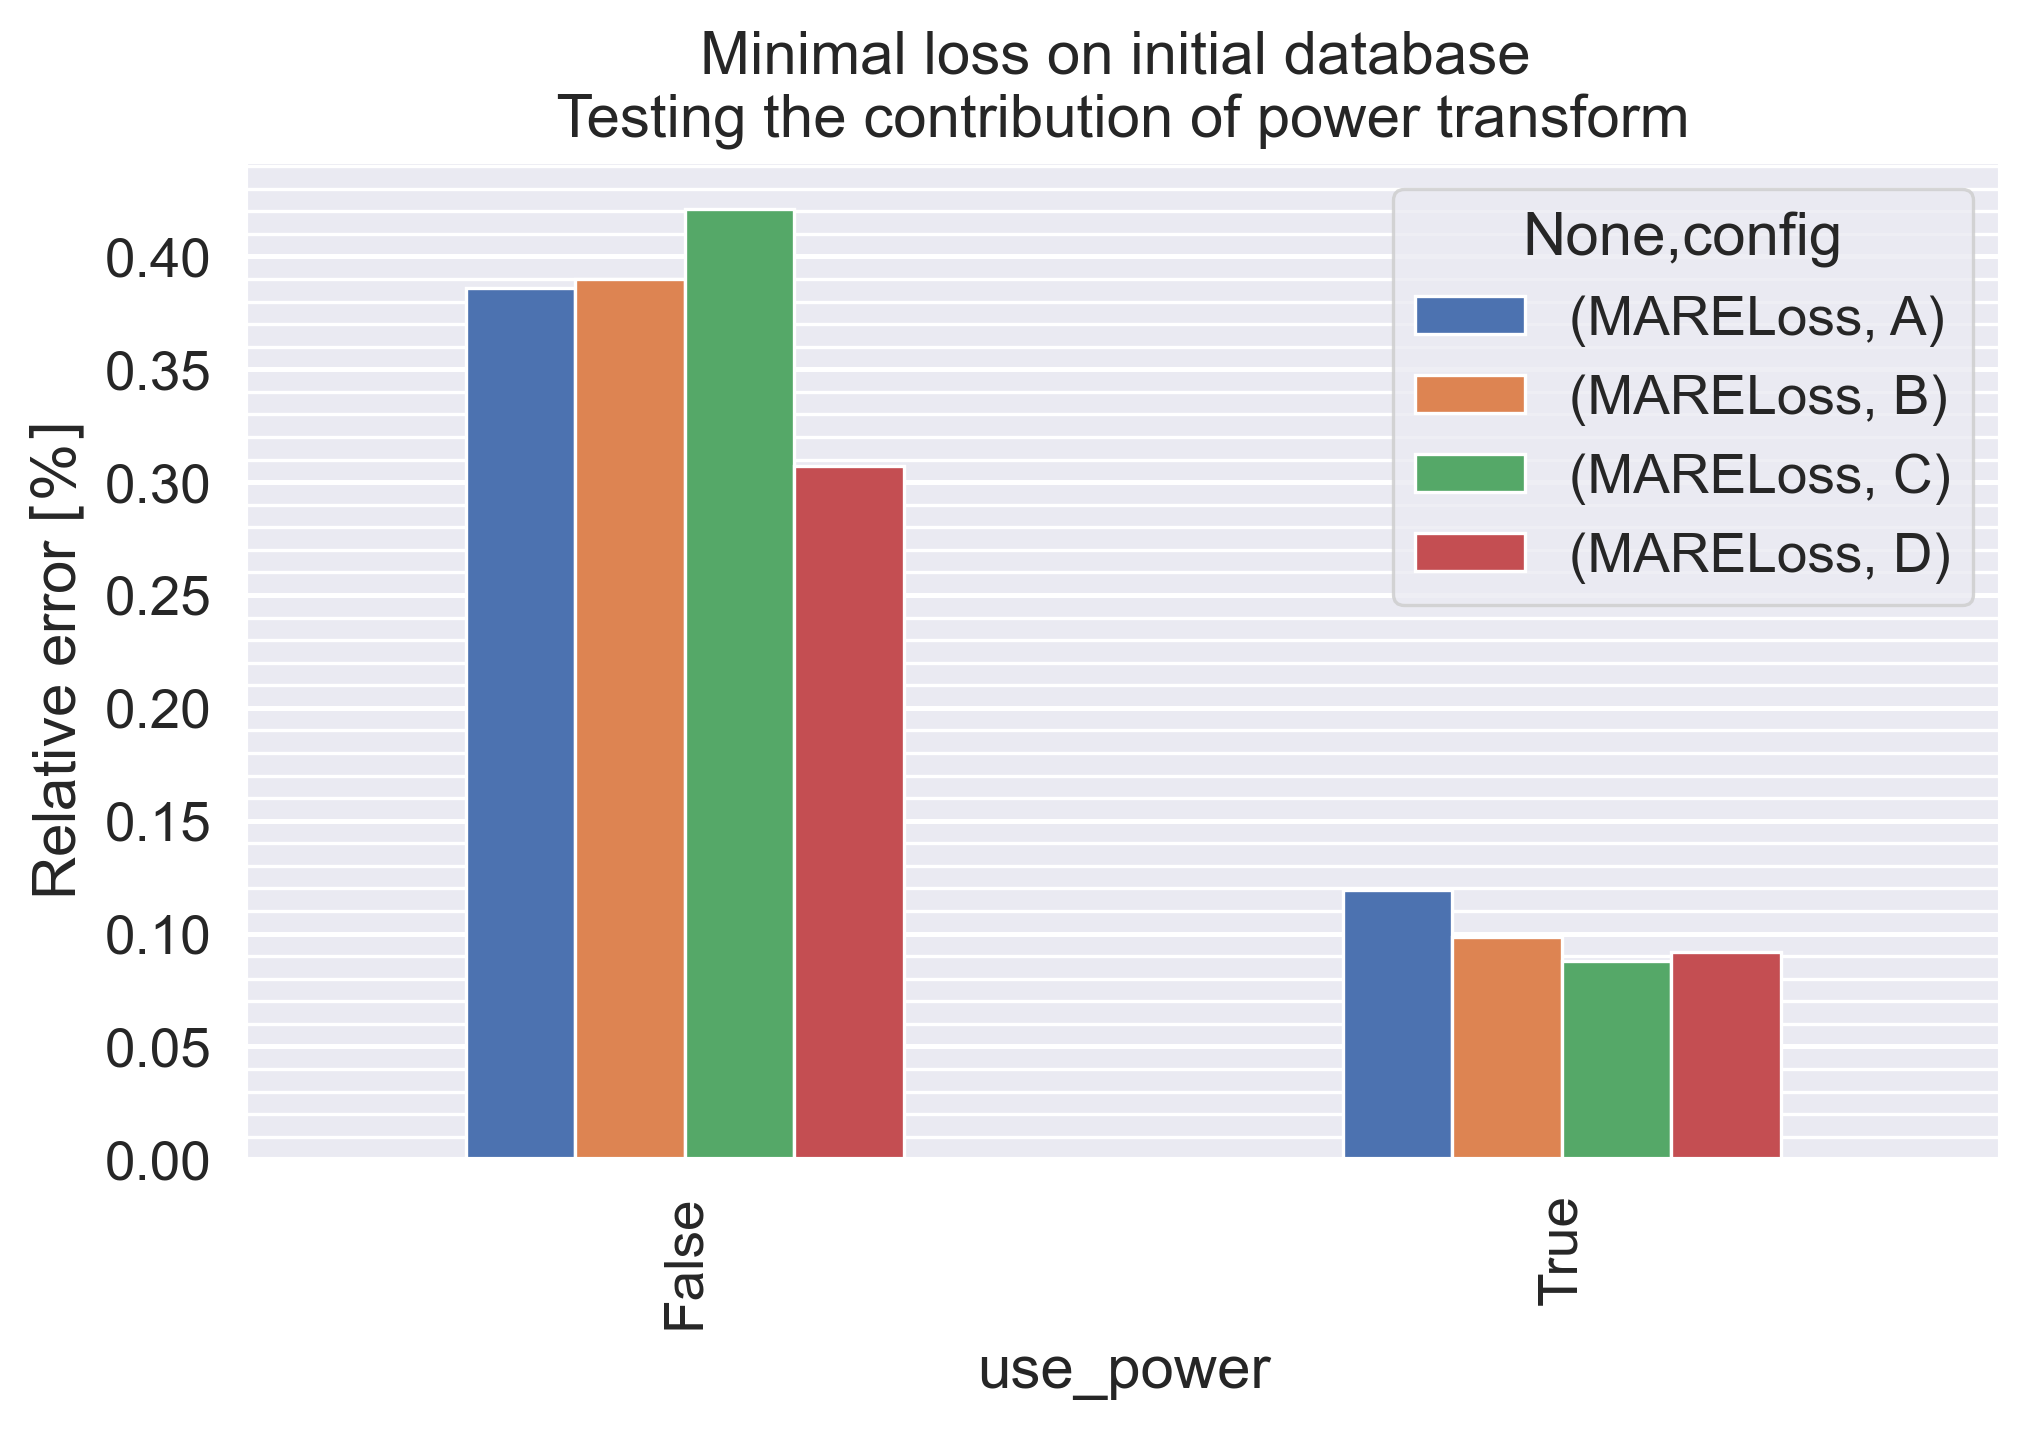

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr'][all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_power'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the contribution of power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-68-a7e10f560838>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],


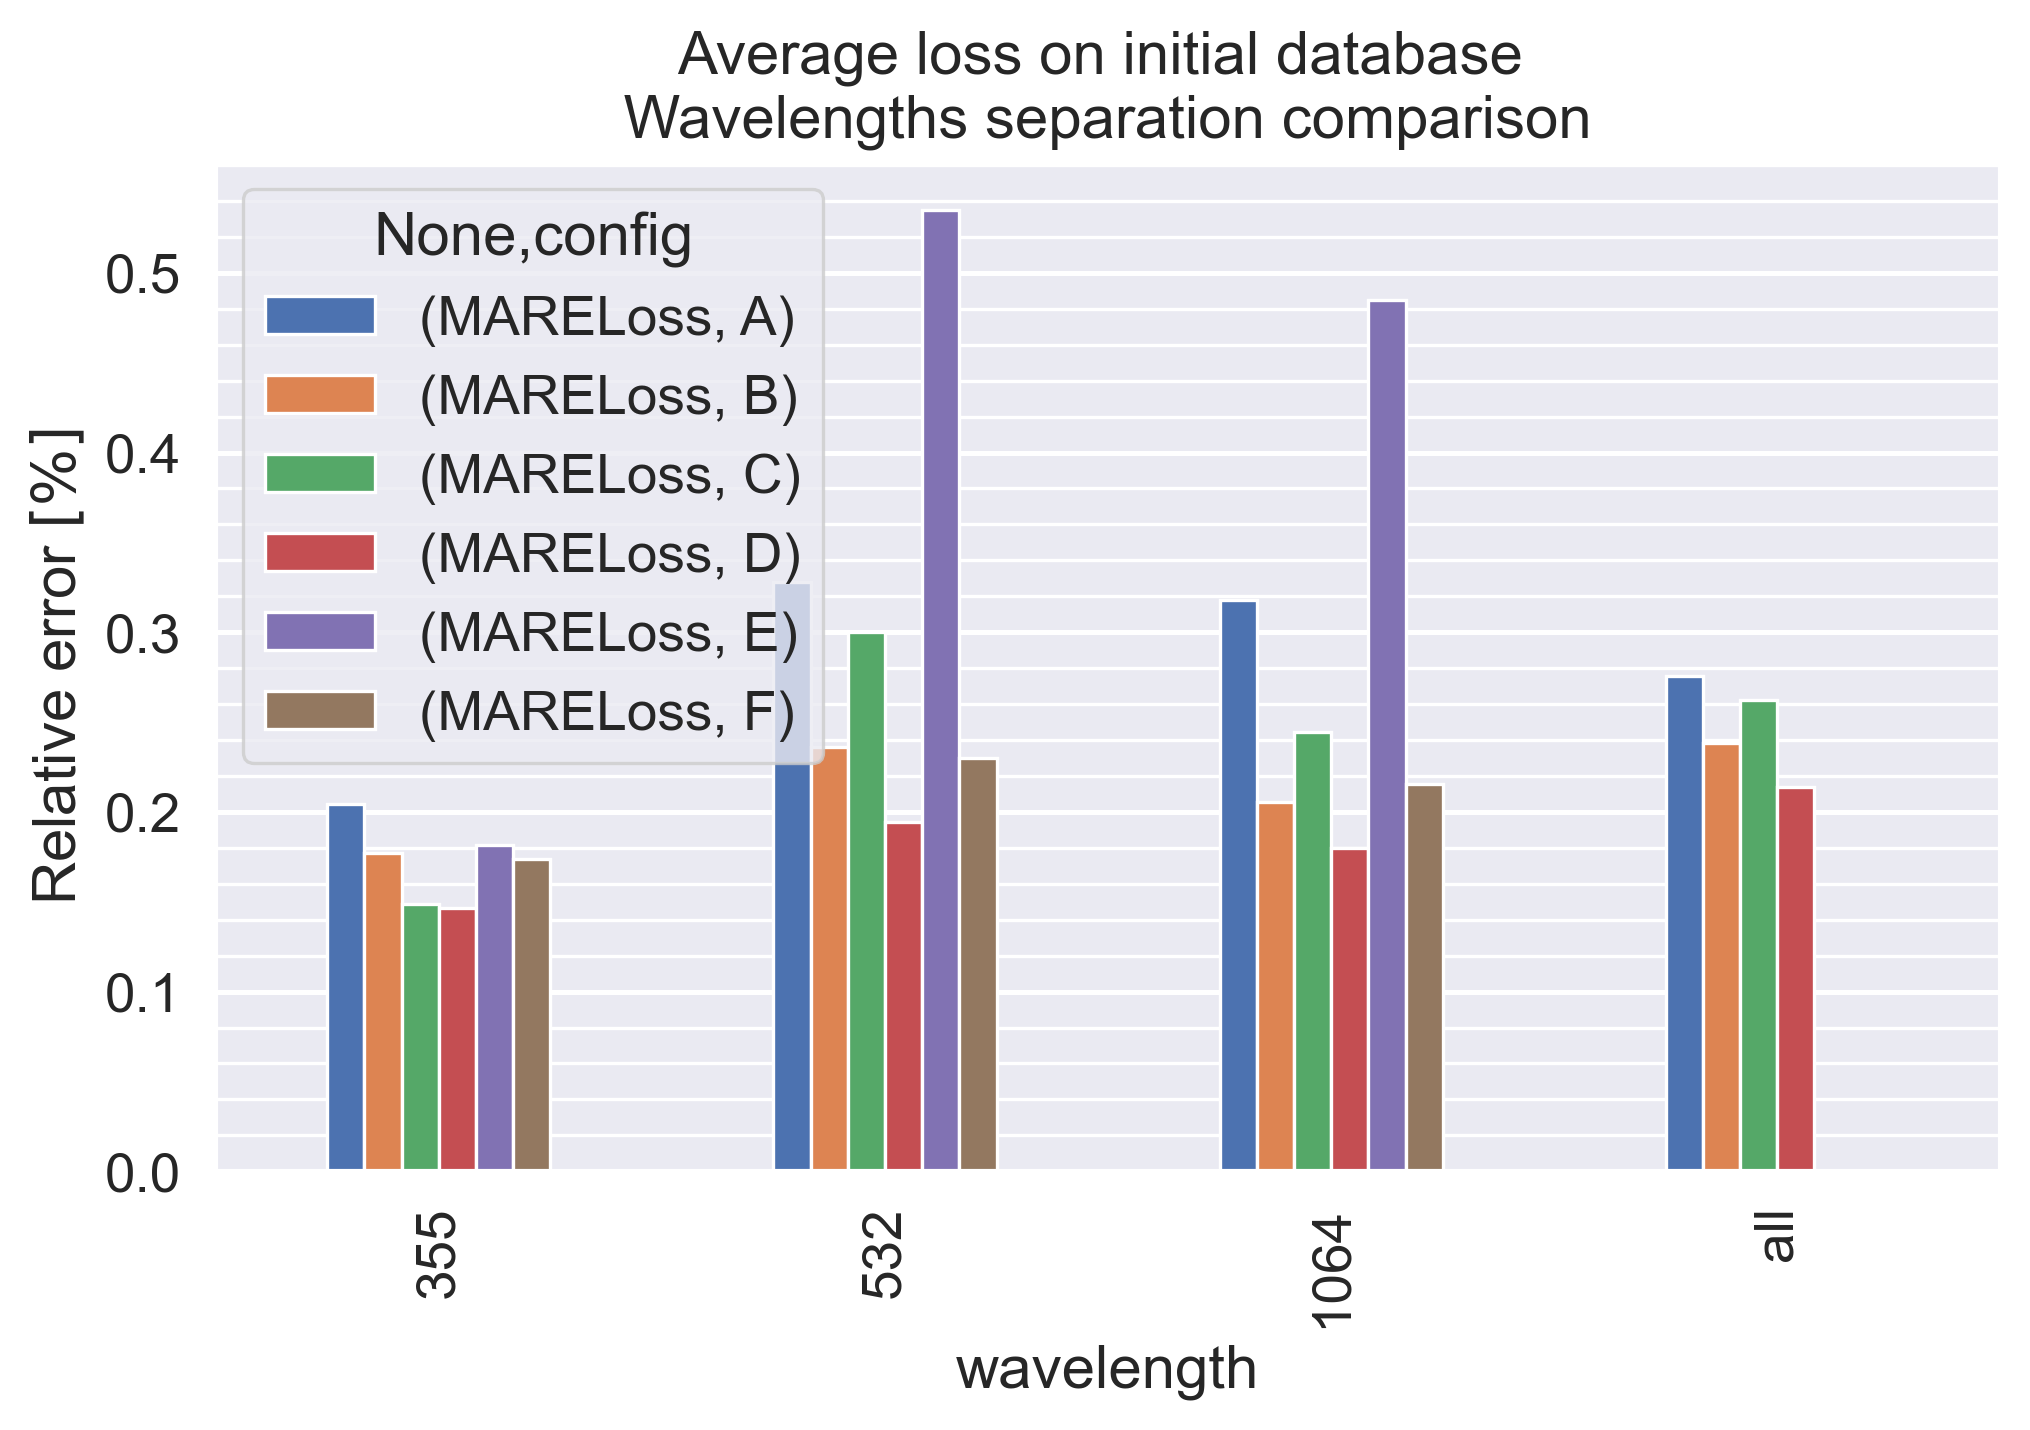

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Wavelengths separation comparison ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-69-e12a5c488a91>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


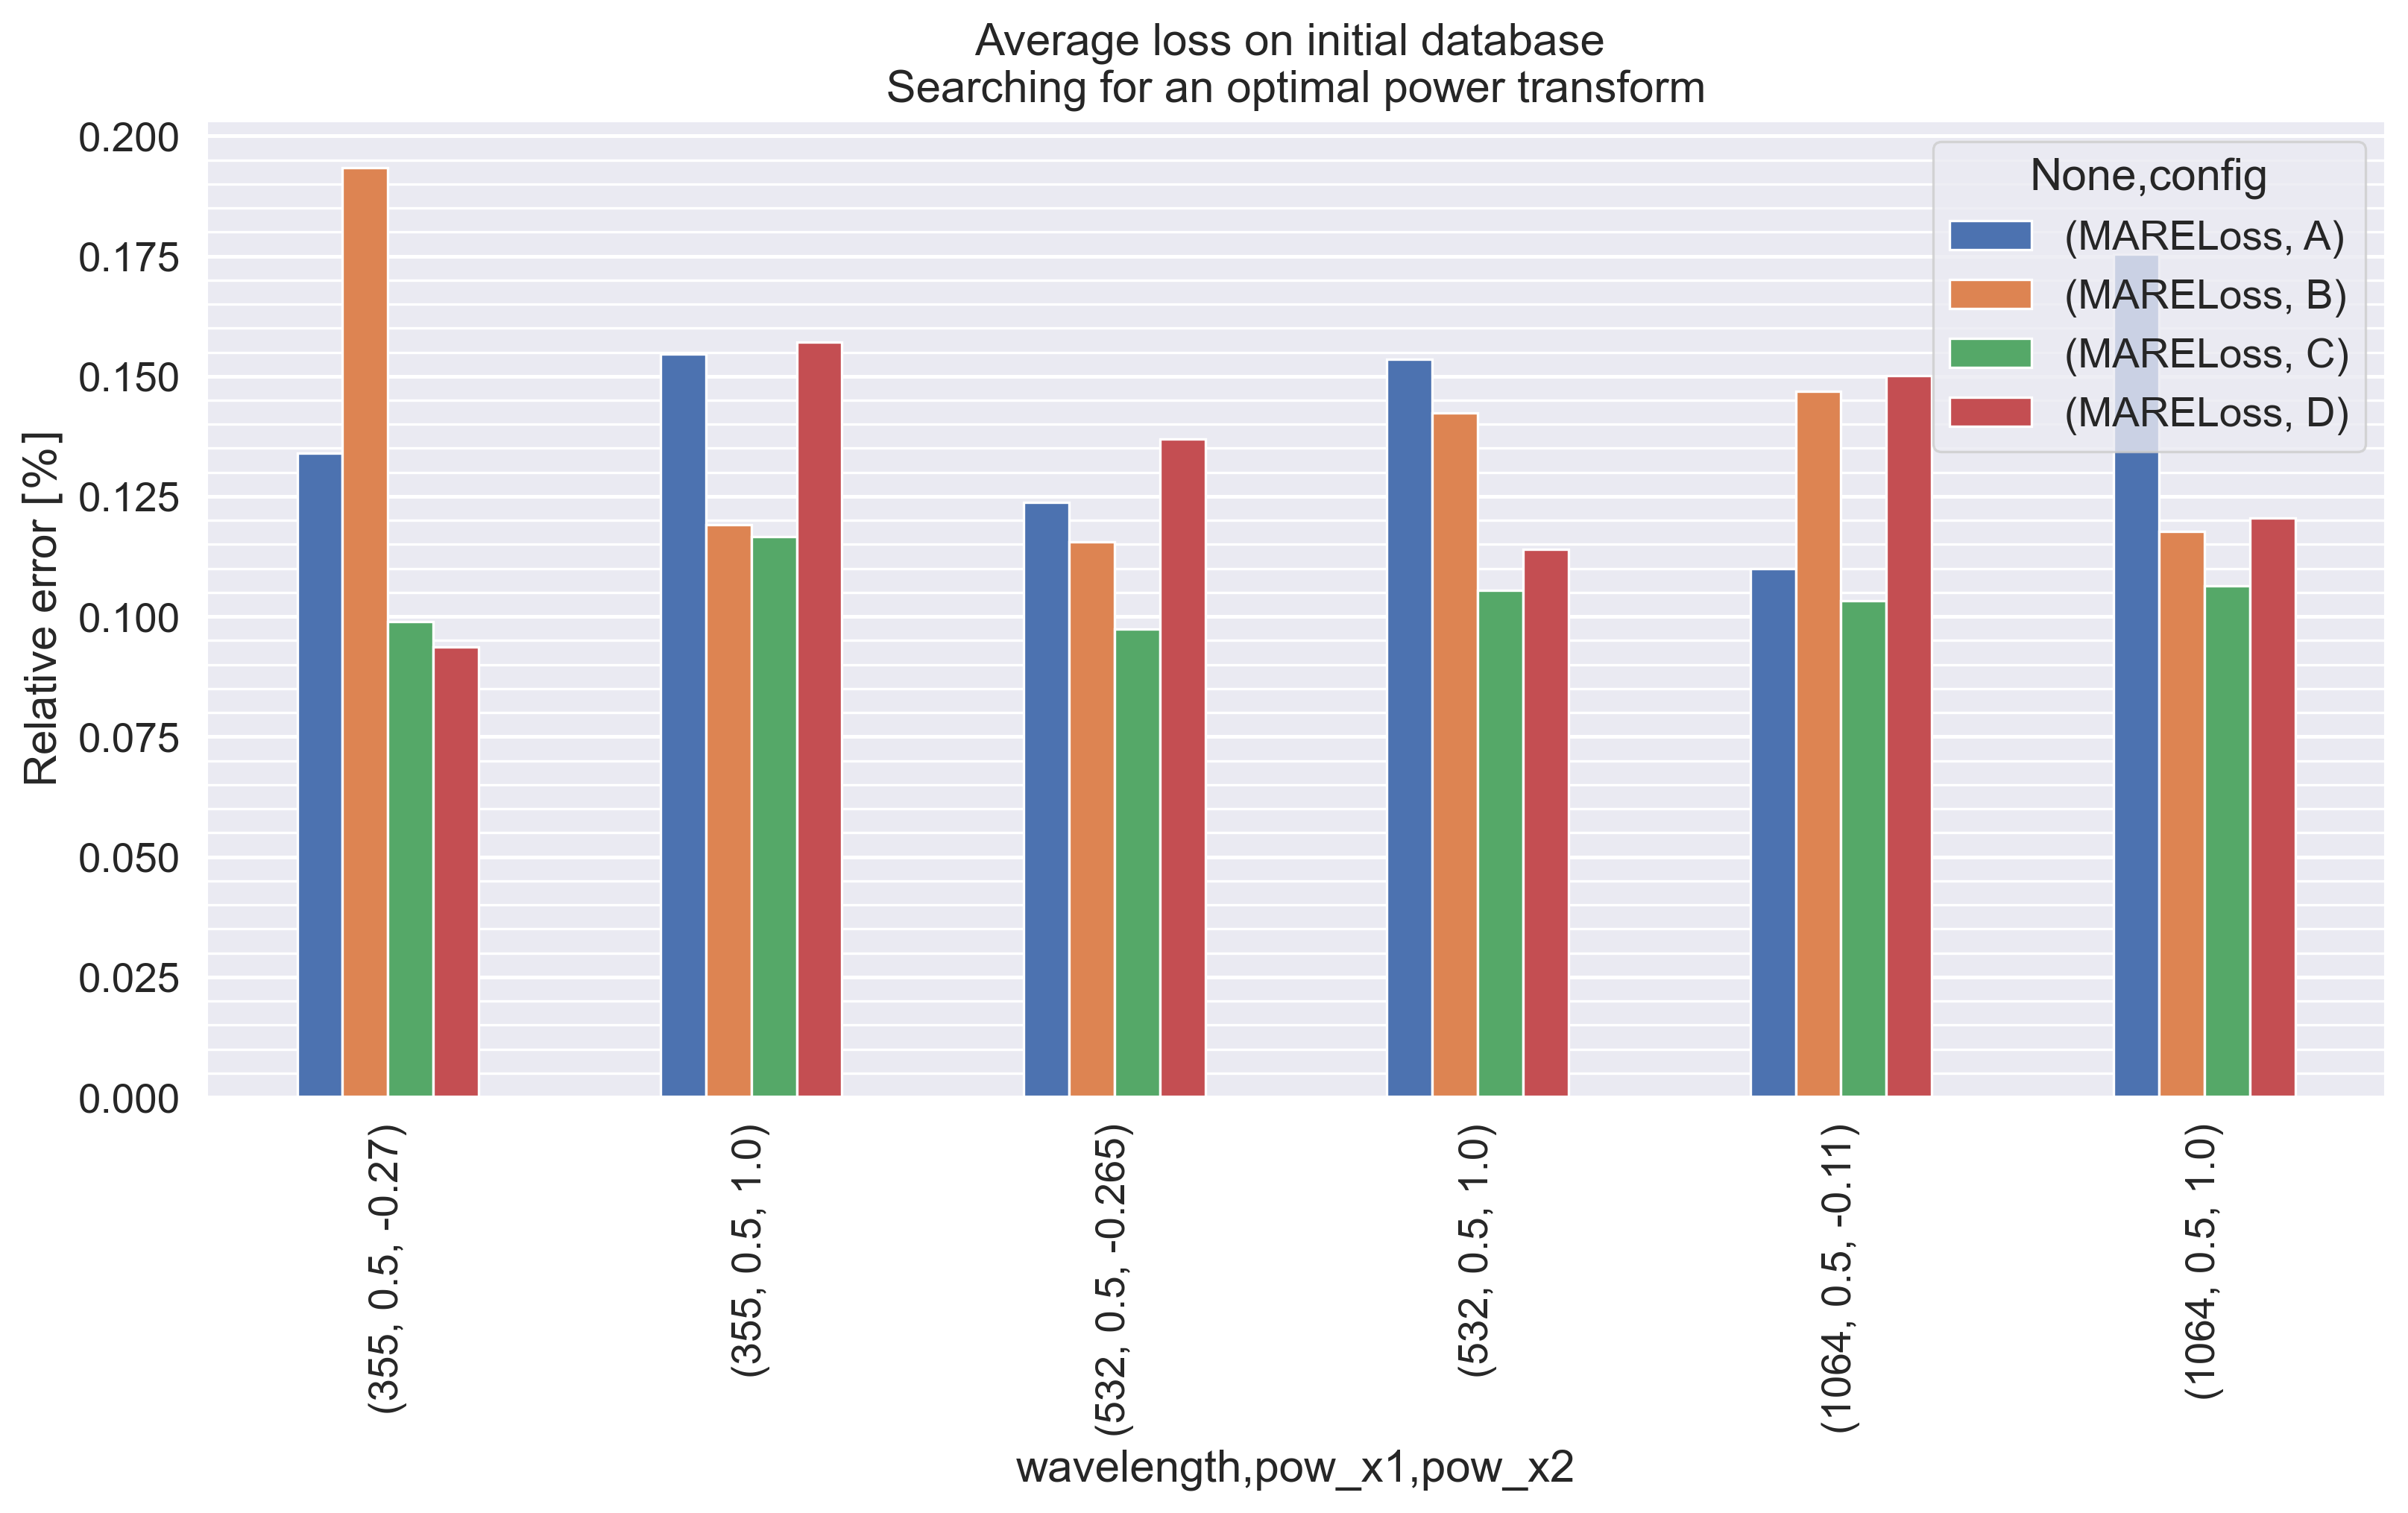

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x1','pow_x2'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Searching for an optimal power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-70-c9c96c5e9d22>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],


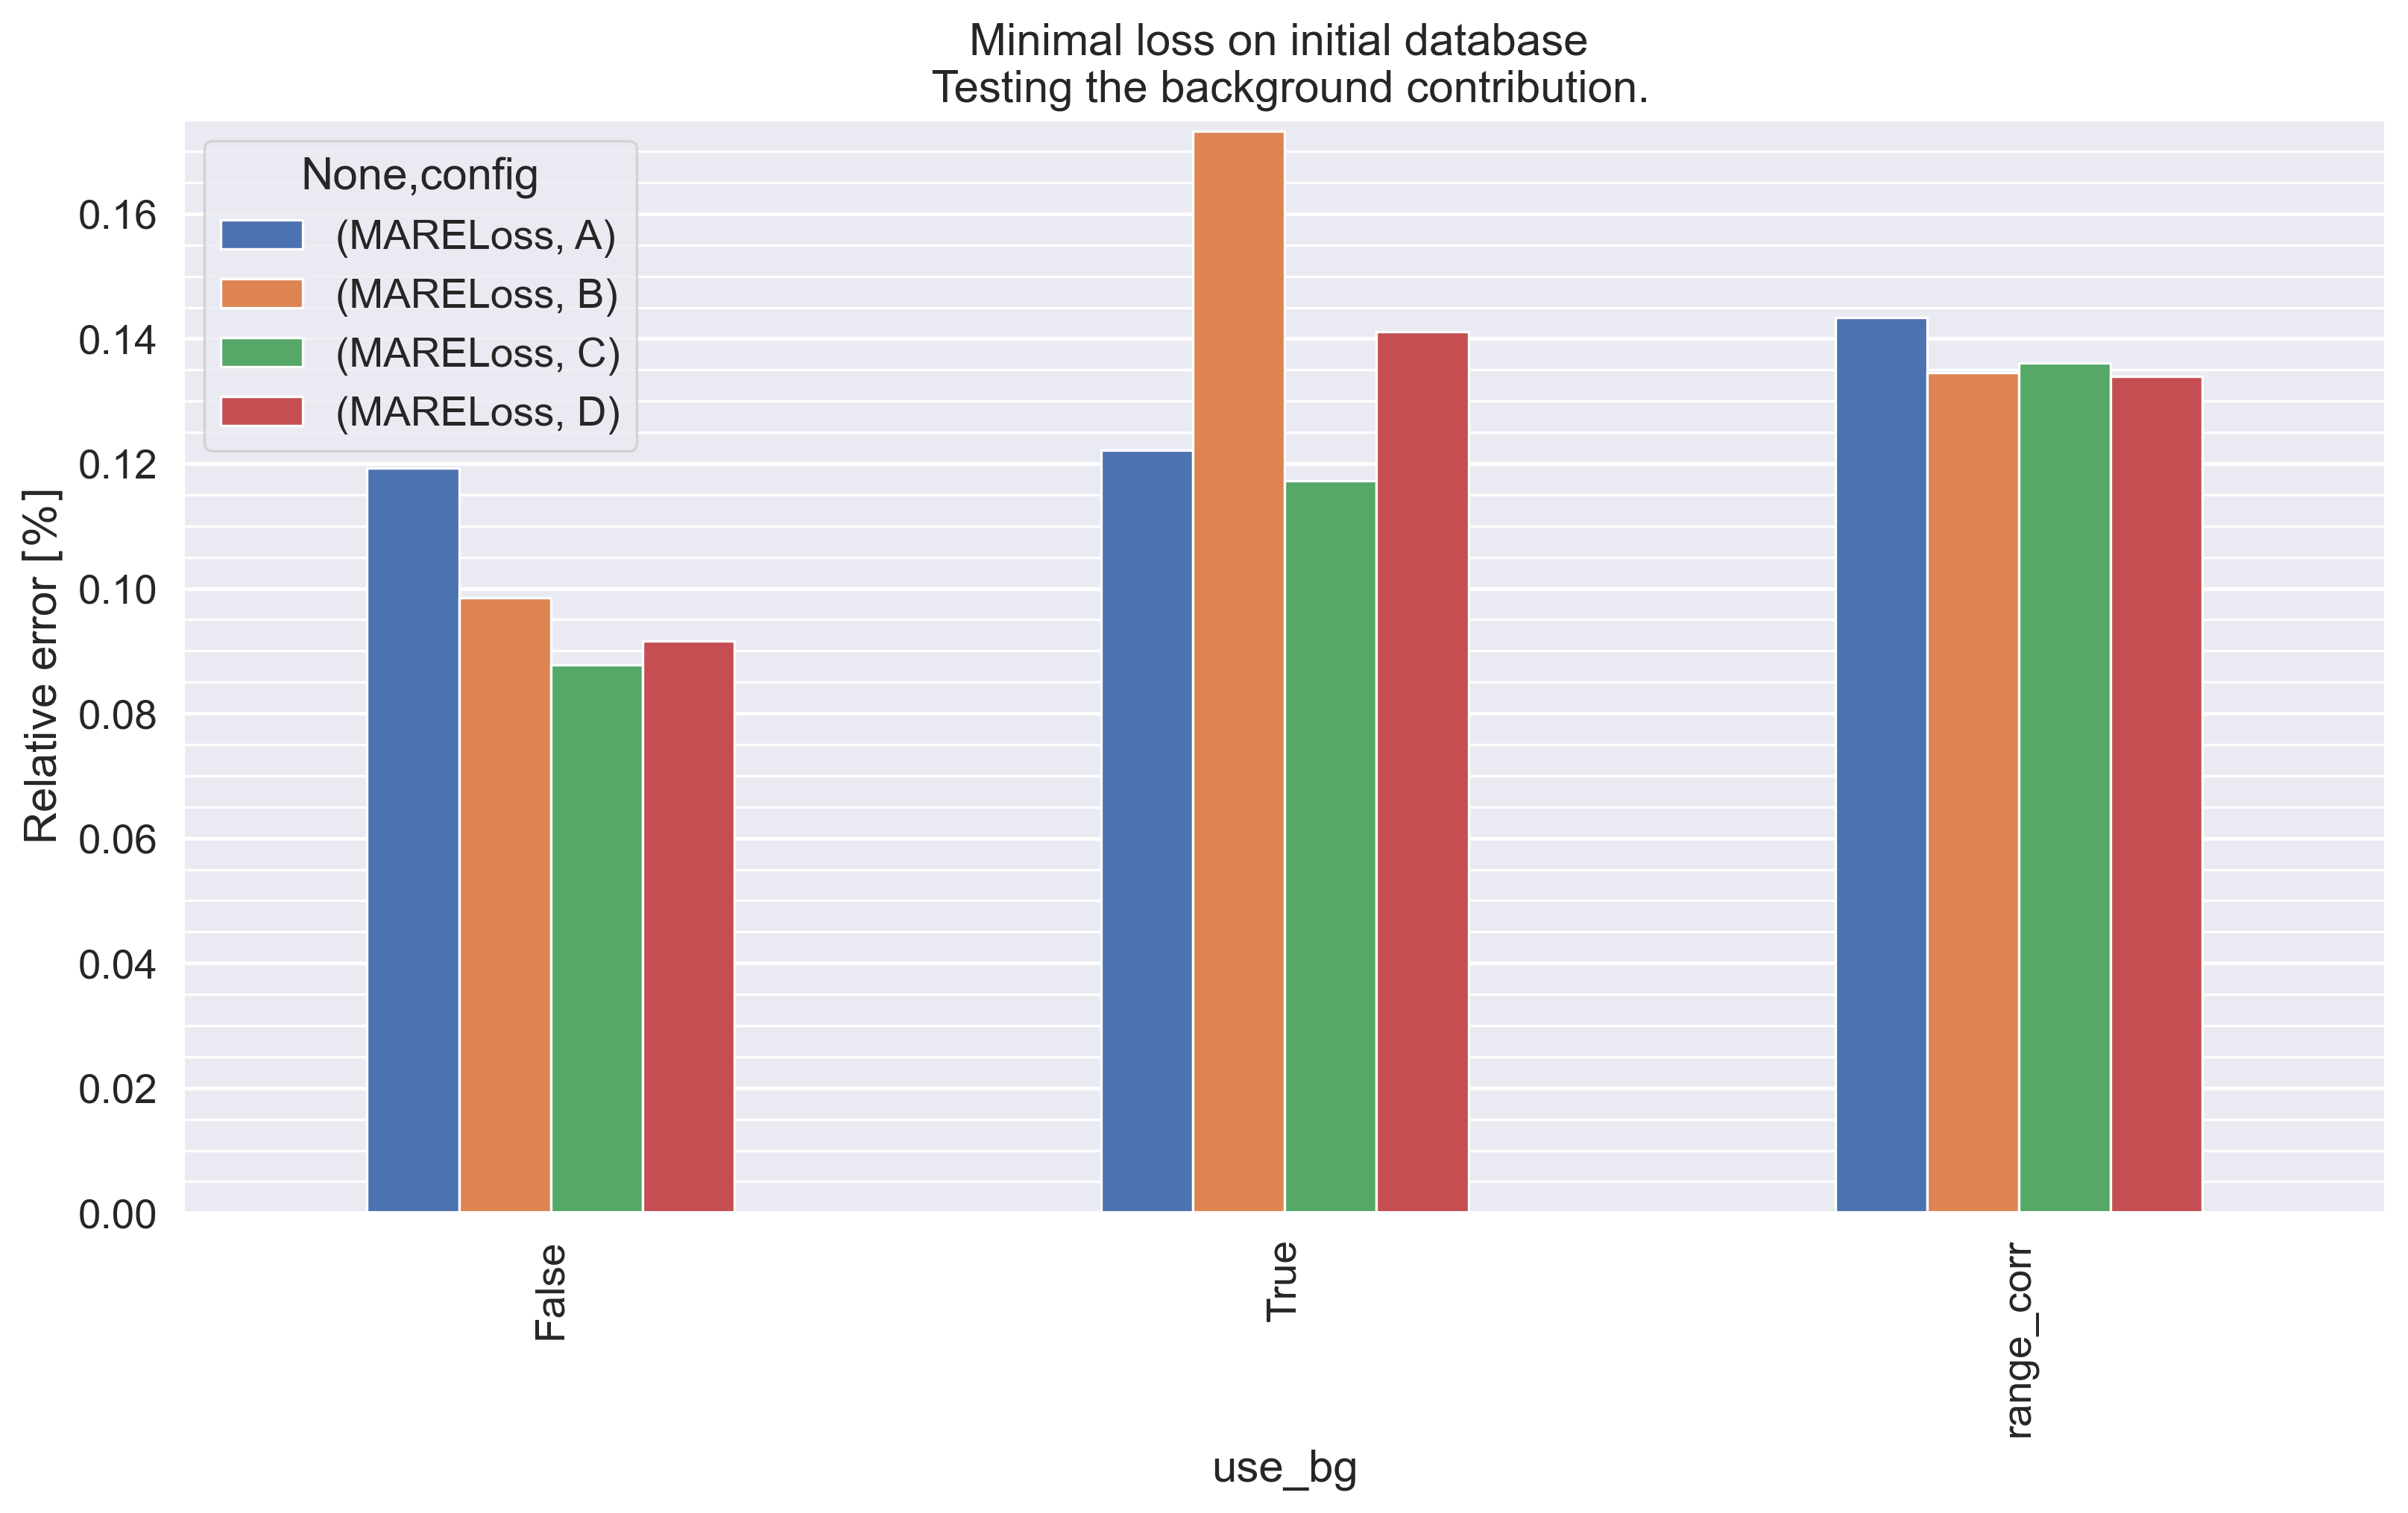

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the background contribution.')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.set_ylim([0.0, 0.175])
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-71-9bb2dd6716b6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],


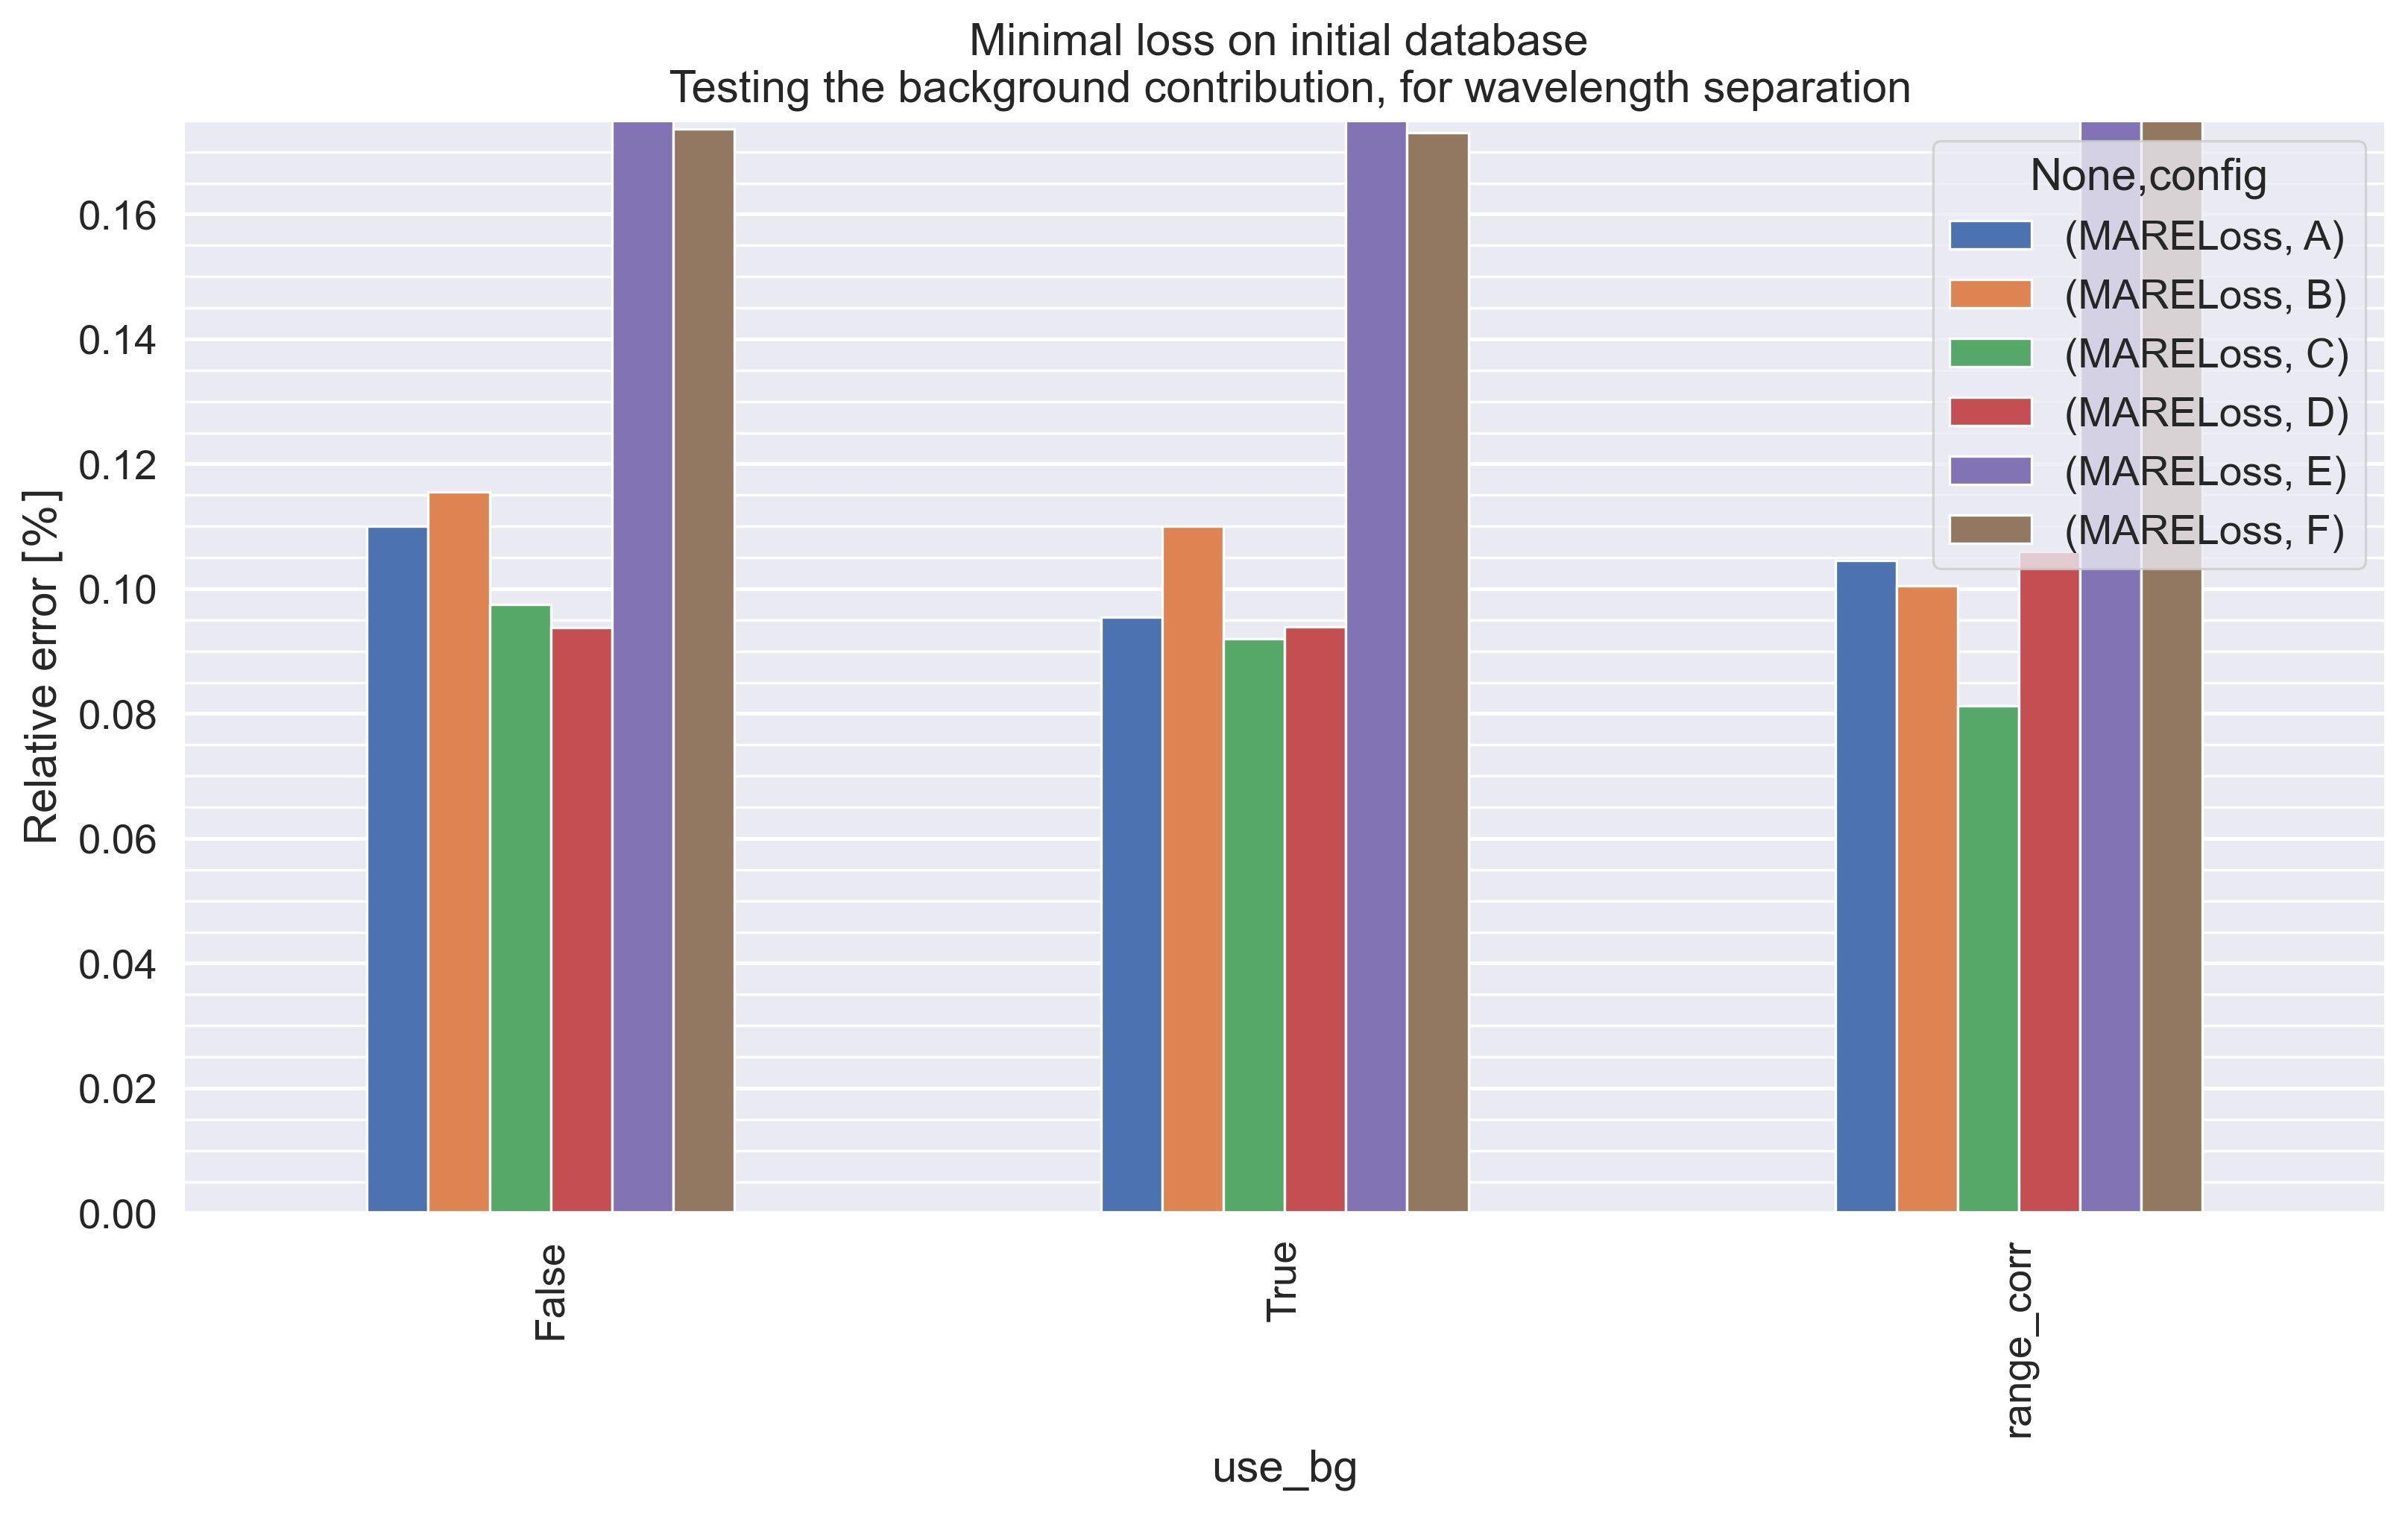

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the background contribution, for wavelength separation')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylim([0.0, 0.175])
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-72-b9fb5c6e891f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],


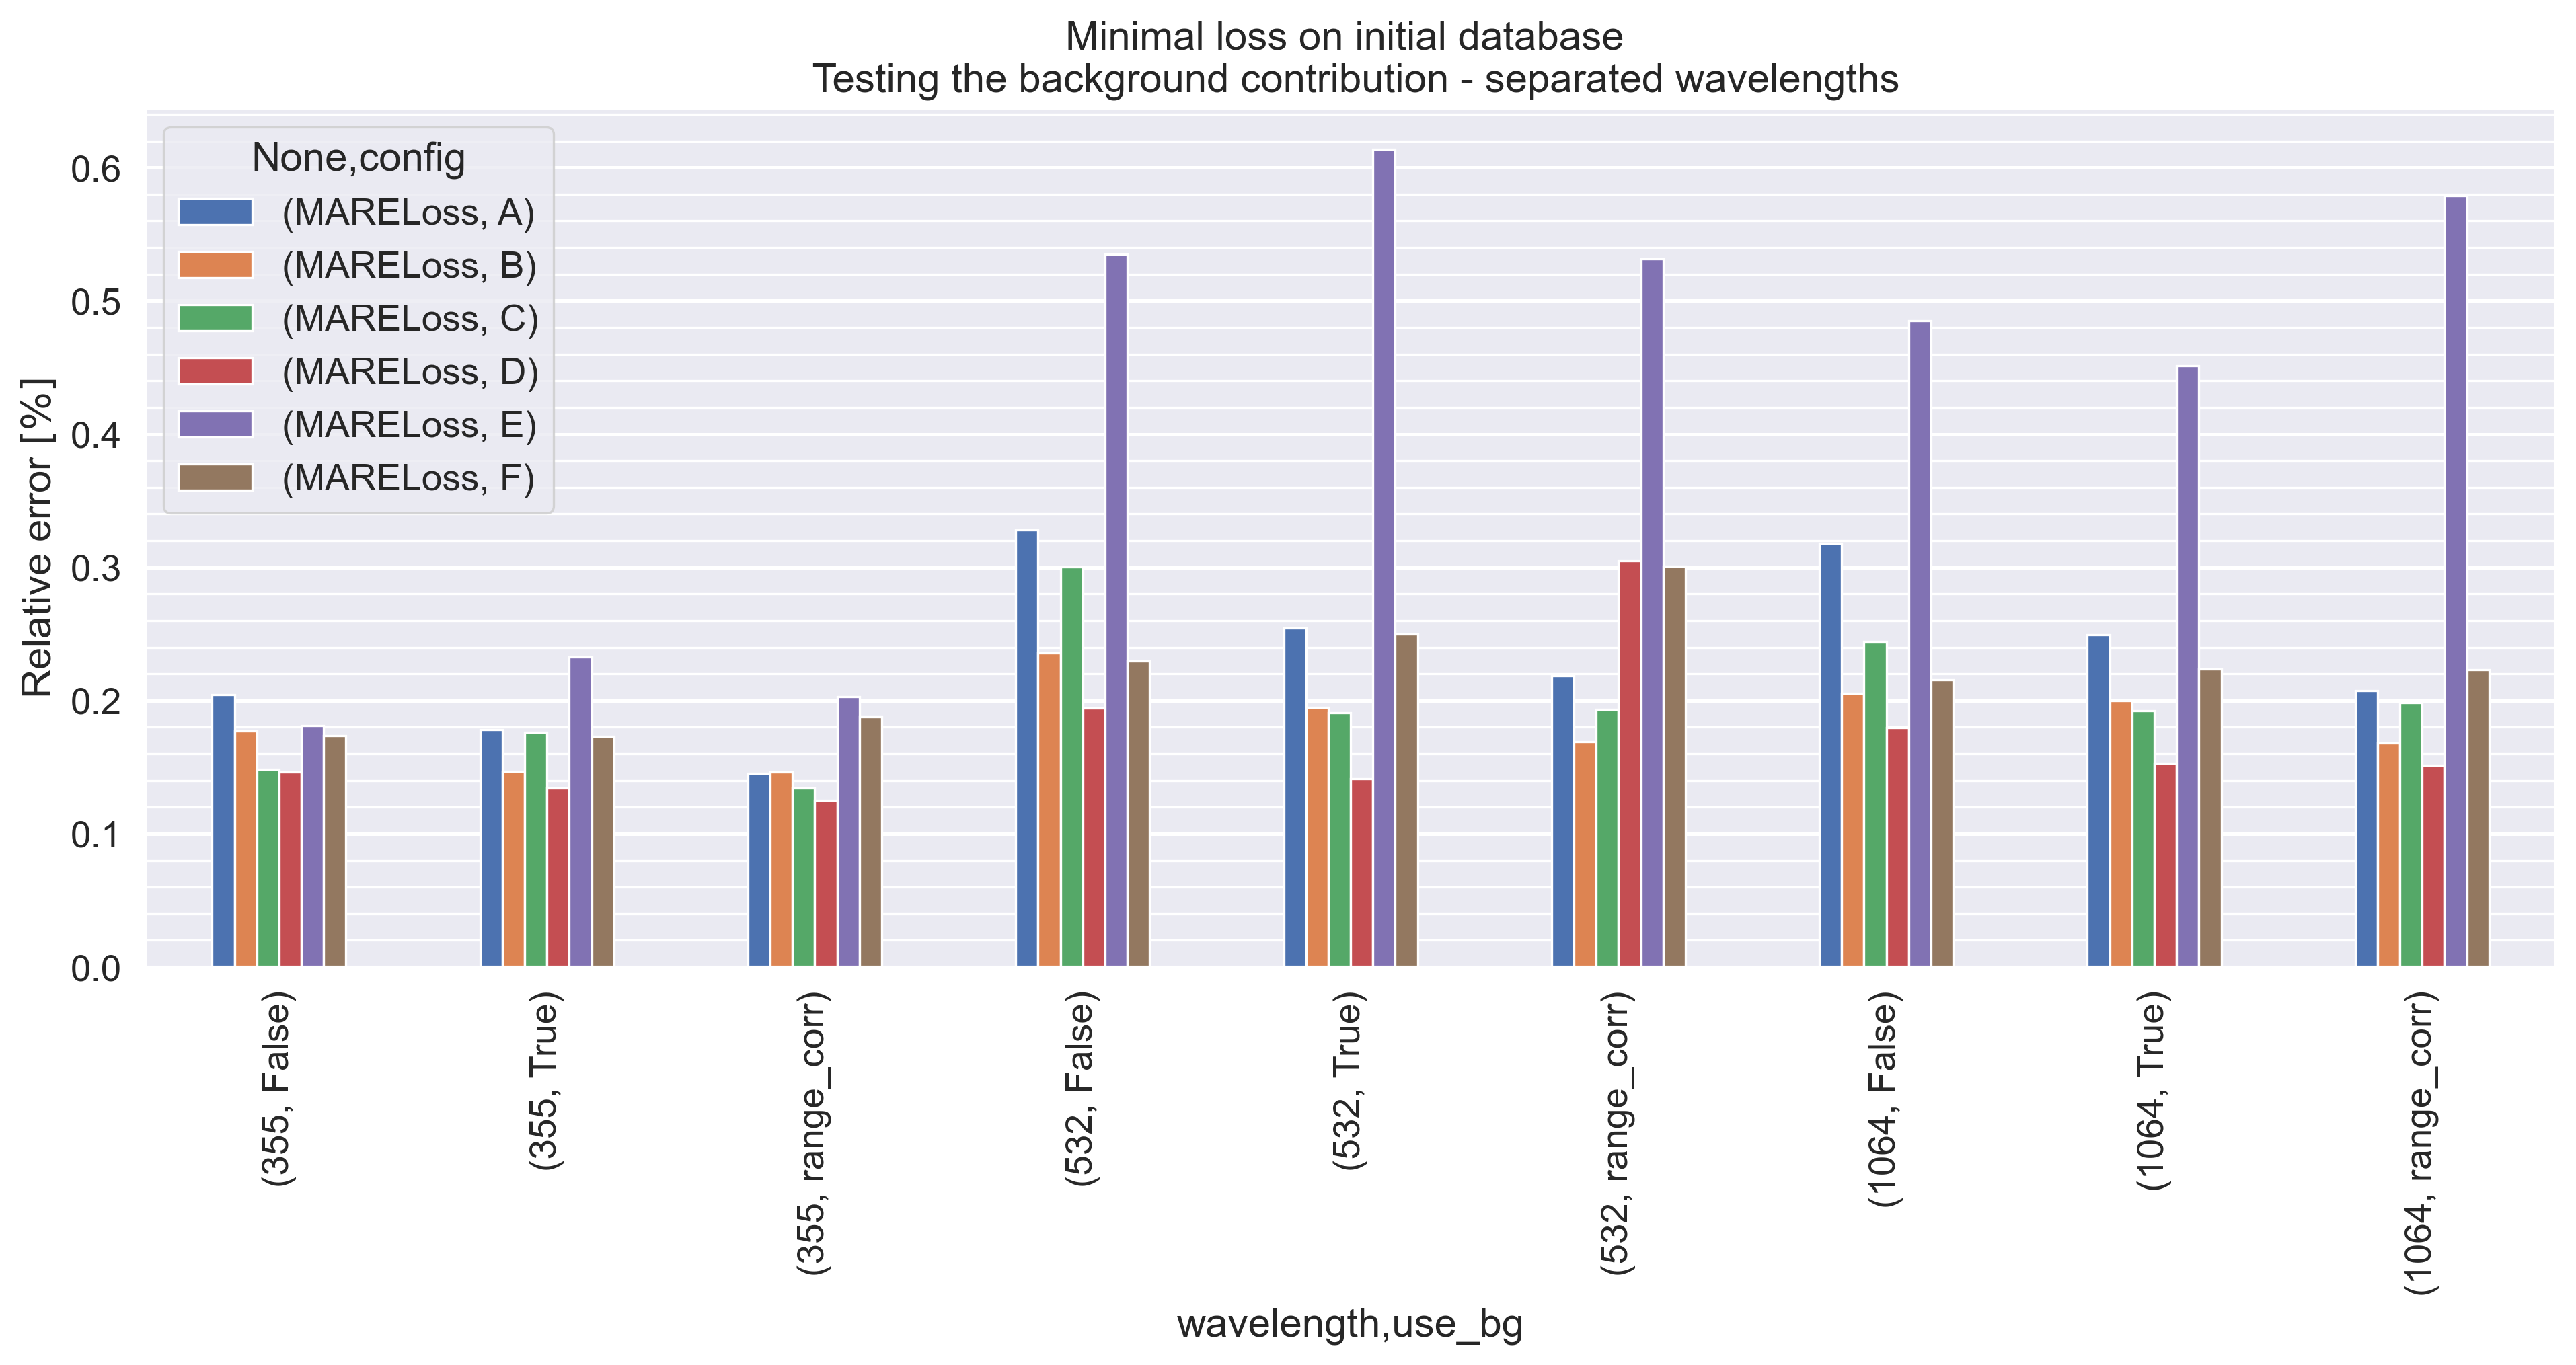

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','use_bg'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the background contribution - separated wavelengths')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()


<ipython-input-73-21731320a99d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']
<ipython-input-73-21731320a99d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']
<ipython-input-73-21731320a99d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


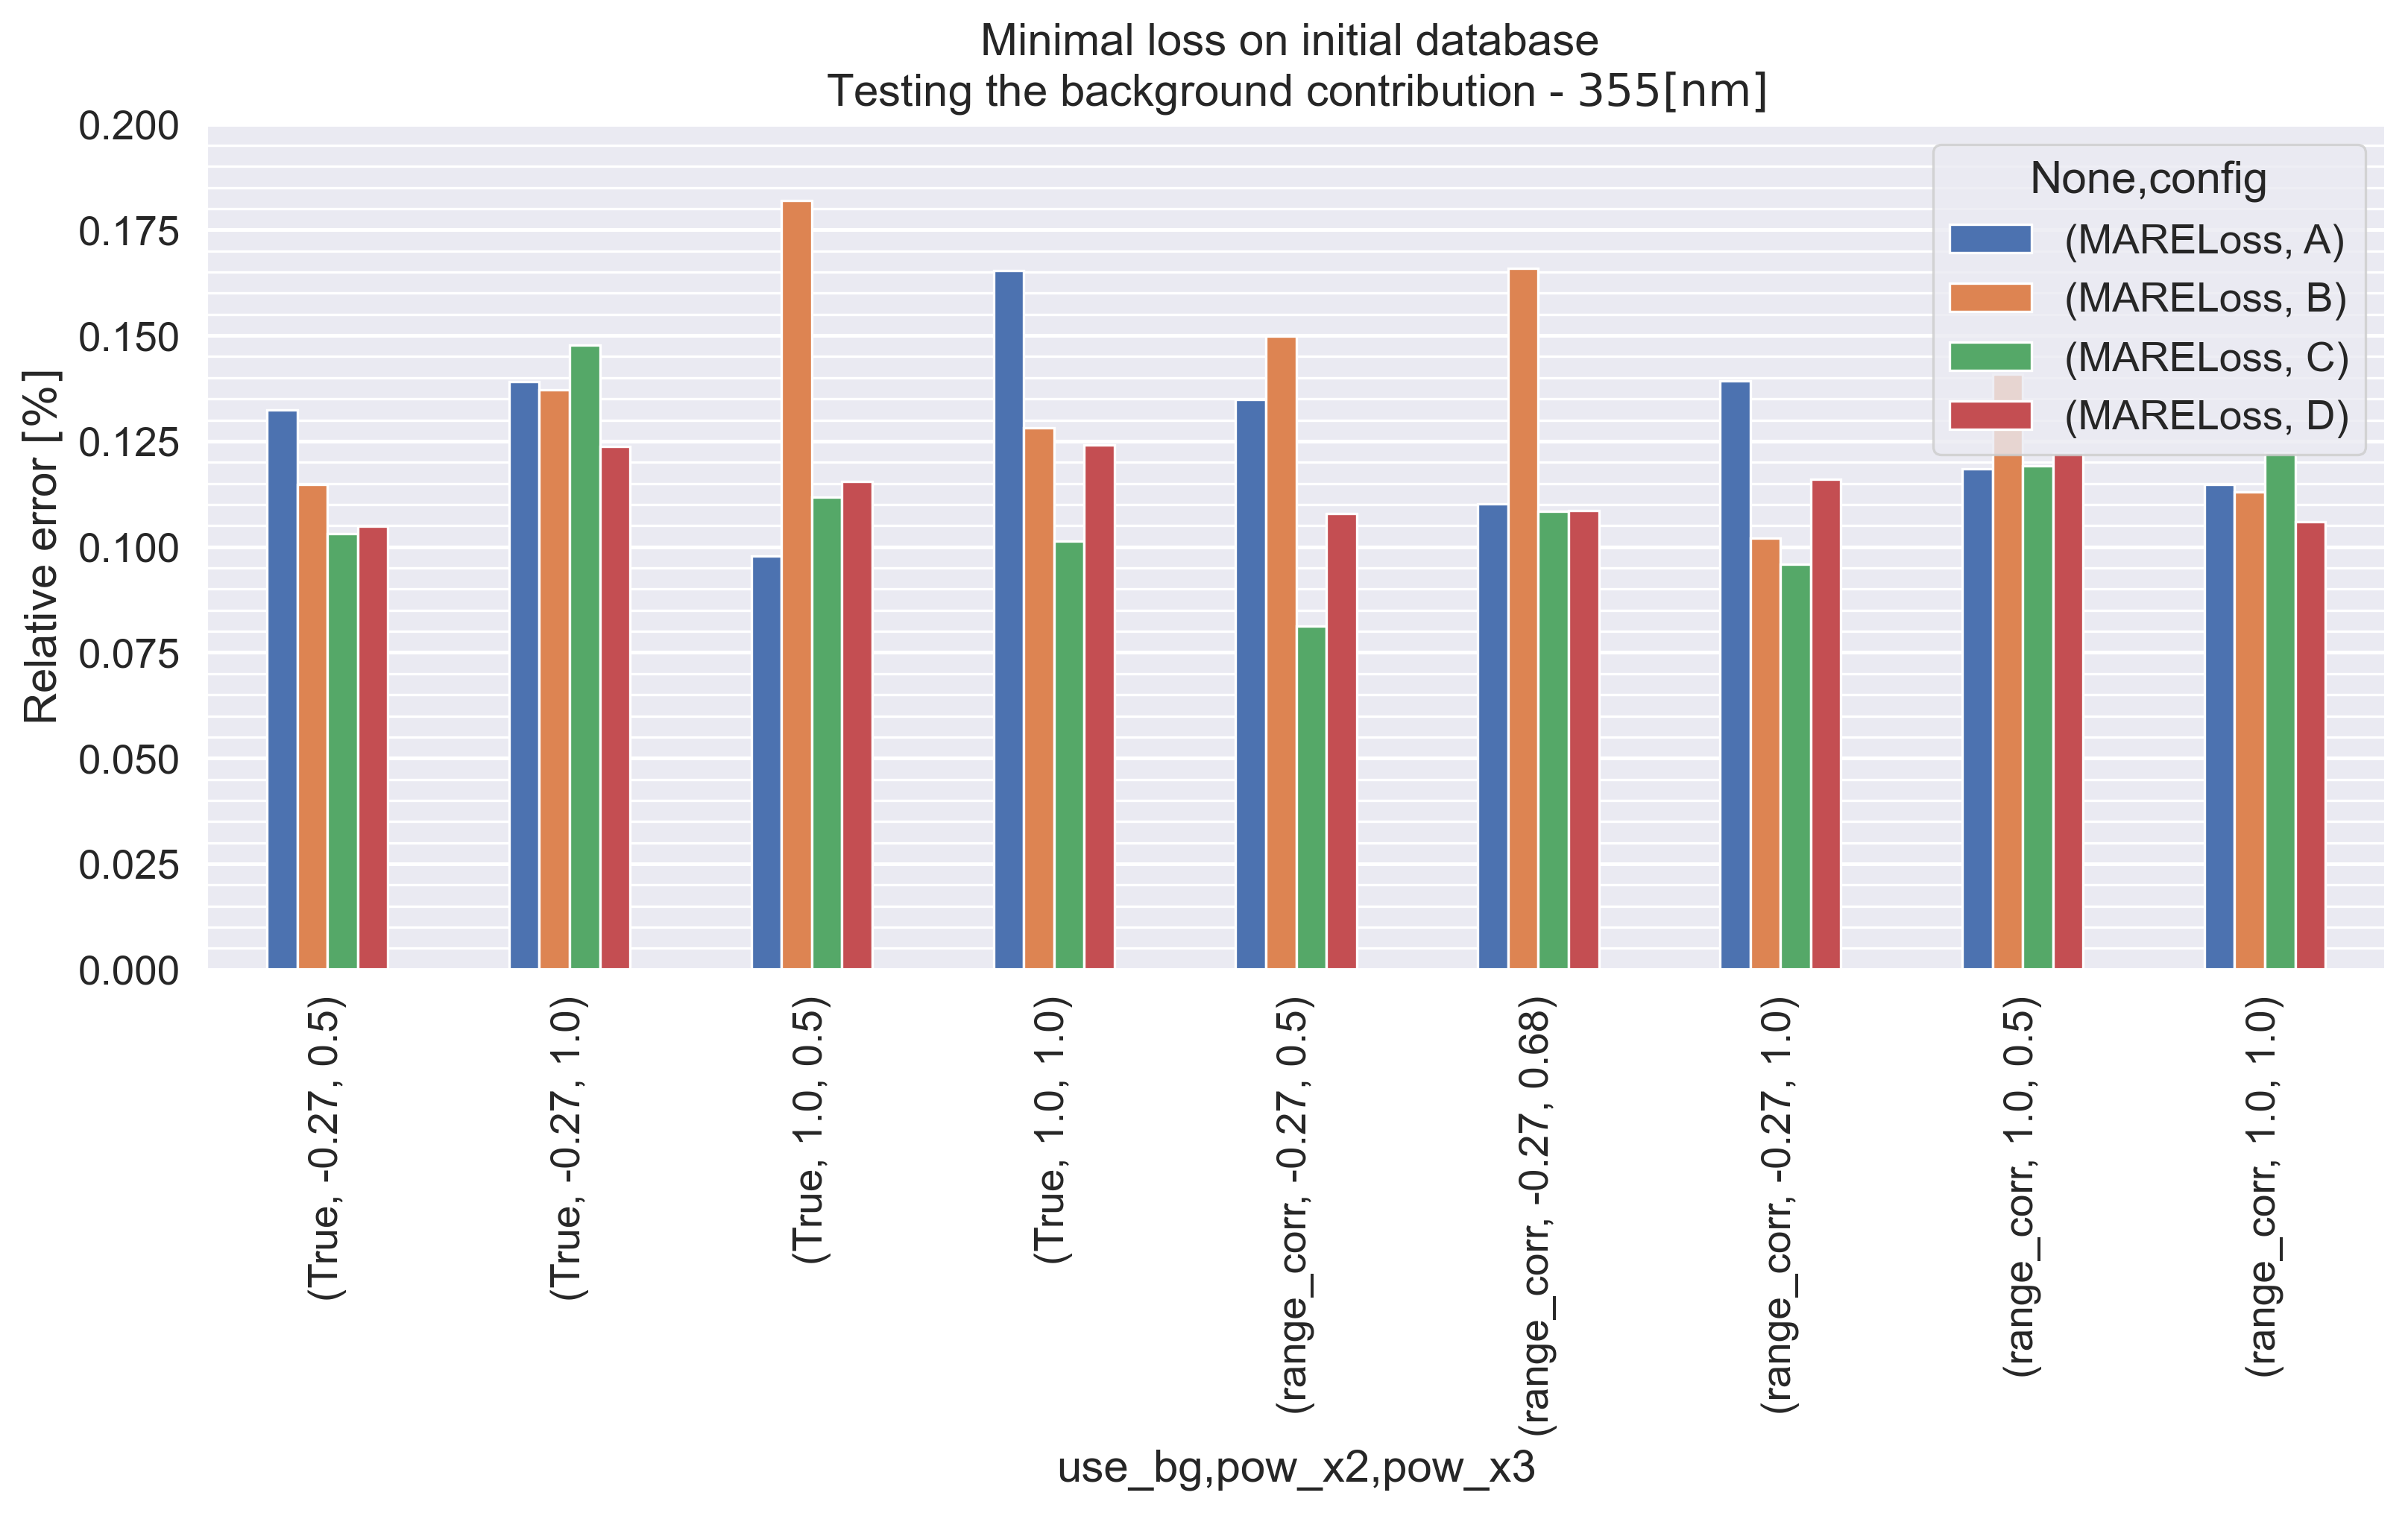

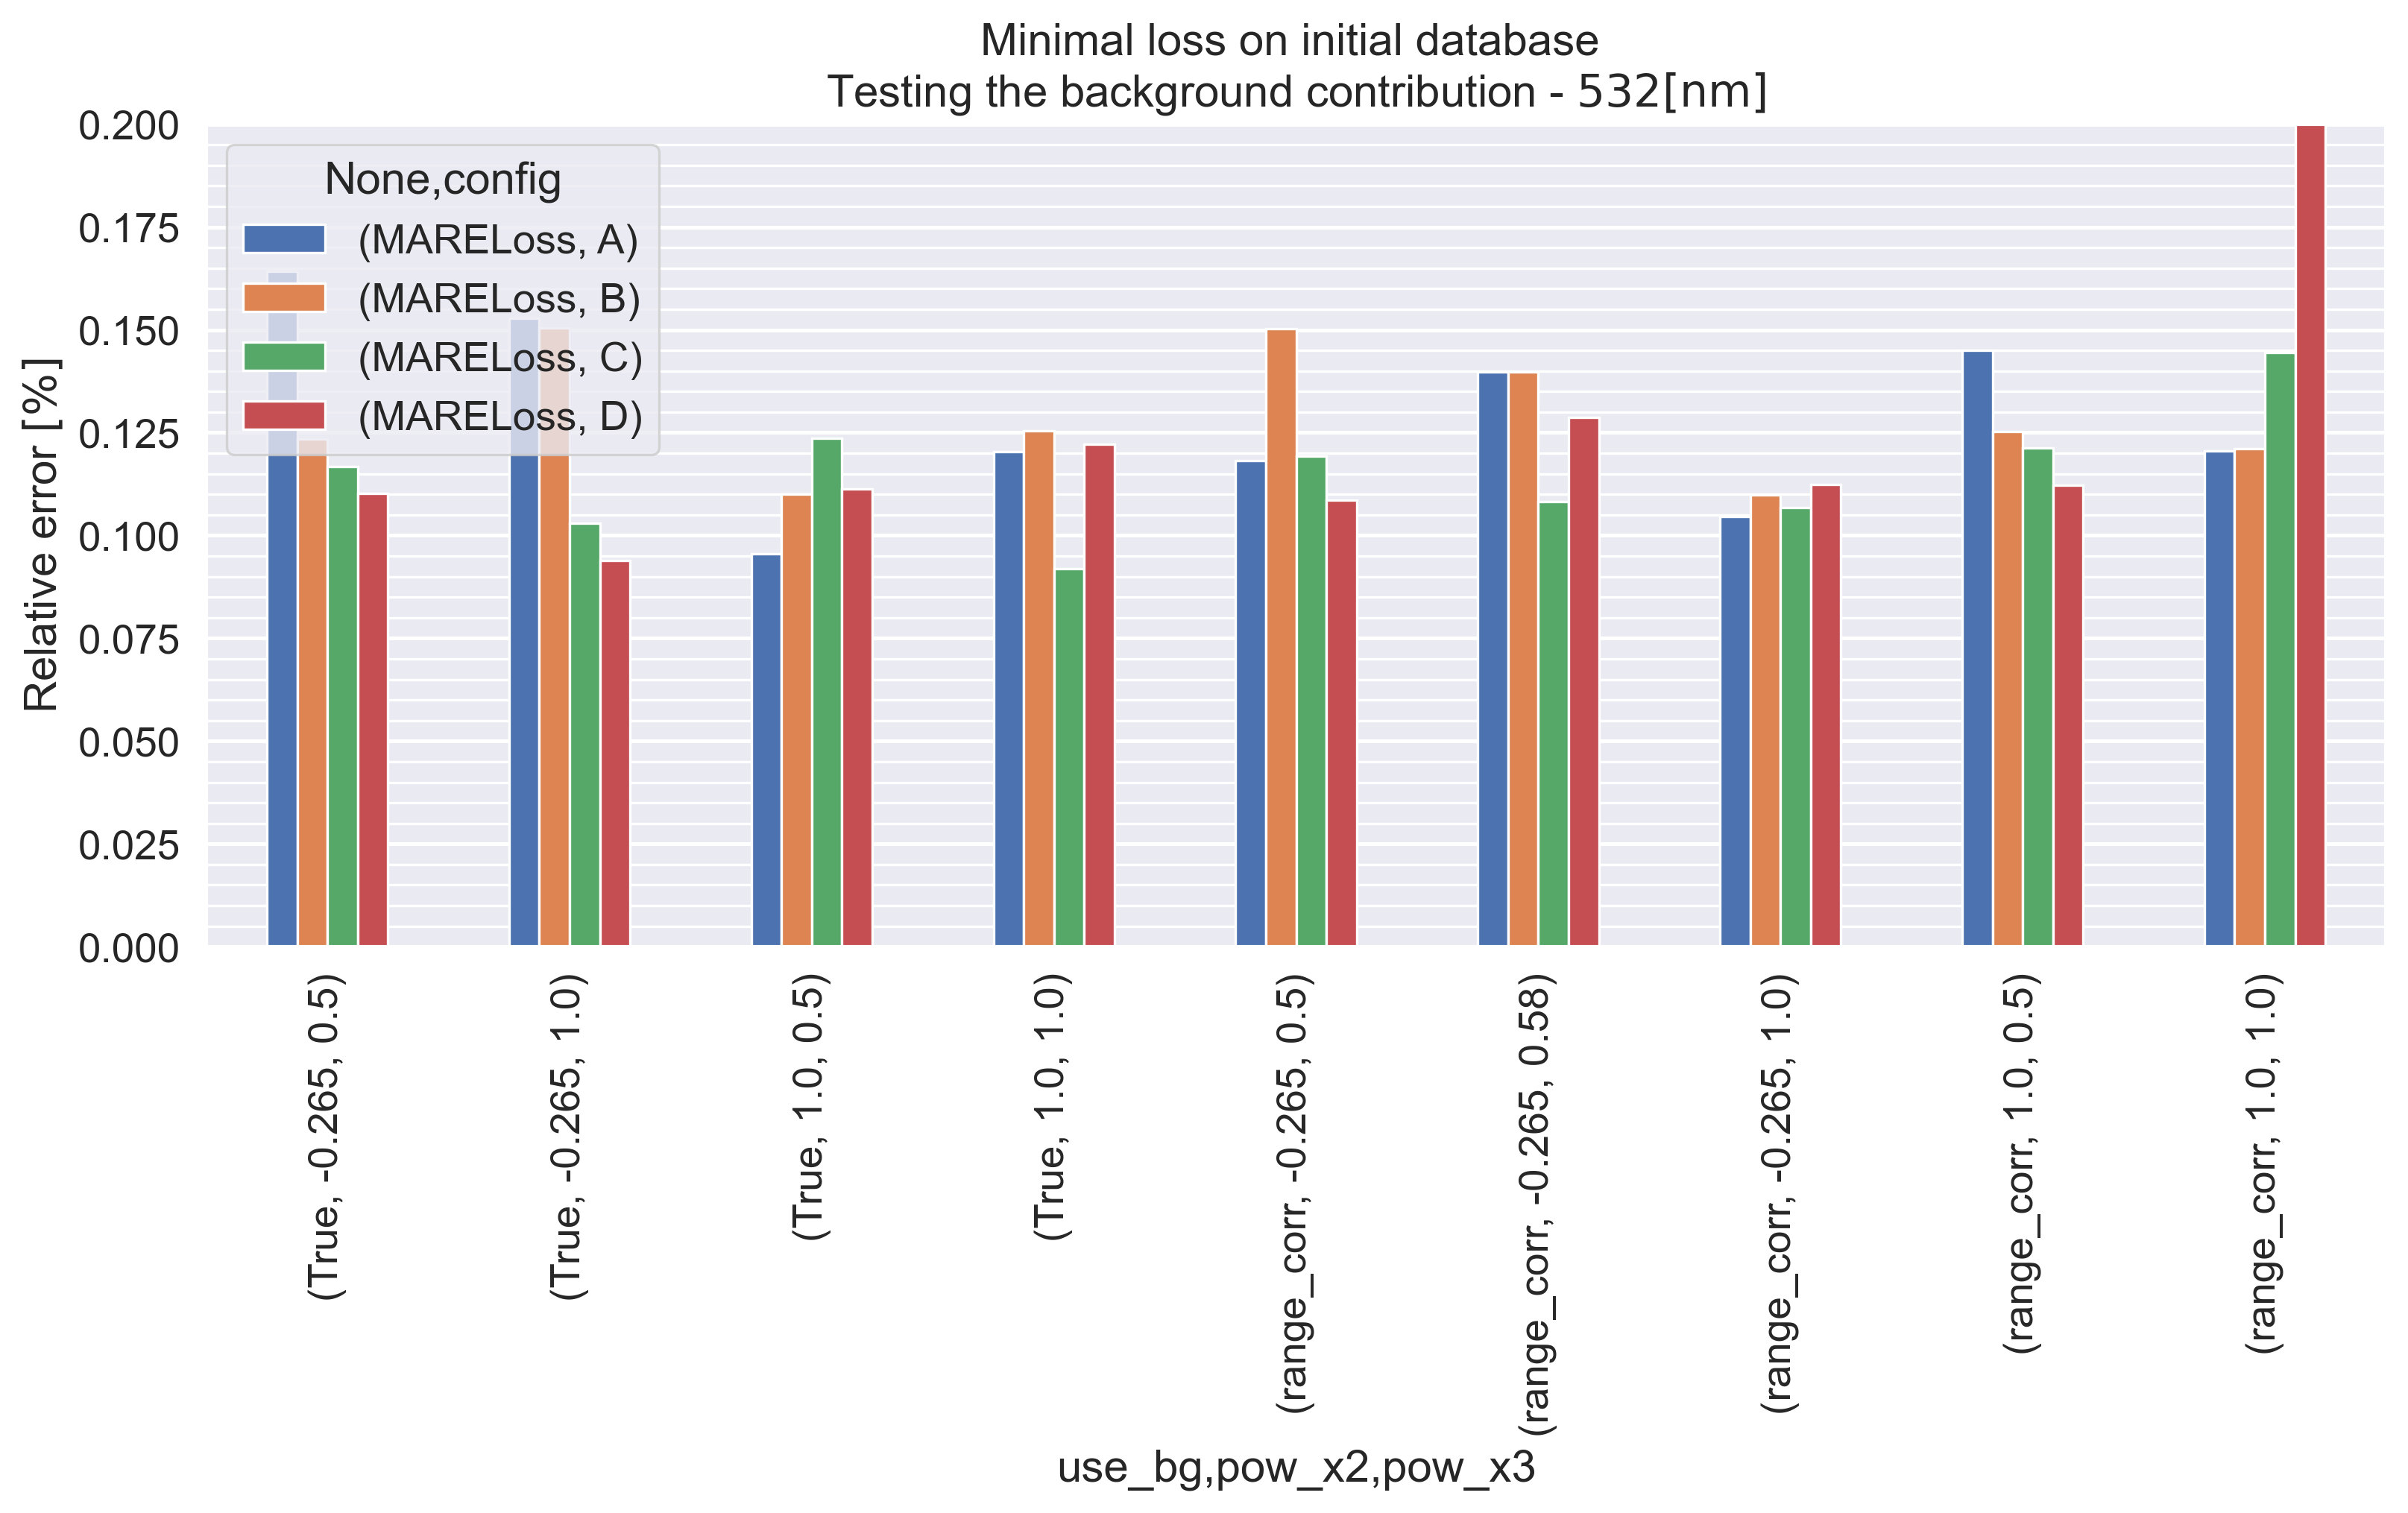

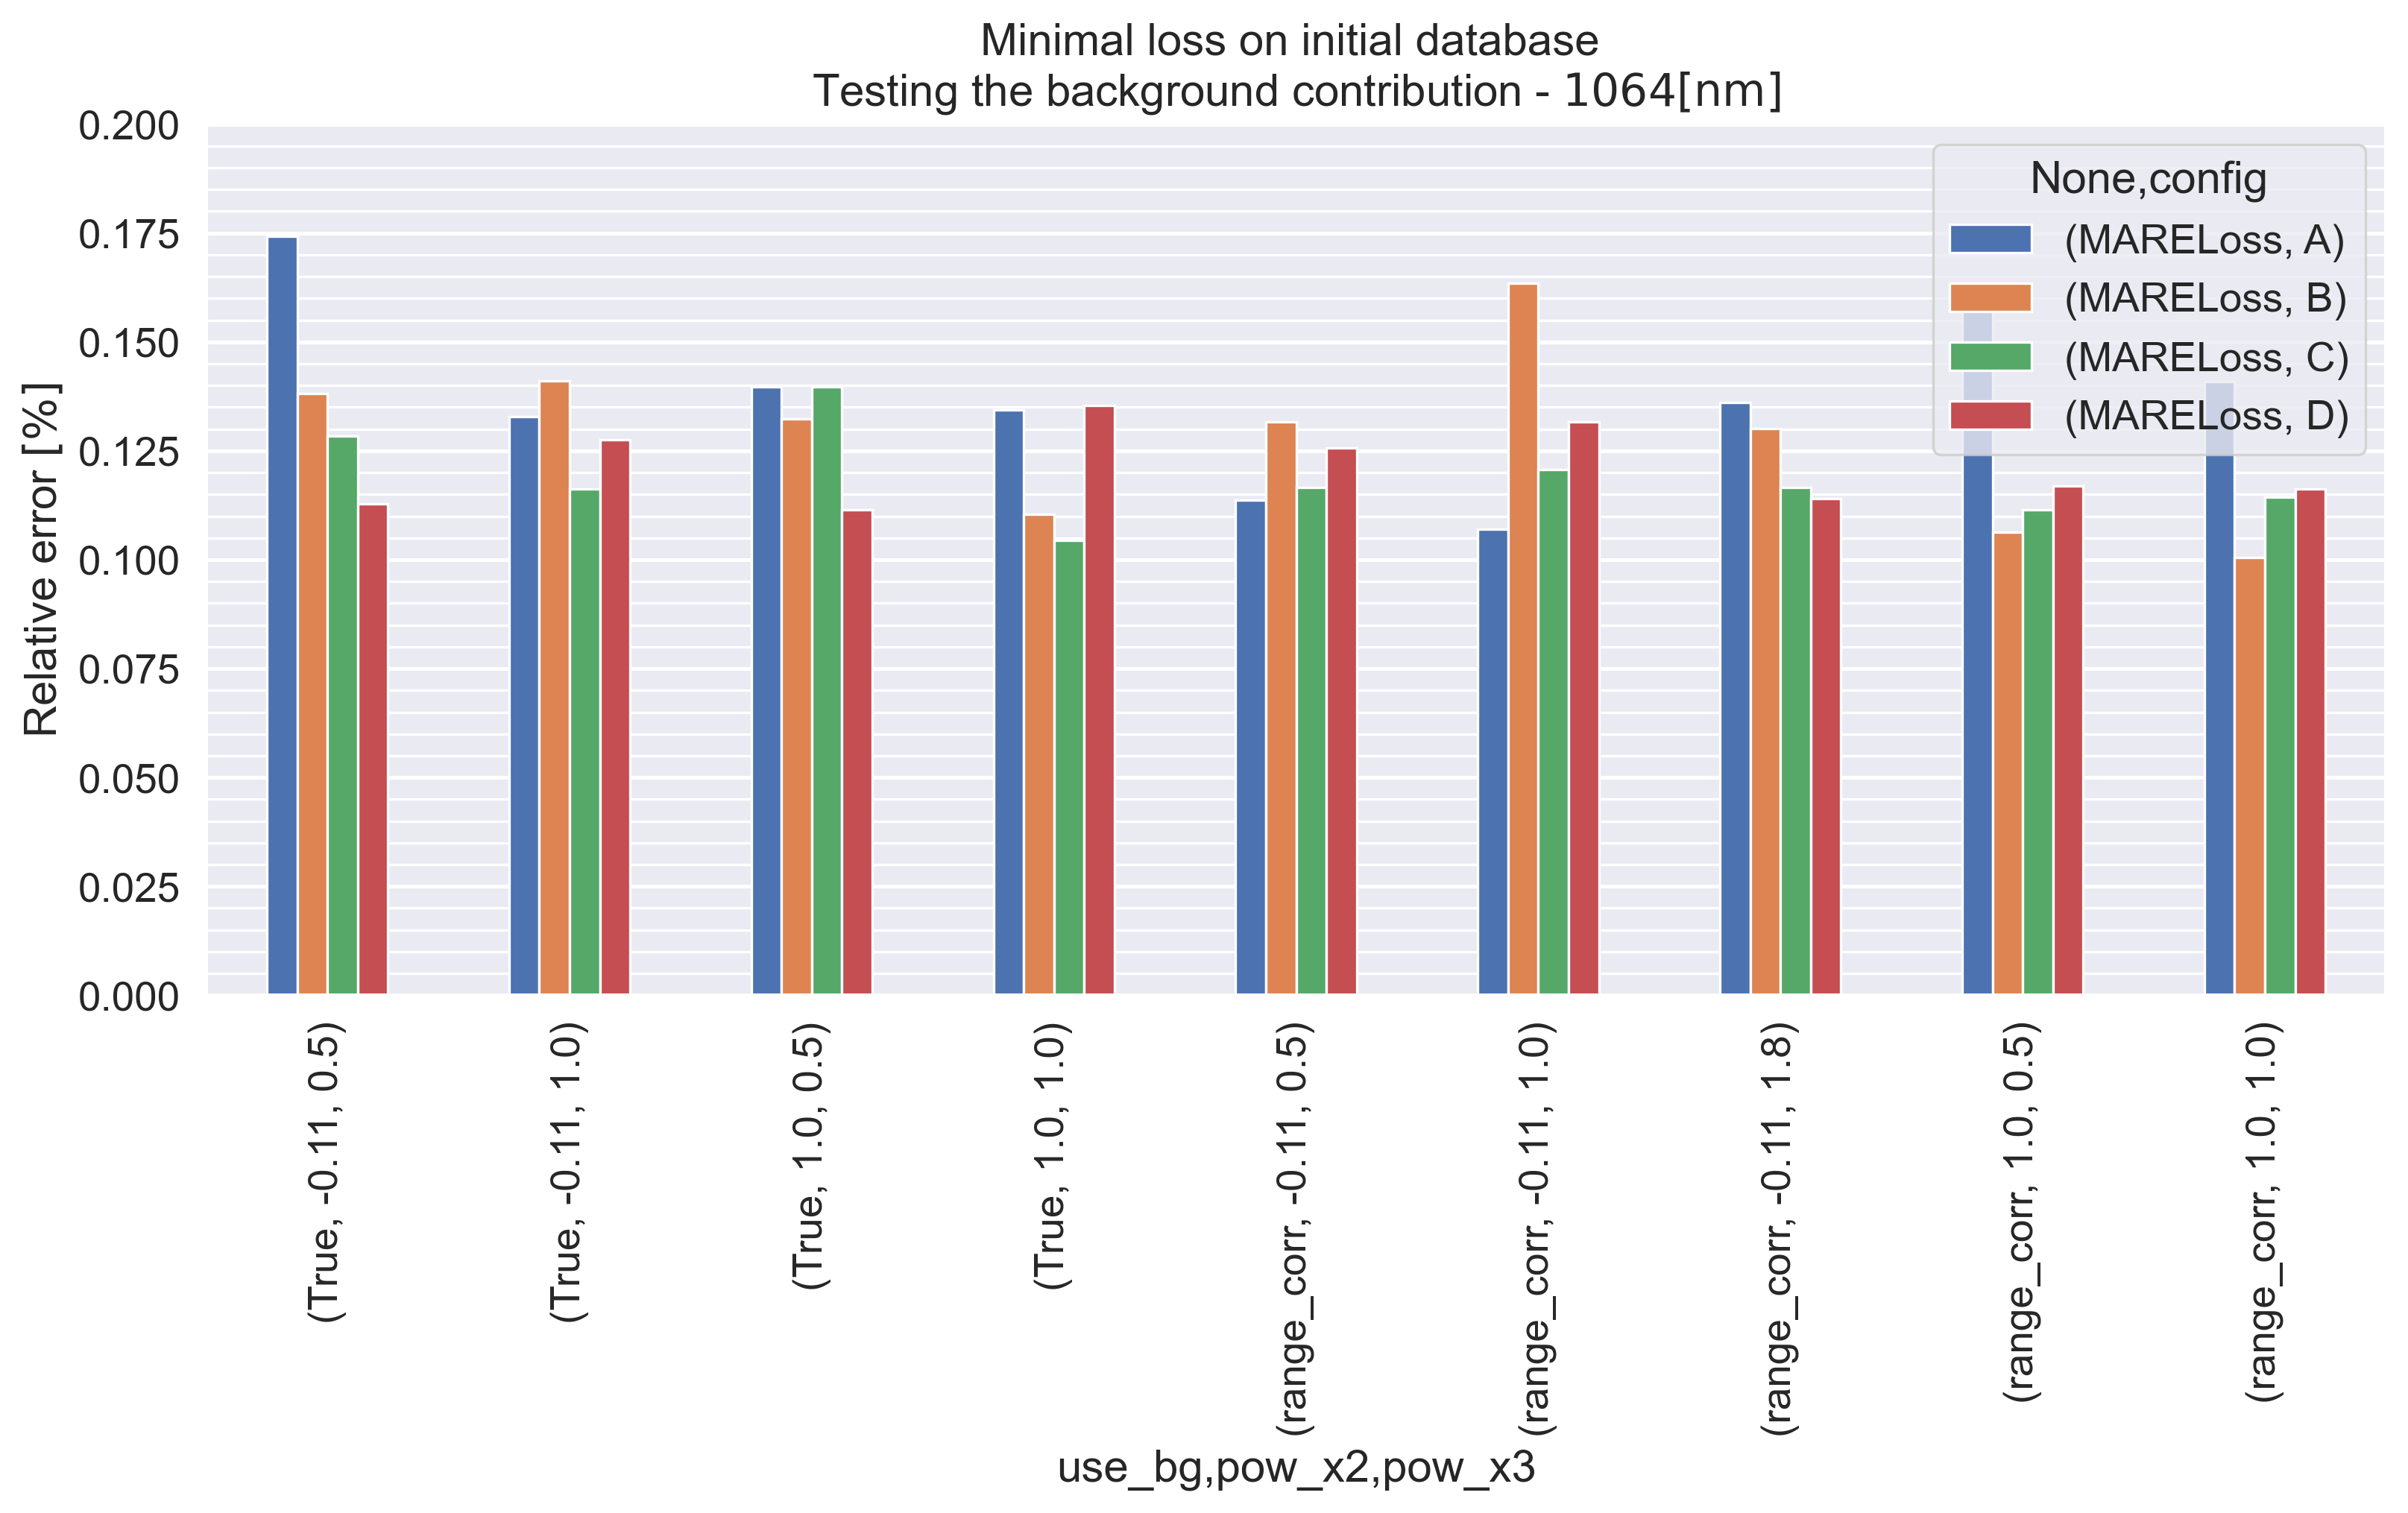

In [73]:
#wavelength =532
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

    pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'pow_x2','pow_x3'],
                   aggfunc=np.min).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on initial database \n'+fr'Testing the background contribution - ${wavelength}[\rm nm]$')
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    ax.set_ylim([0.0, 0.2])
    plt.tight_layout()
    plt.show()

<ipython-input-74-a5742928cd4f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr']


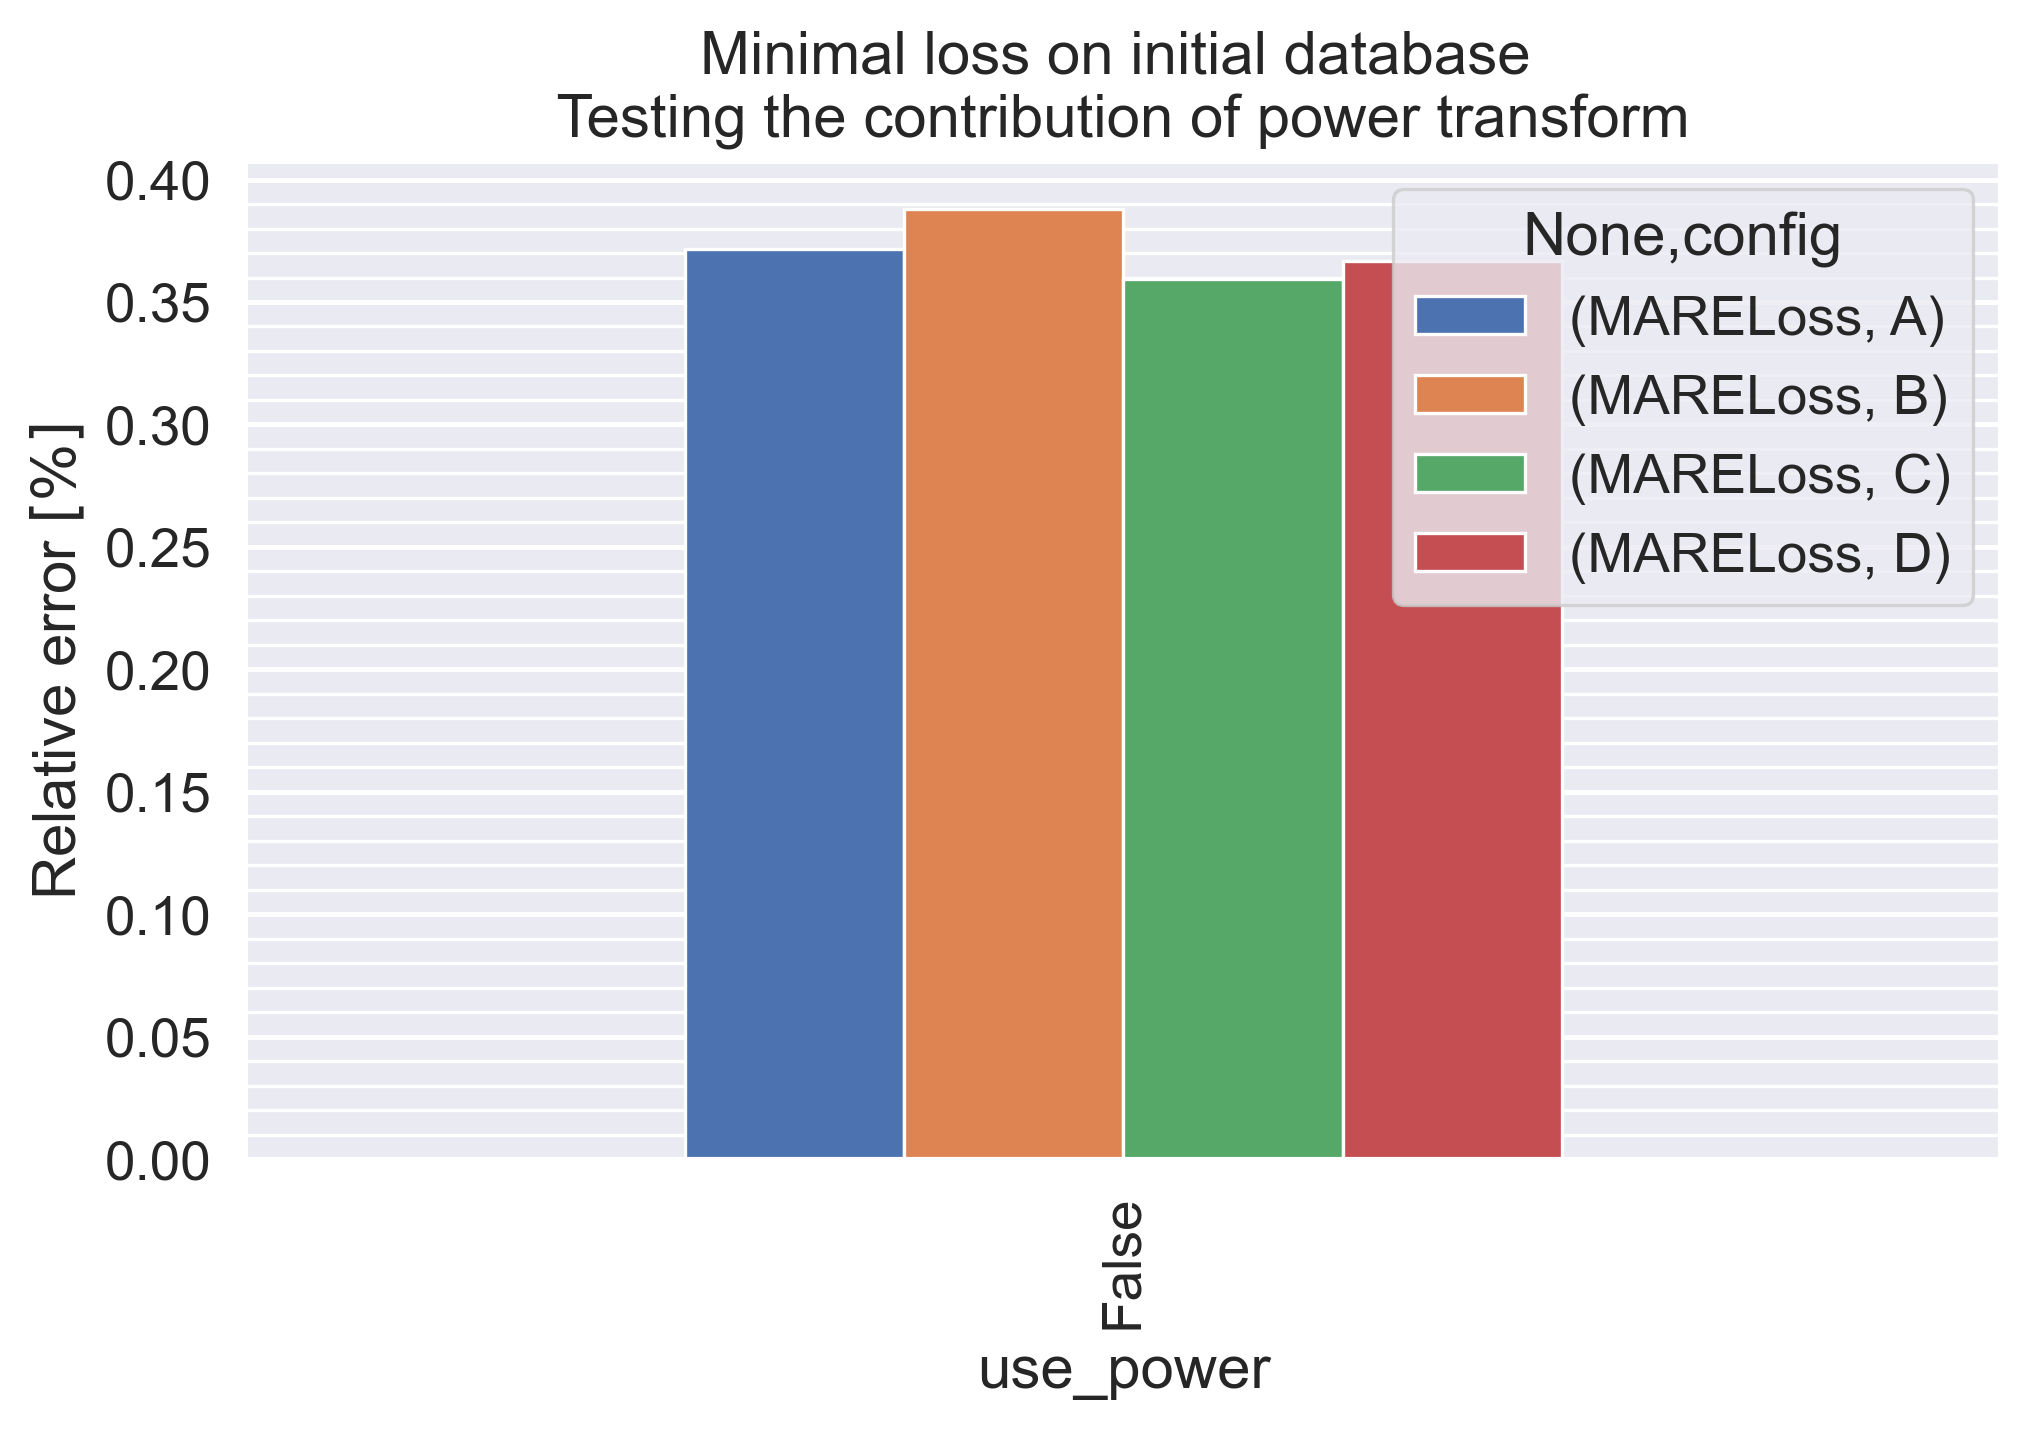

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr']
               [all_wavs_configABCD.note=='extended_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_power'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the contribution of power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-75-94cf29c27284>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


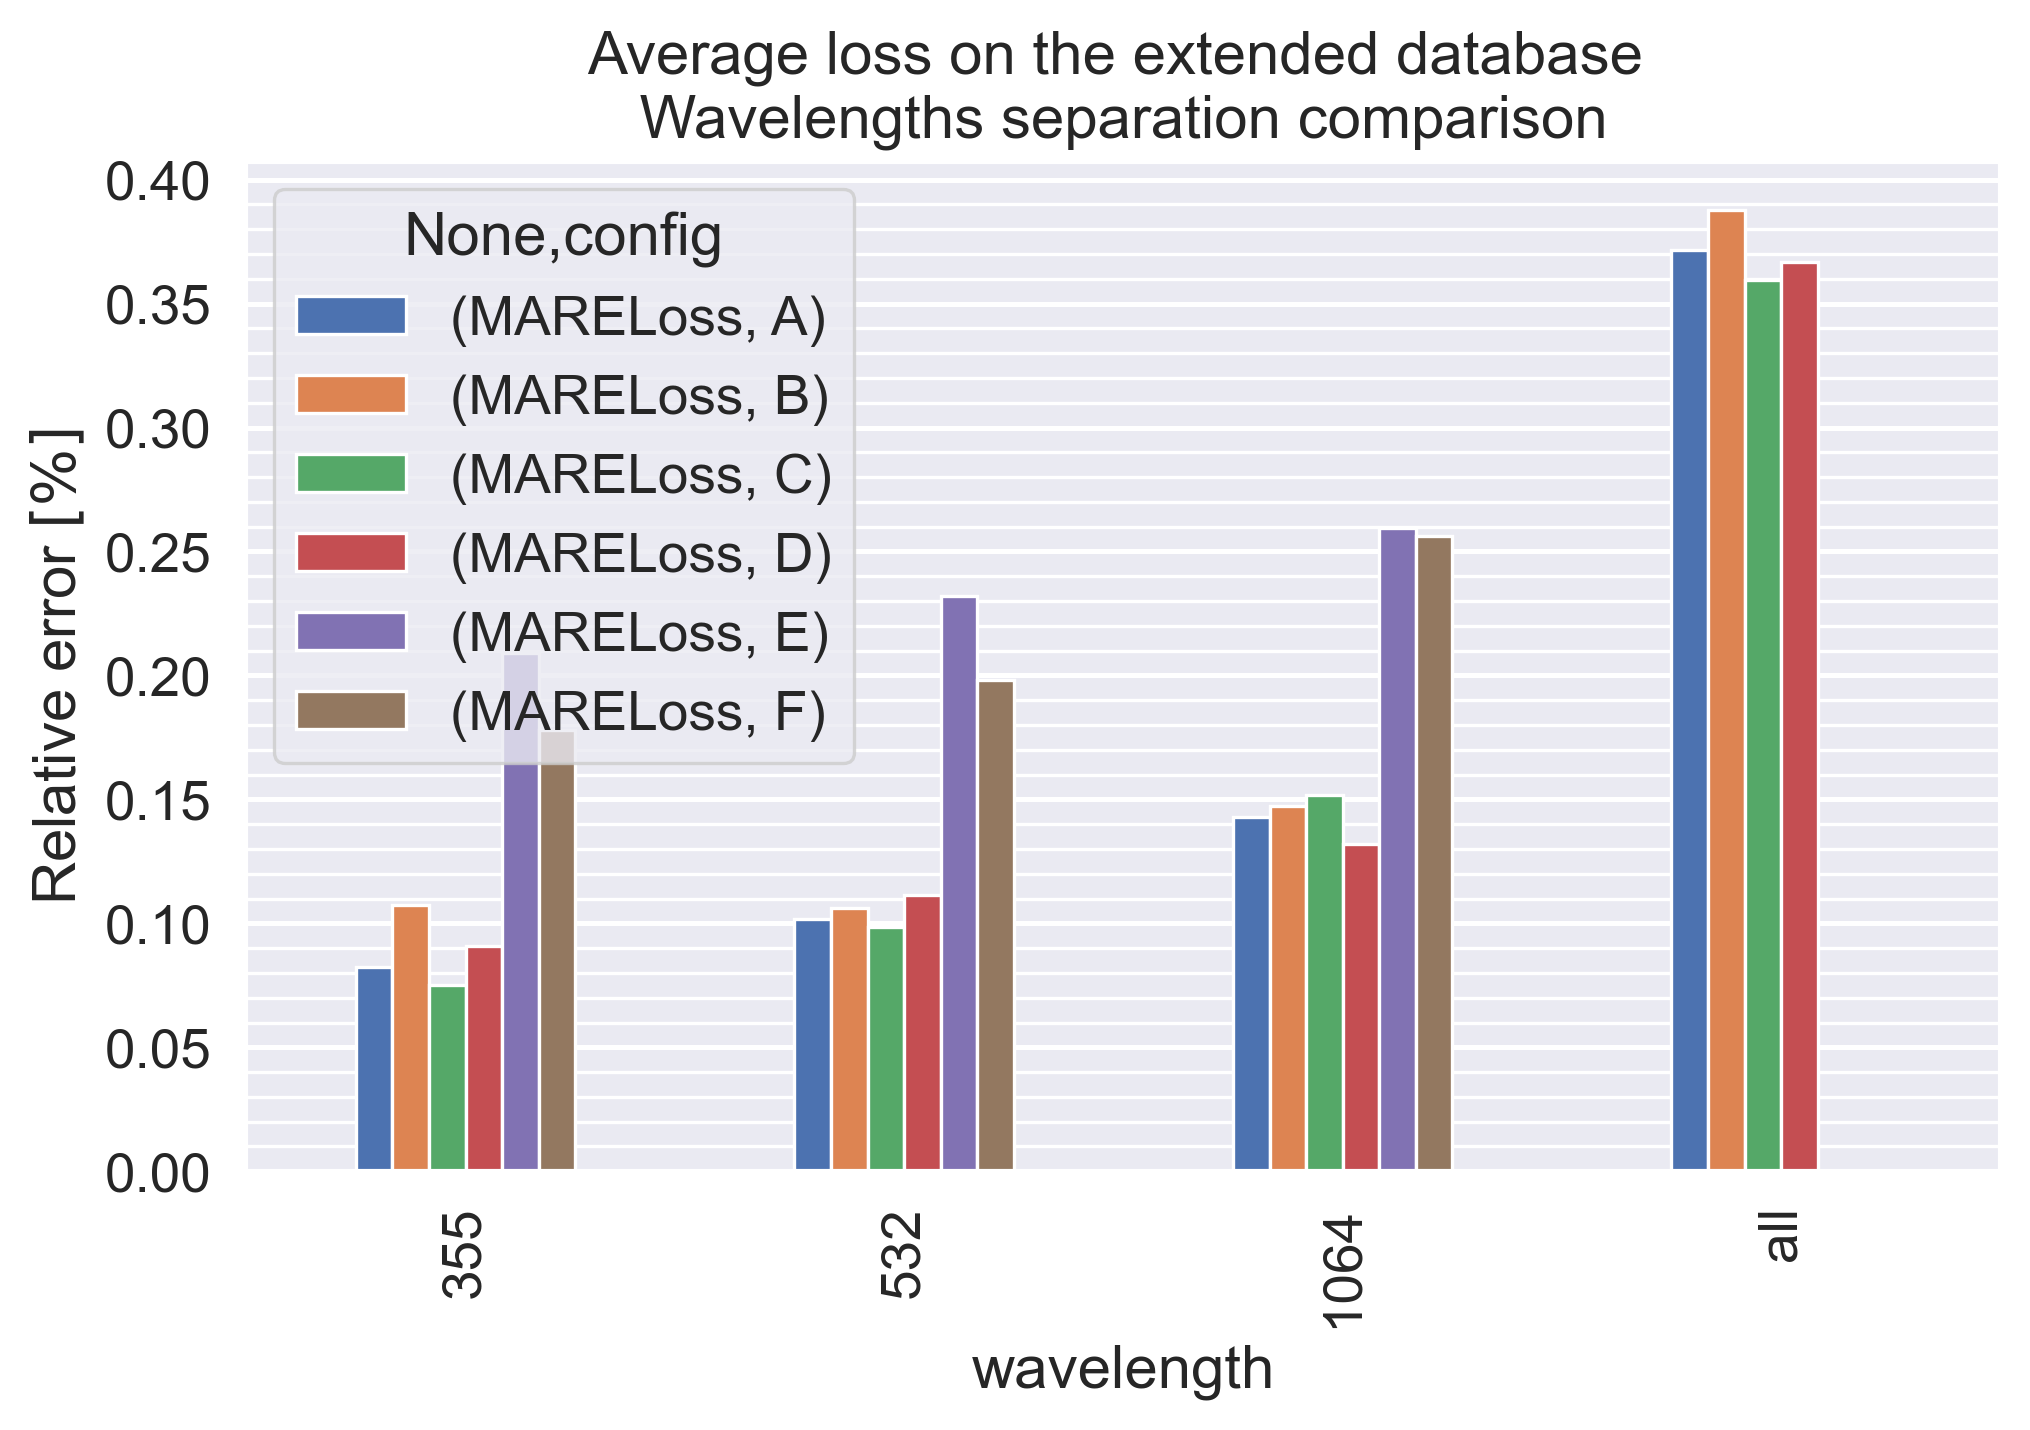

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Average loss on the extended database \n Wavelengths separation comparison ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-76-527ef60f31bd>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='extended_db'],


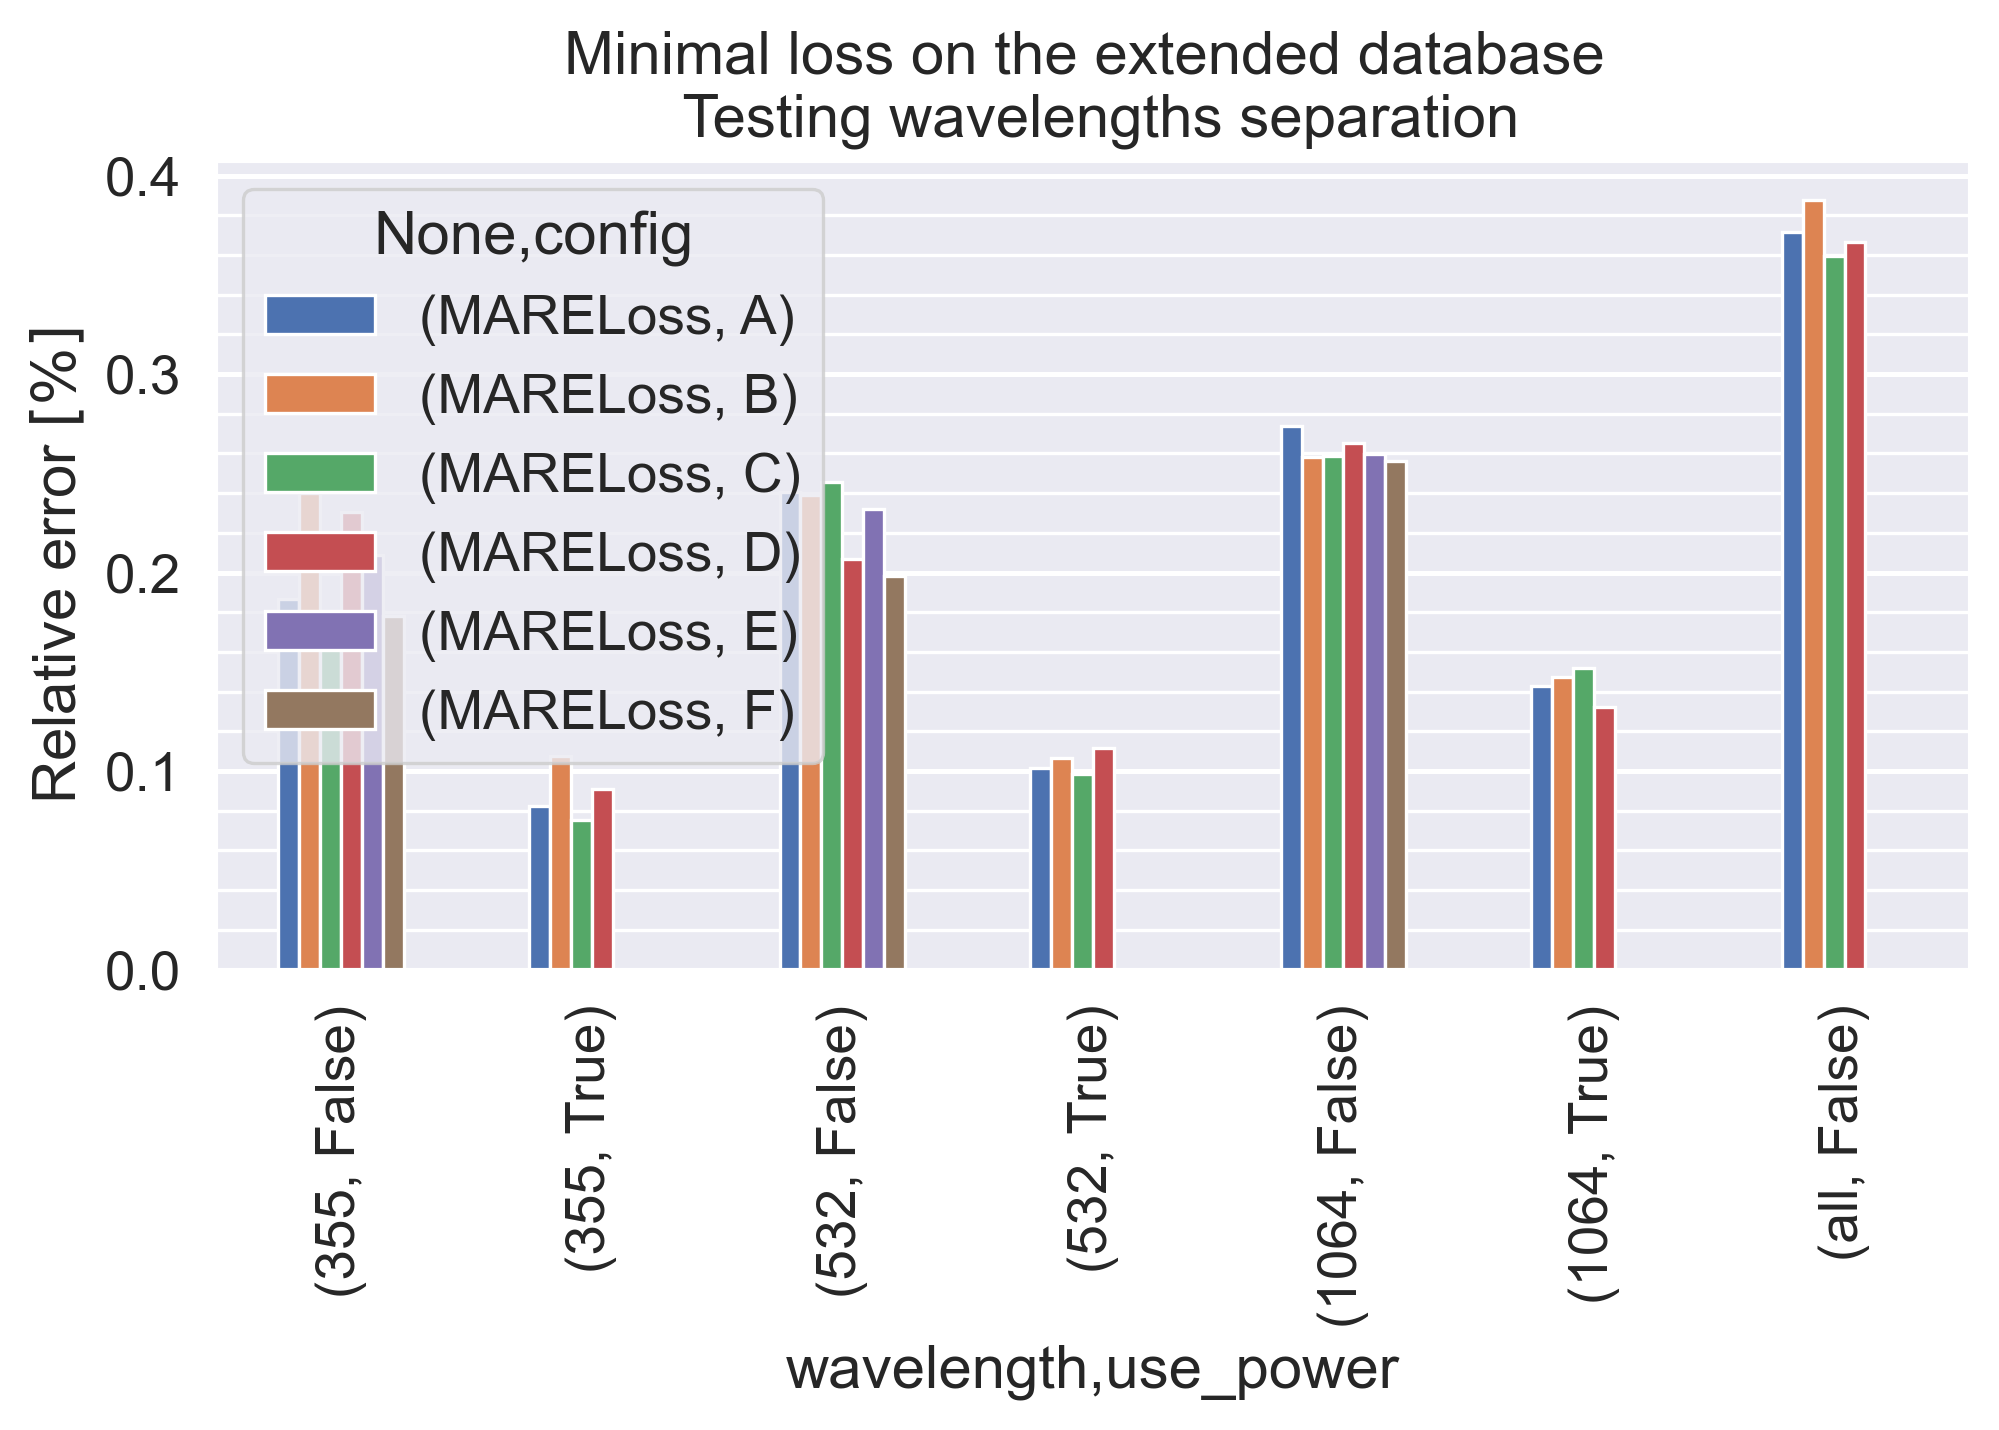

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','use_power'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on the extended database \n Testing wavelengths separation')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-77-1838f254c99e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


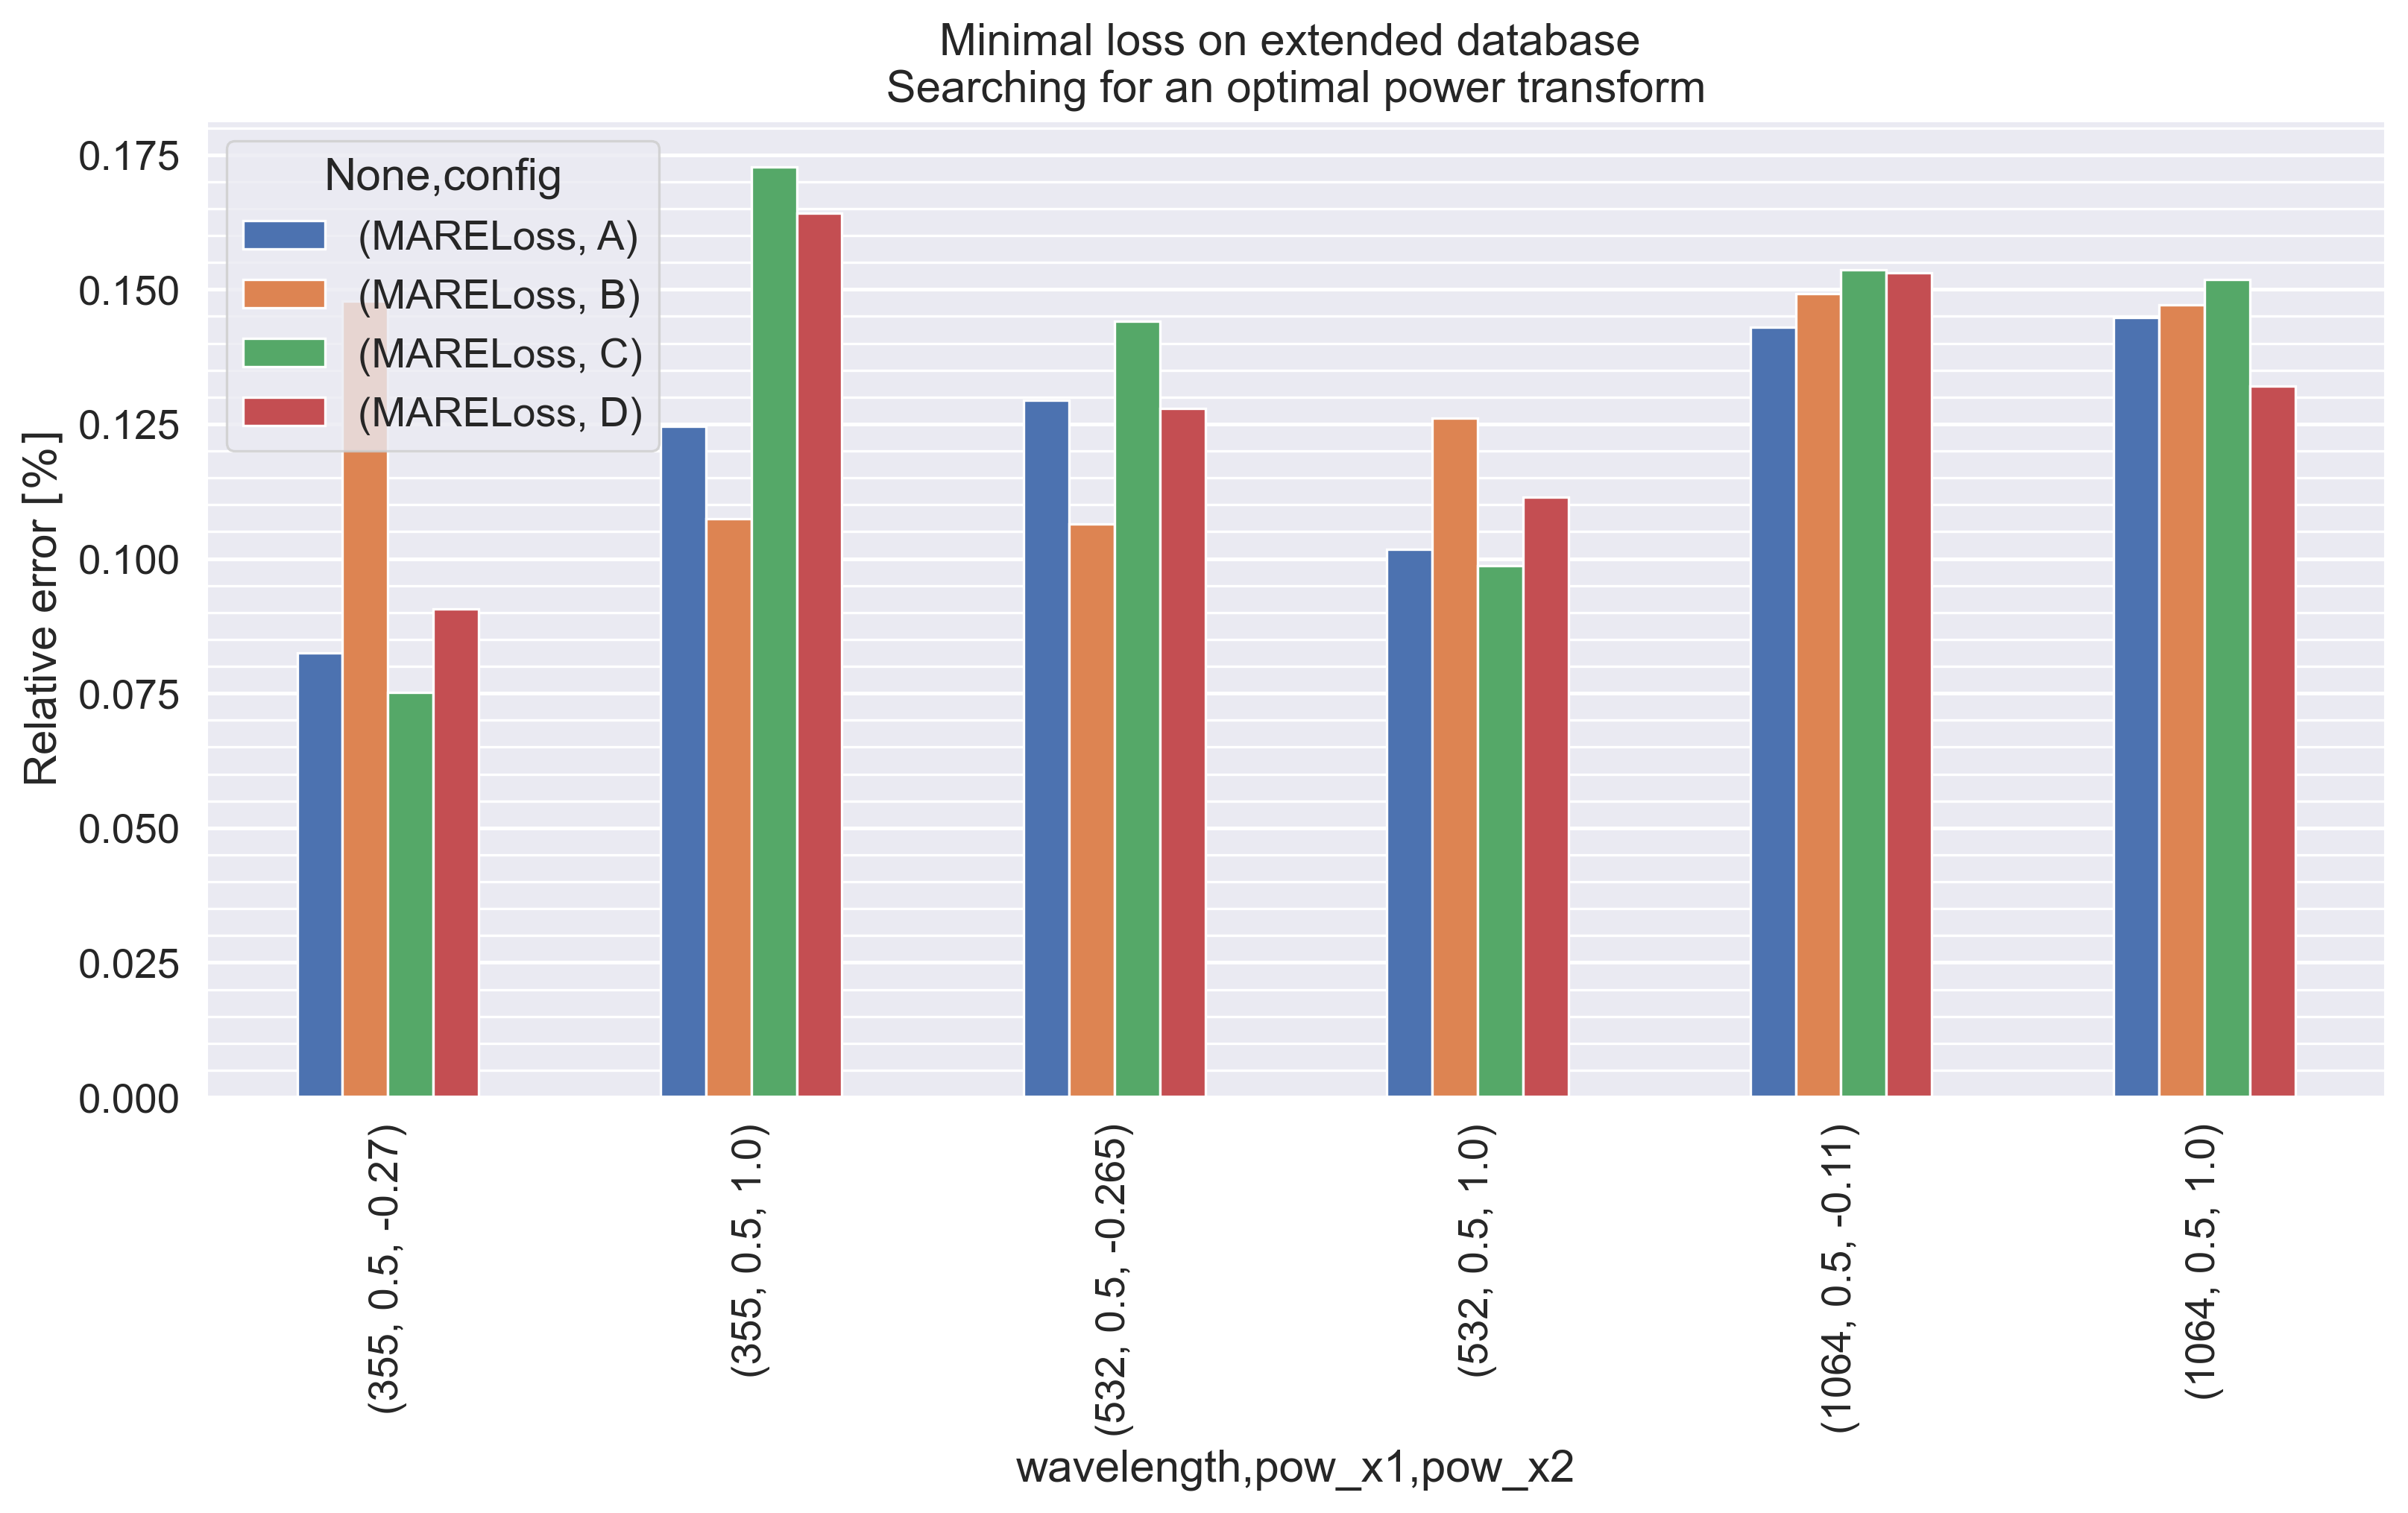

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='extended_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x1','pow_x2'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on extended database \n Searching for an optimal power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [78]:
all_wavs_configABCD[all_wavs_configABCD.wavelength==532][all_wavs_configABCD.use_bg==False].note

<ipython-input-78-88fa8e8ae773>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_wavs_configABCD[all_wavs_configABCD.wavelength==532][all_wavs_configABCD.use_bg==False].note


305     initial_db
306     initial_db
307     initial_db
308     initial_db
310     initial_db
312     initial_db
313     initial_db
314     initial_db
456    extended_db
457    extended_db
458    extended_db
459    extended_db
460    extended_db
461    extended_db
462    extended_db
463    extended_db
584     initial_db
589     initial_db
590     initial_db
591     initial_db
608     initial_db
619     initial_db
634    extended_db
637    extended_db
638    extended_db
642    extended_db
644    extended_db
659    extended_db
Name: note, dtype: object

<ipython-input-79-ee92460ba052>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],
<ipython-input-79-ee92460ba052>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],
<ipython-input-79-ee92460ba052>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],


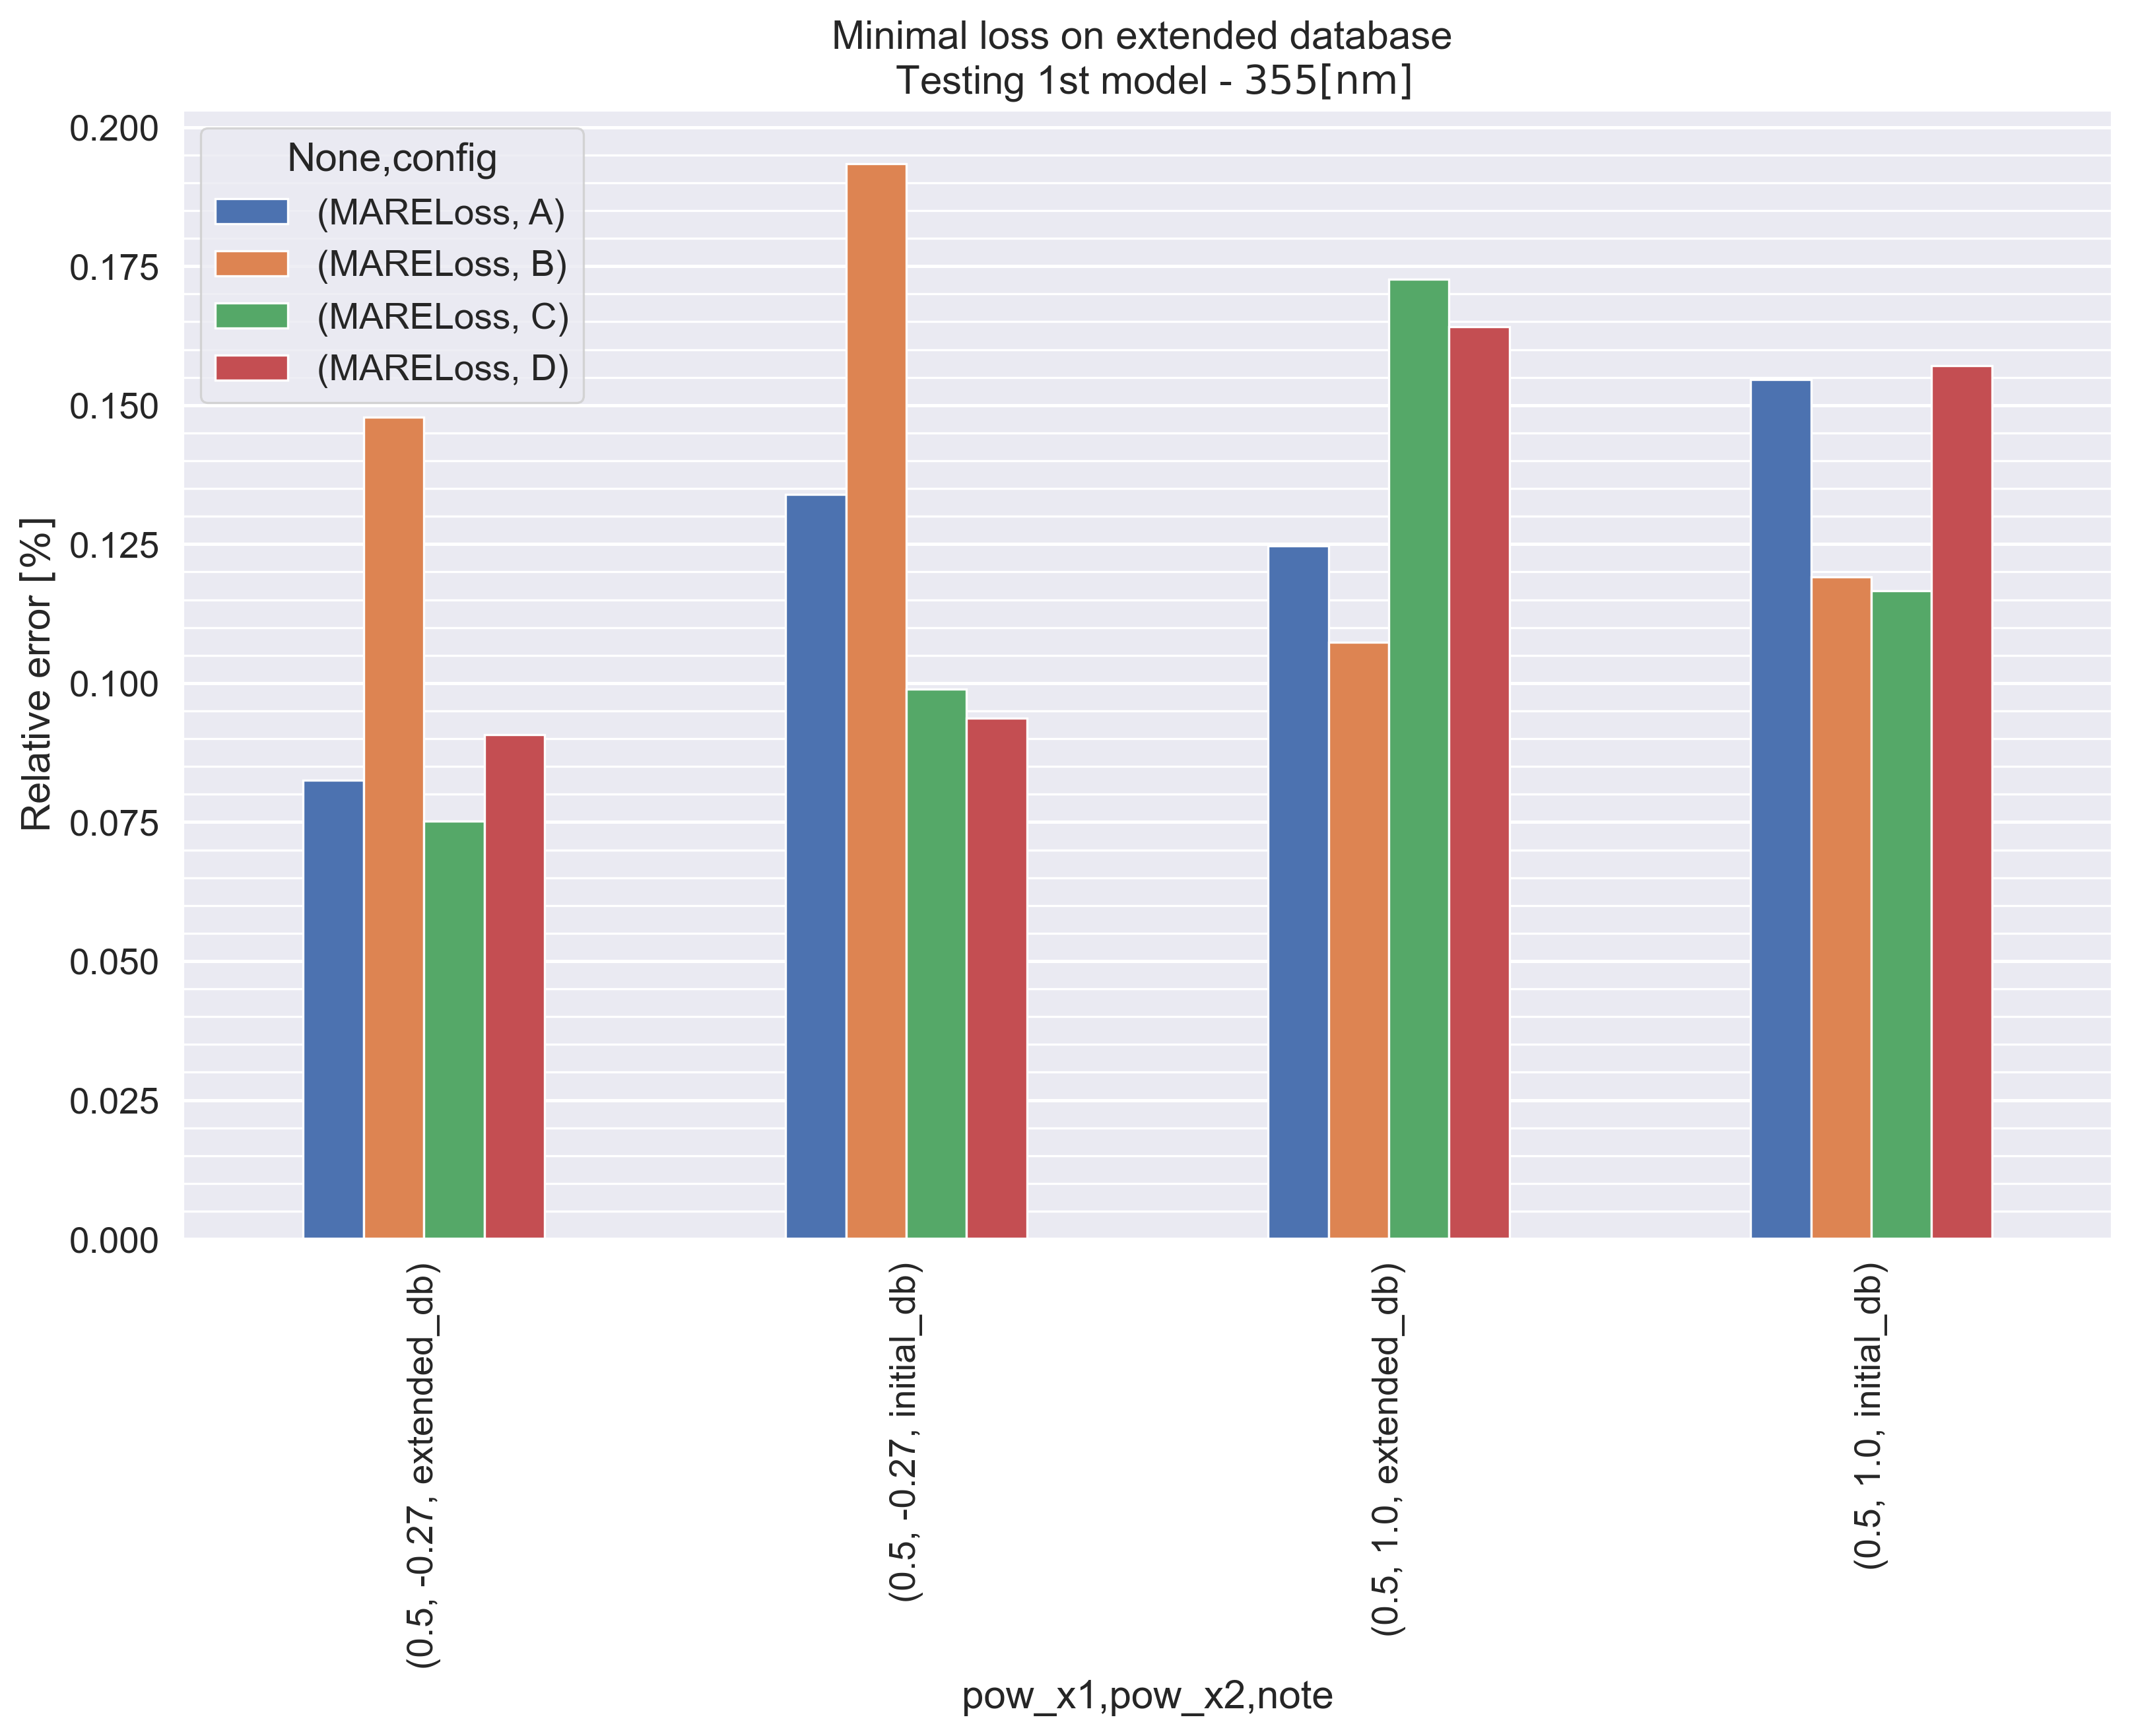

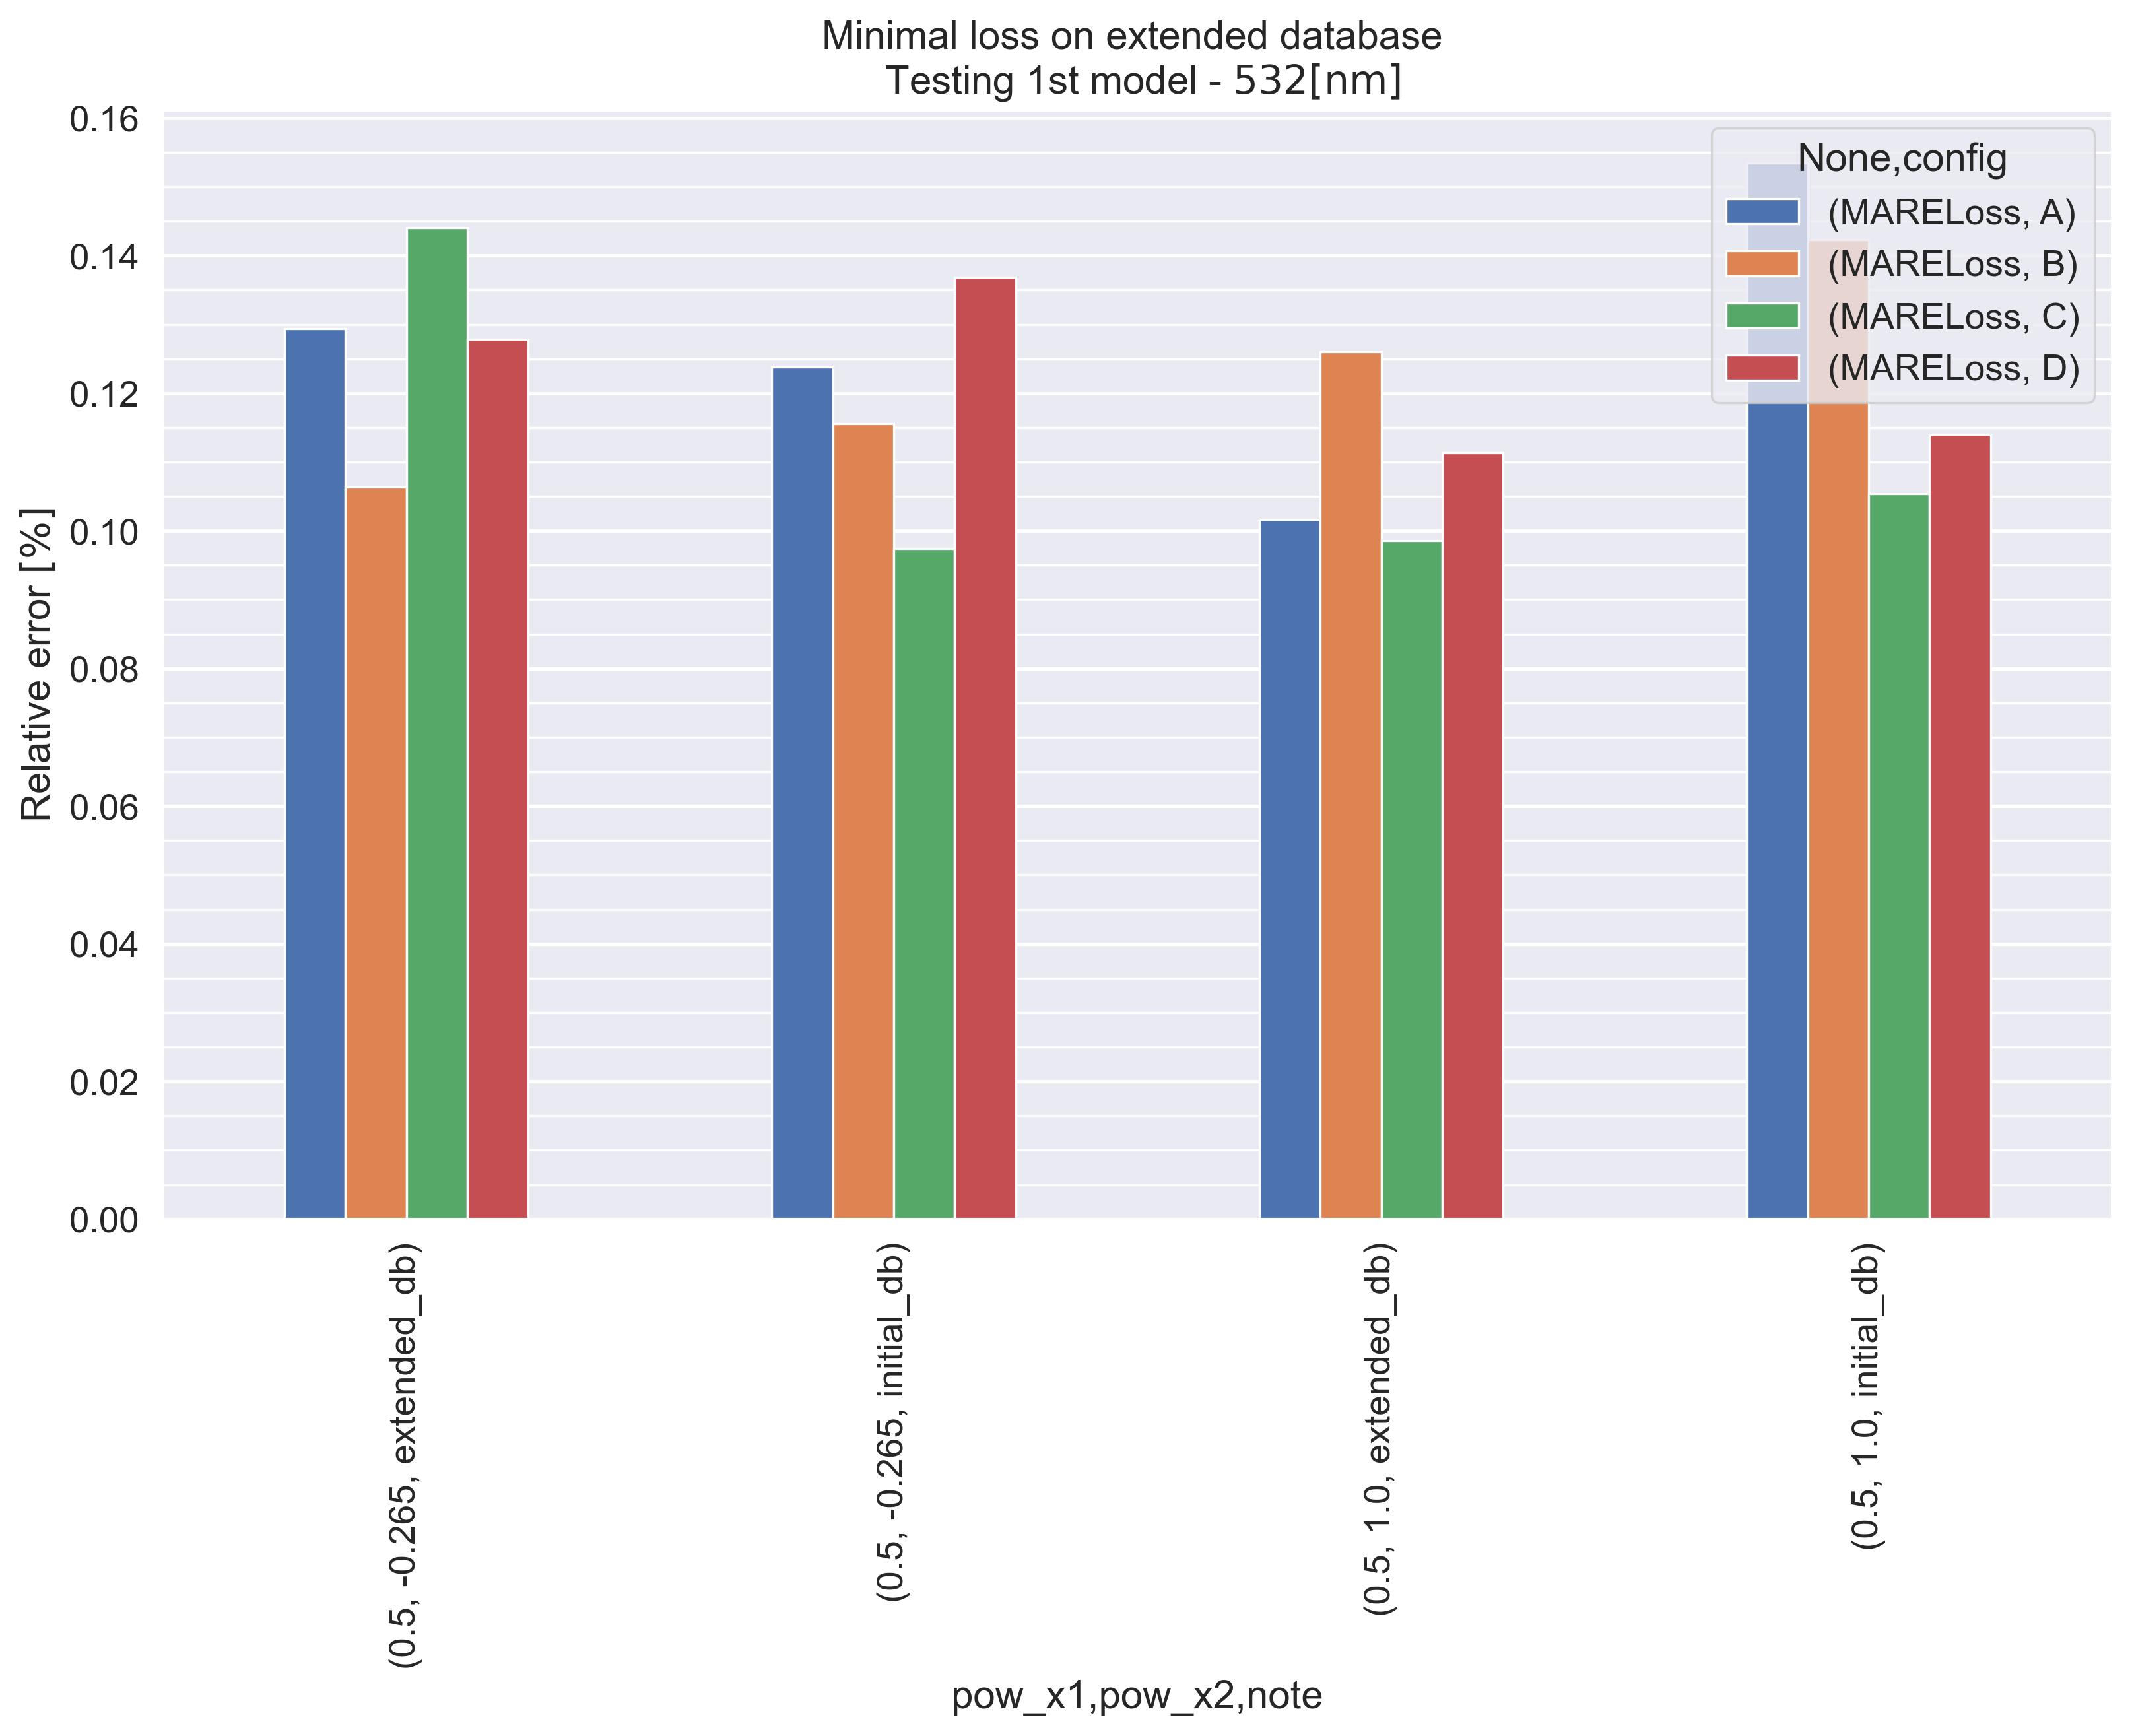

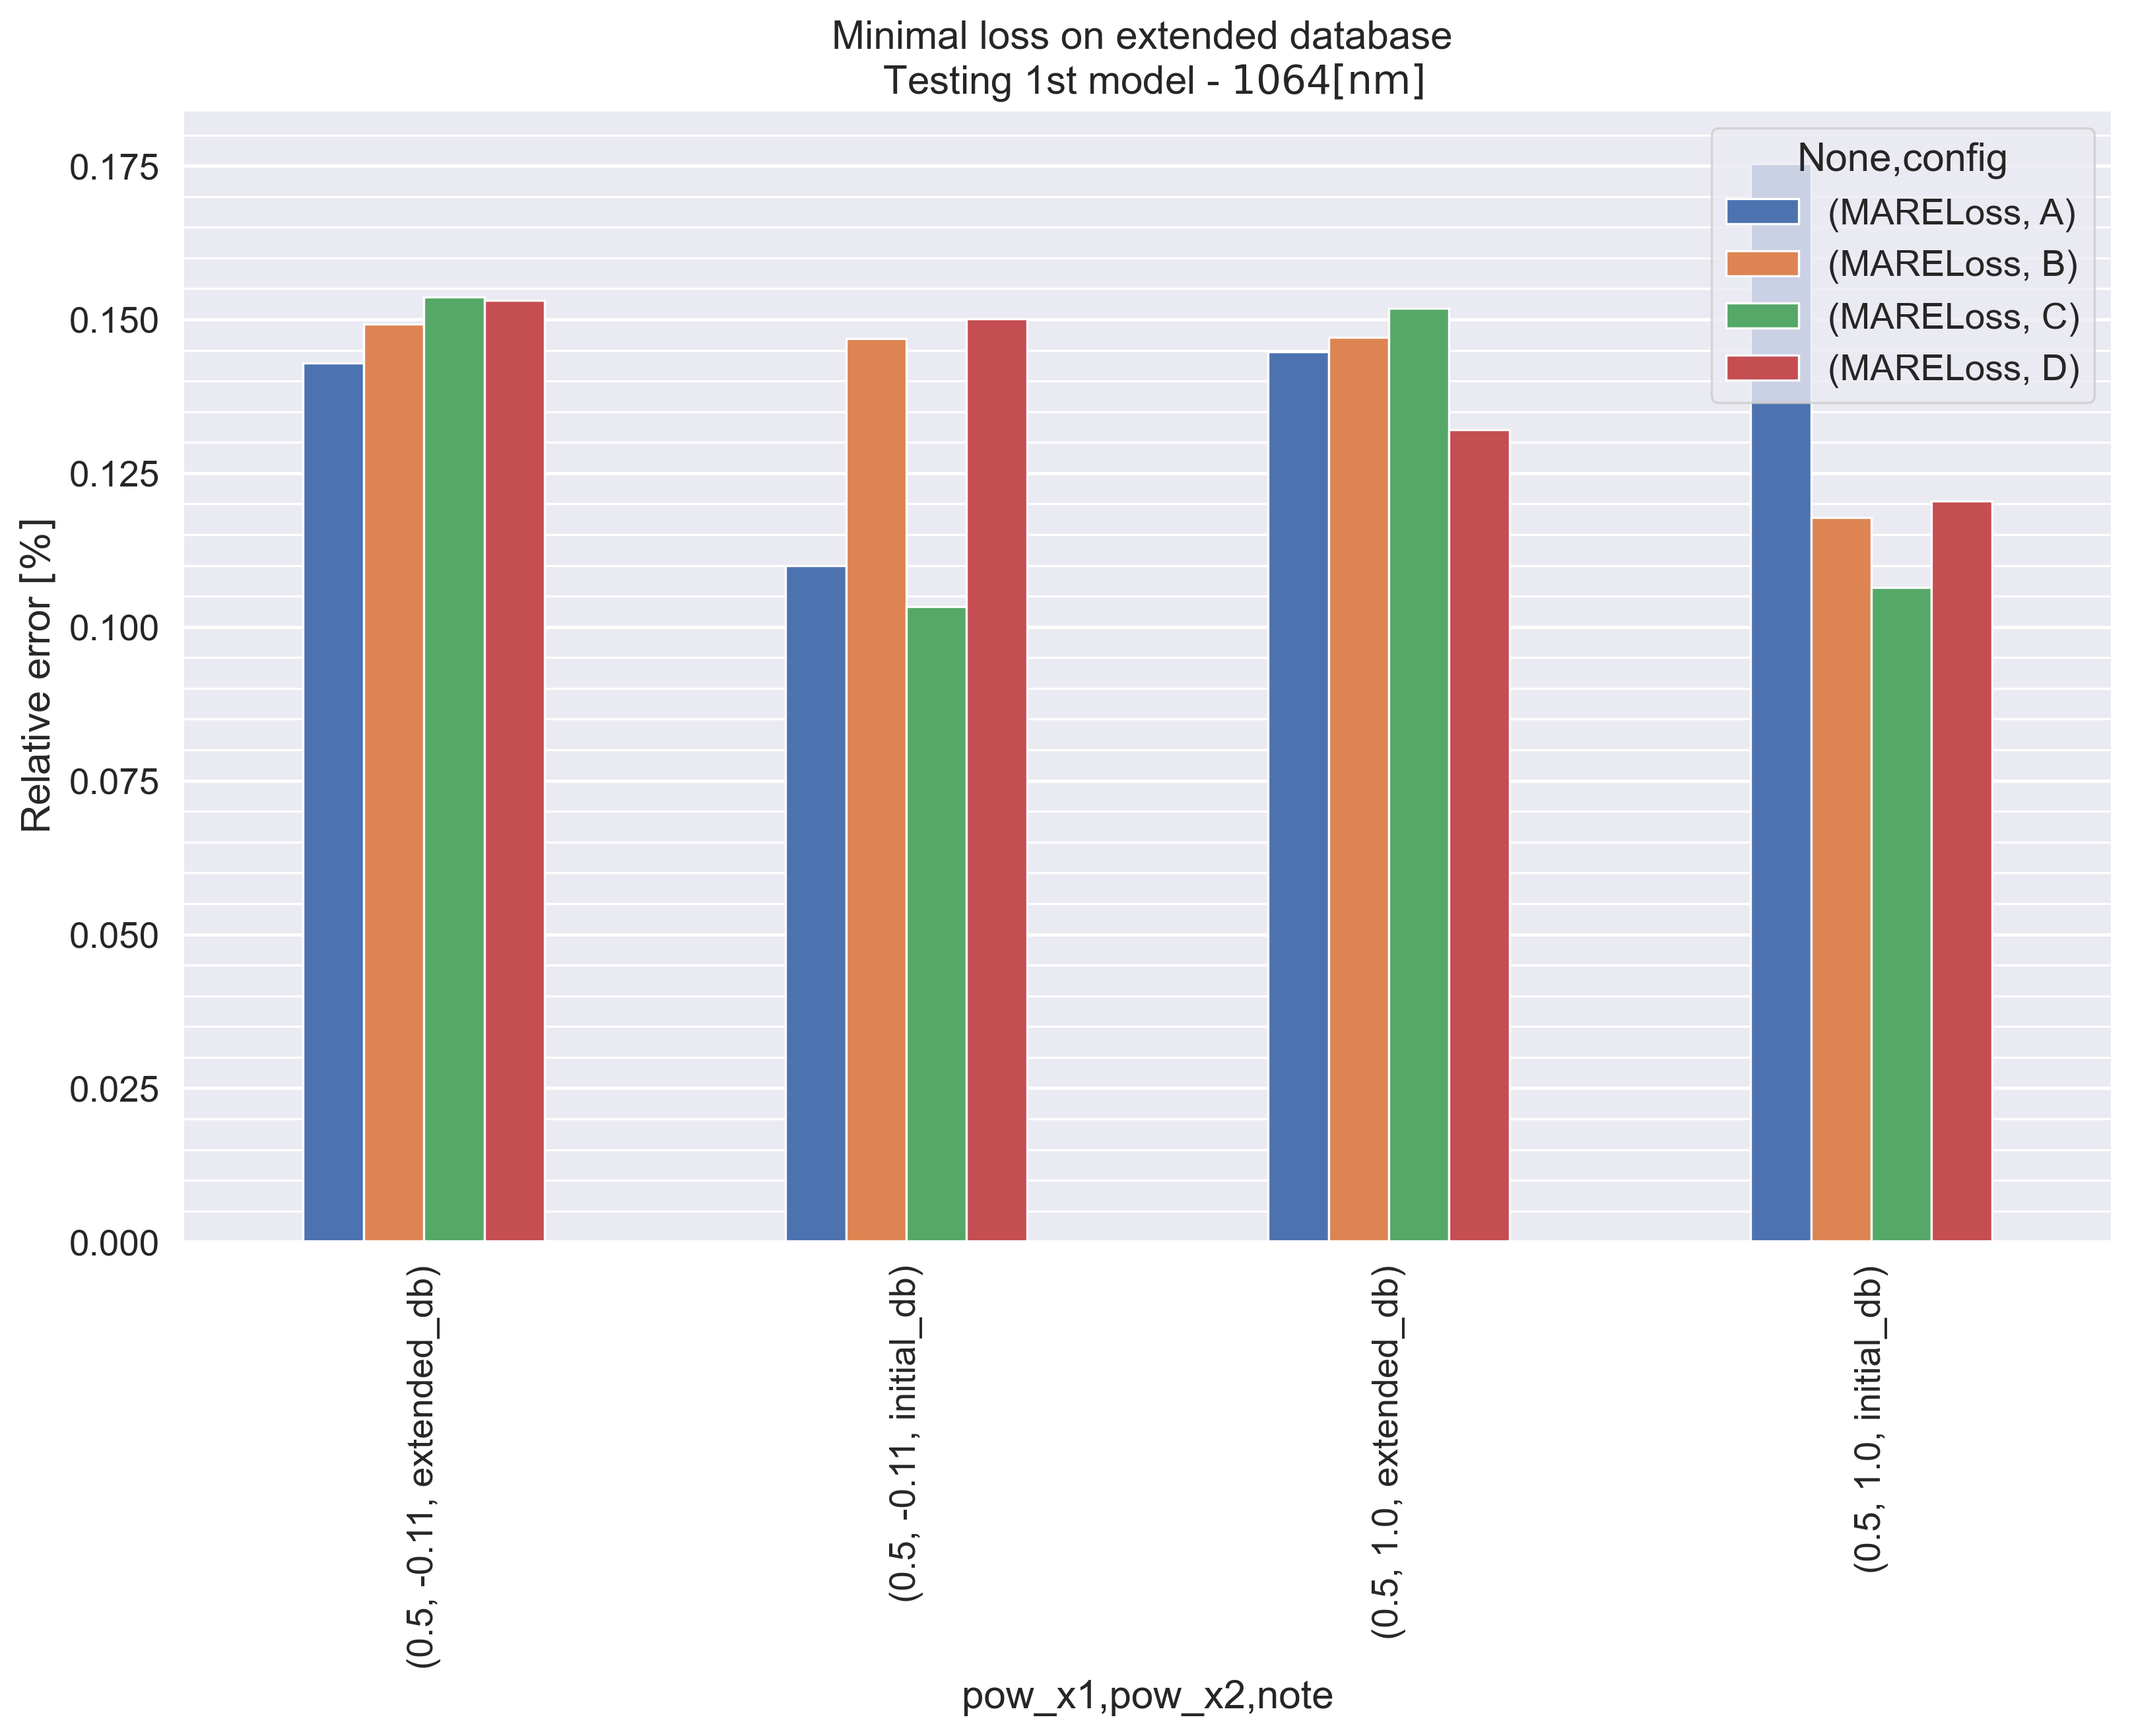

In [79]:
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 9))
    pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['pow_x1','pow_x2','note'],
                   aggfunc=np.mean).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on extended database \n Testing 1st model - '+ fr'${wavelength}[\rm nm]$' )
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    plt.tight_layout()
    plt.show()

<ipython-input-80-1ade521e2fb3>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']


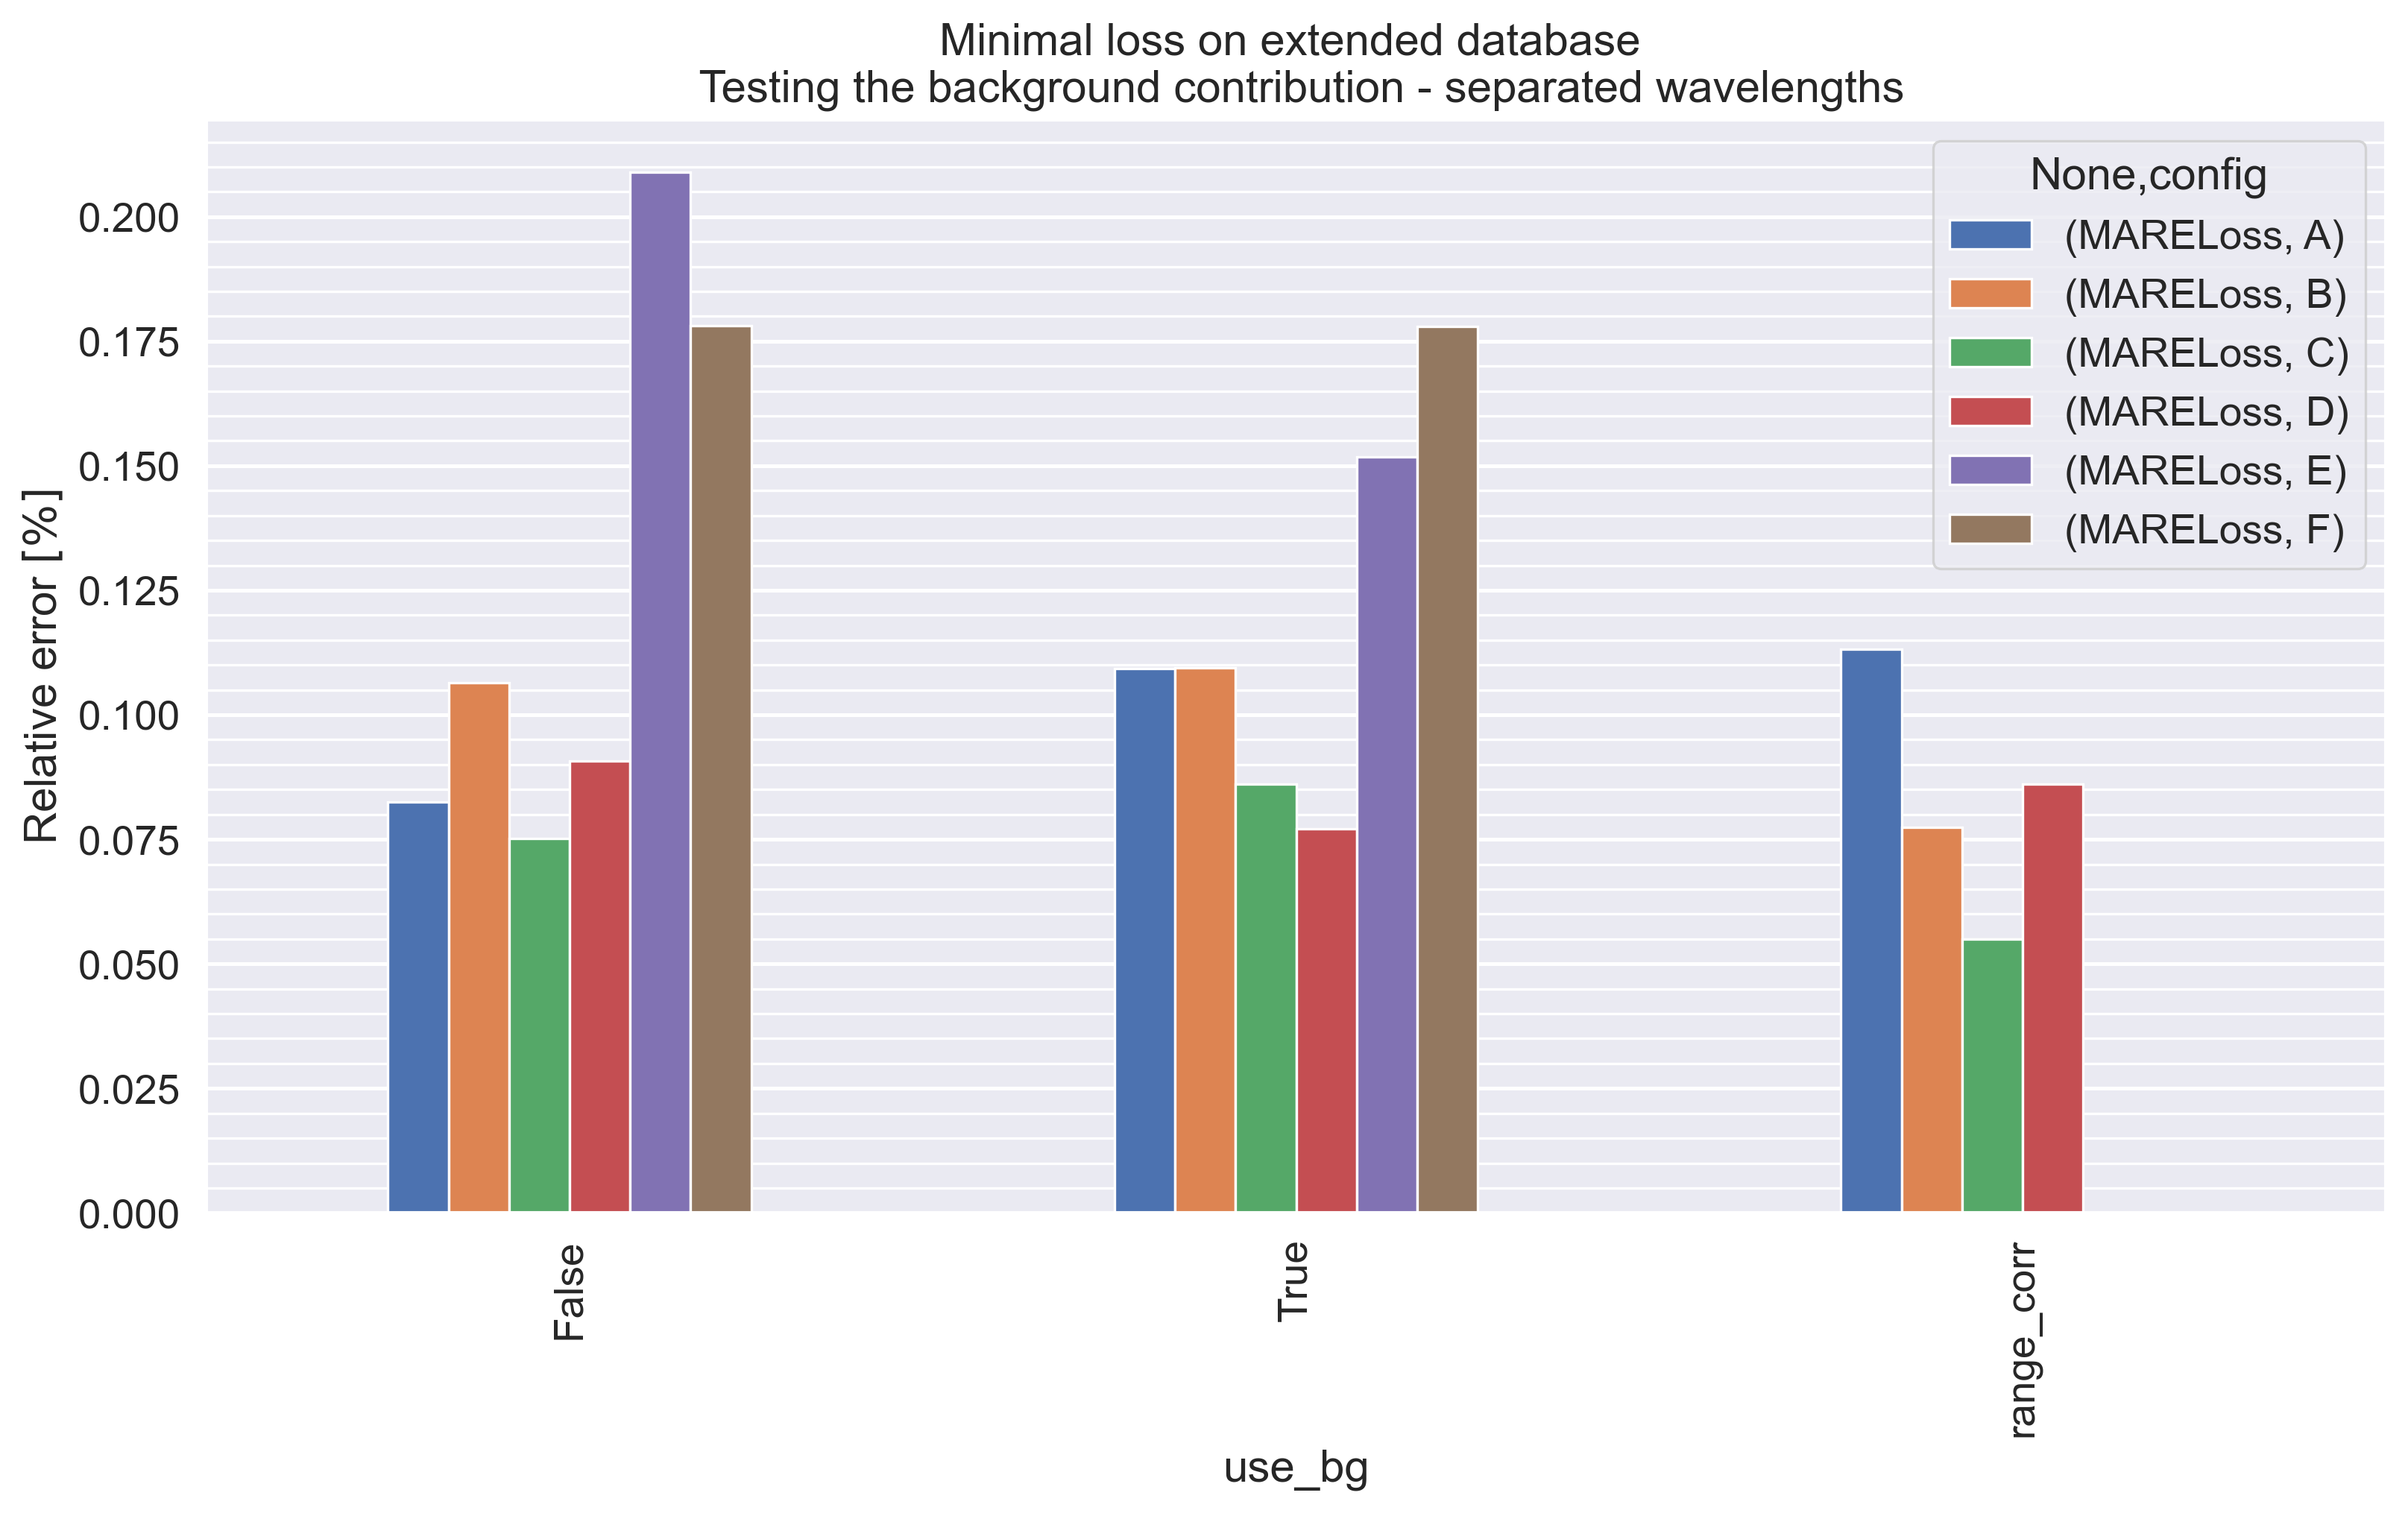

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on extended database \n Testing the background contribution - separated wavelengths')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

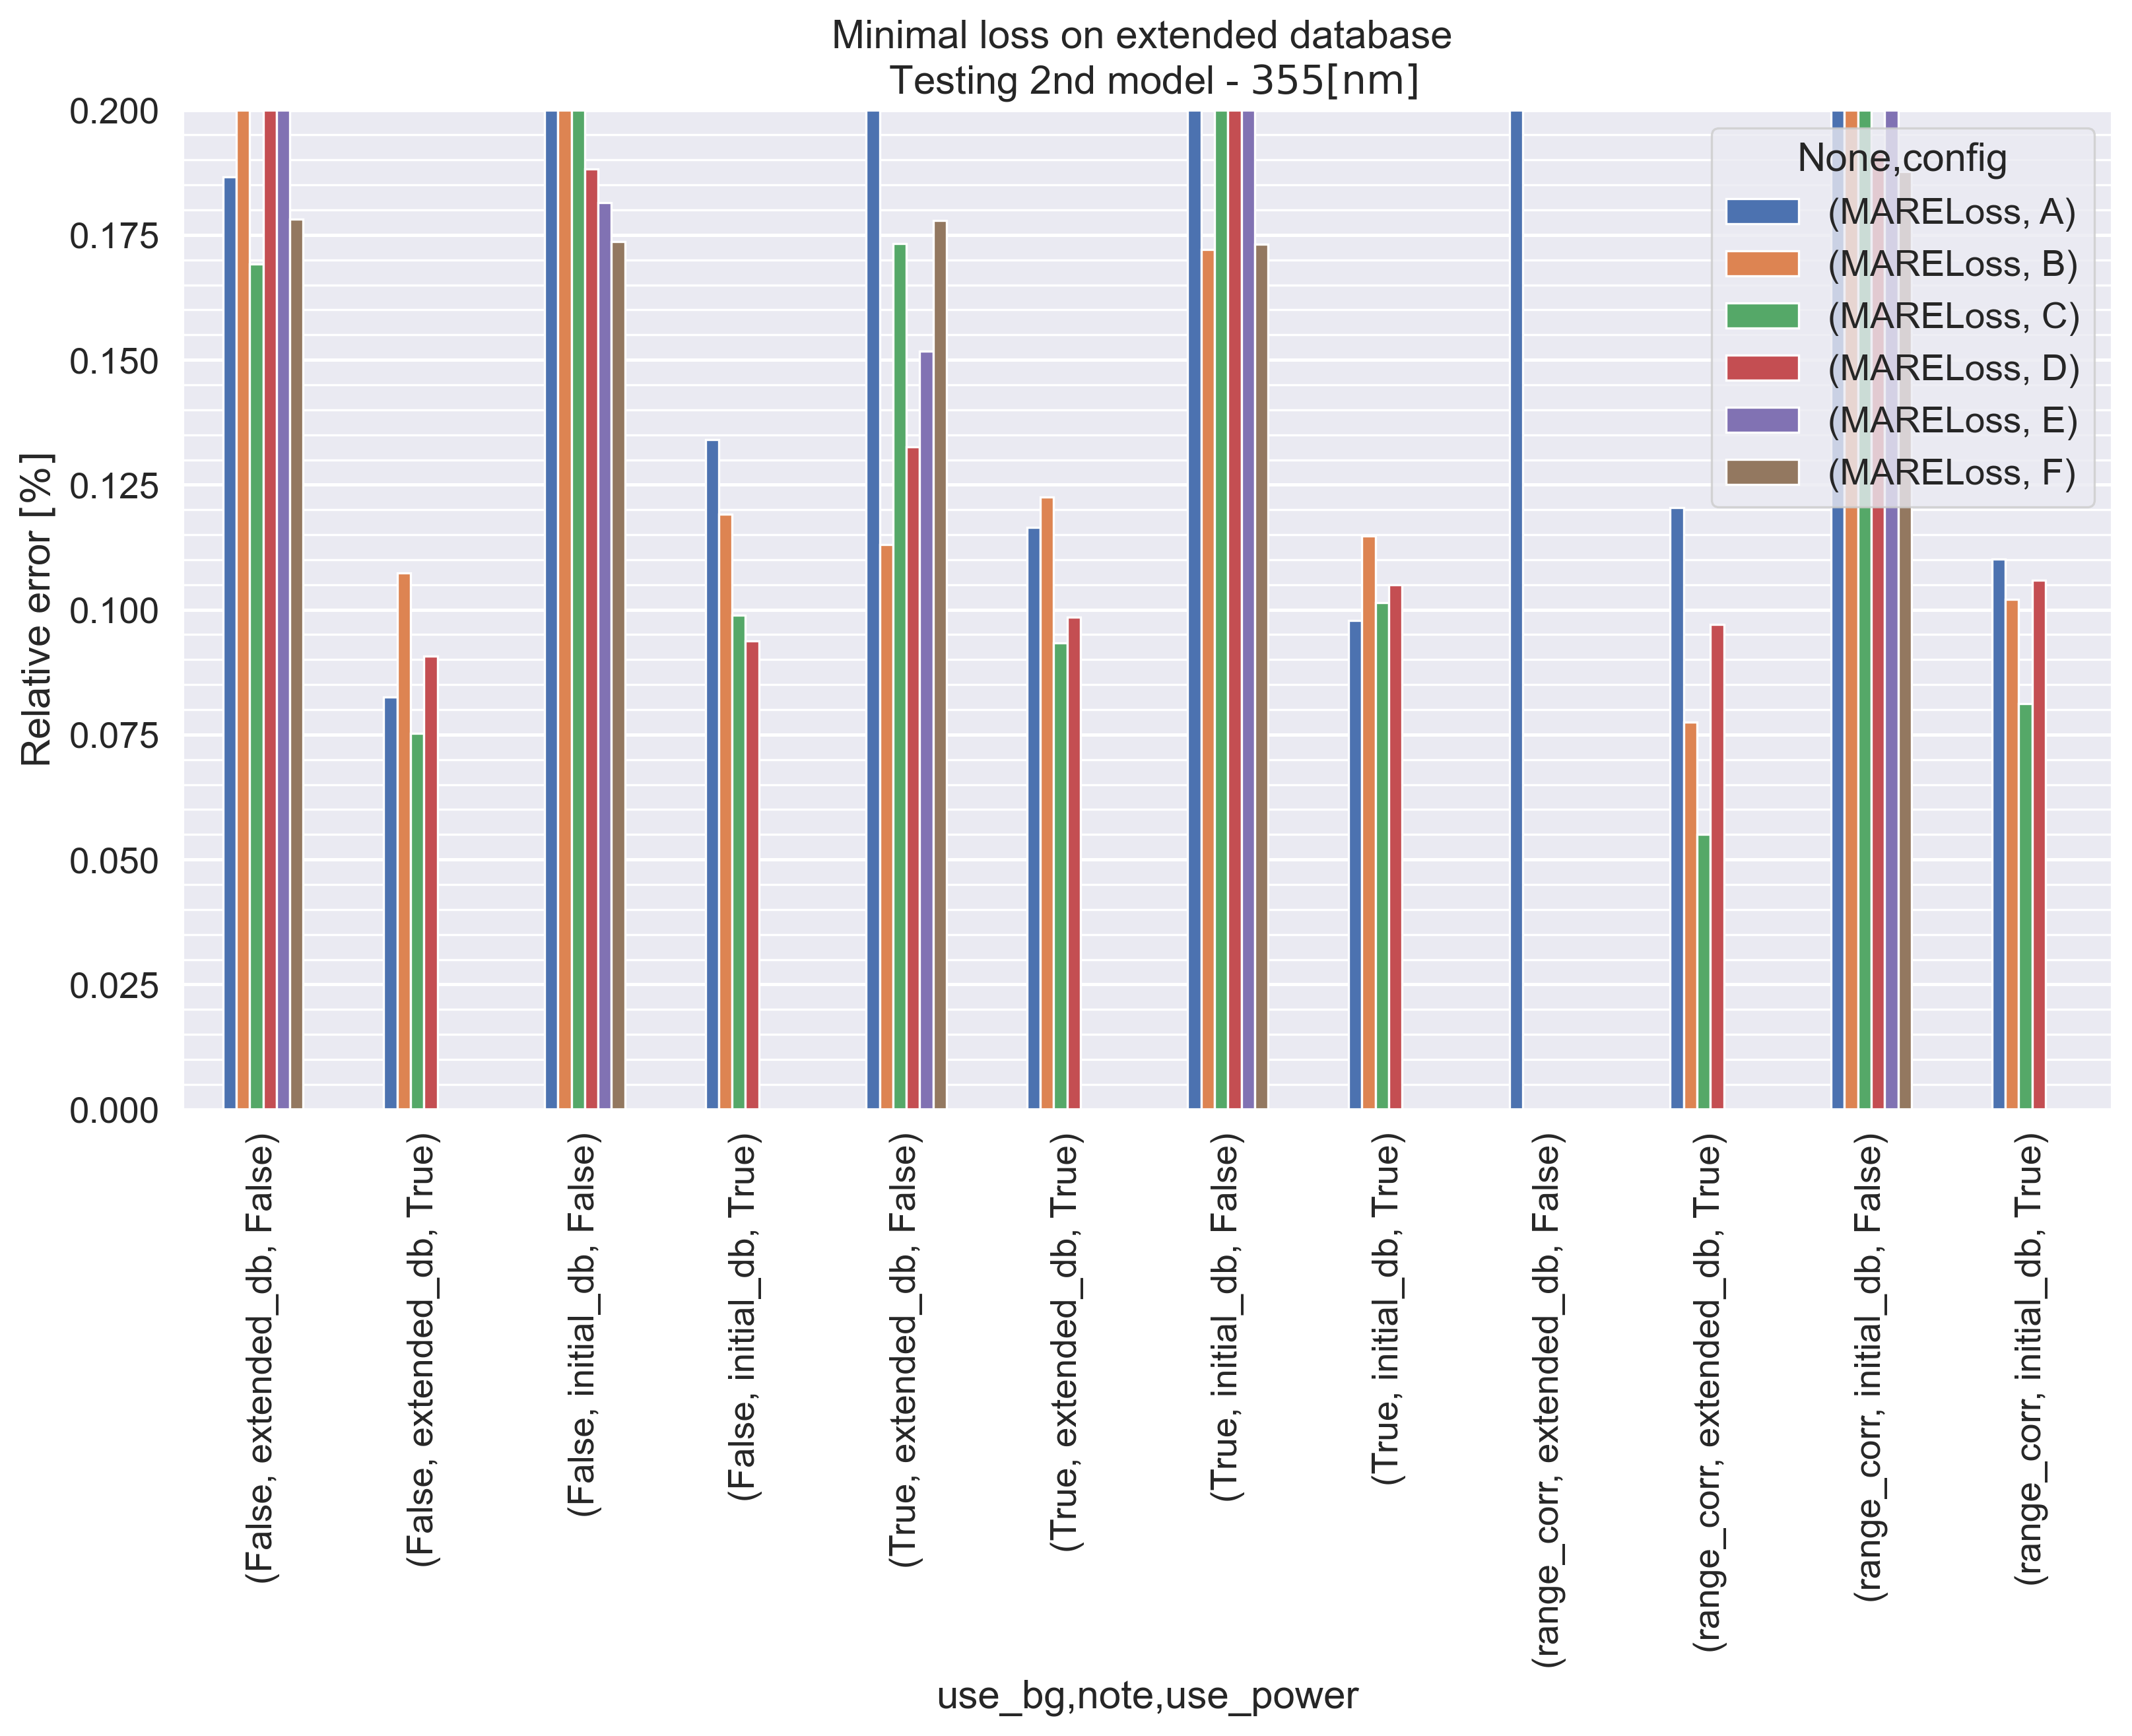

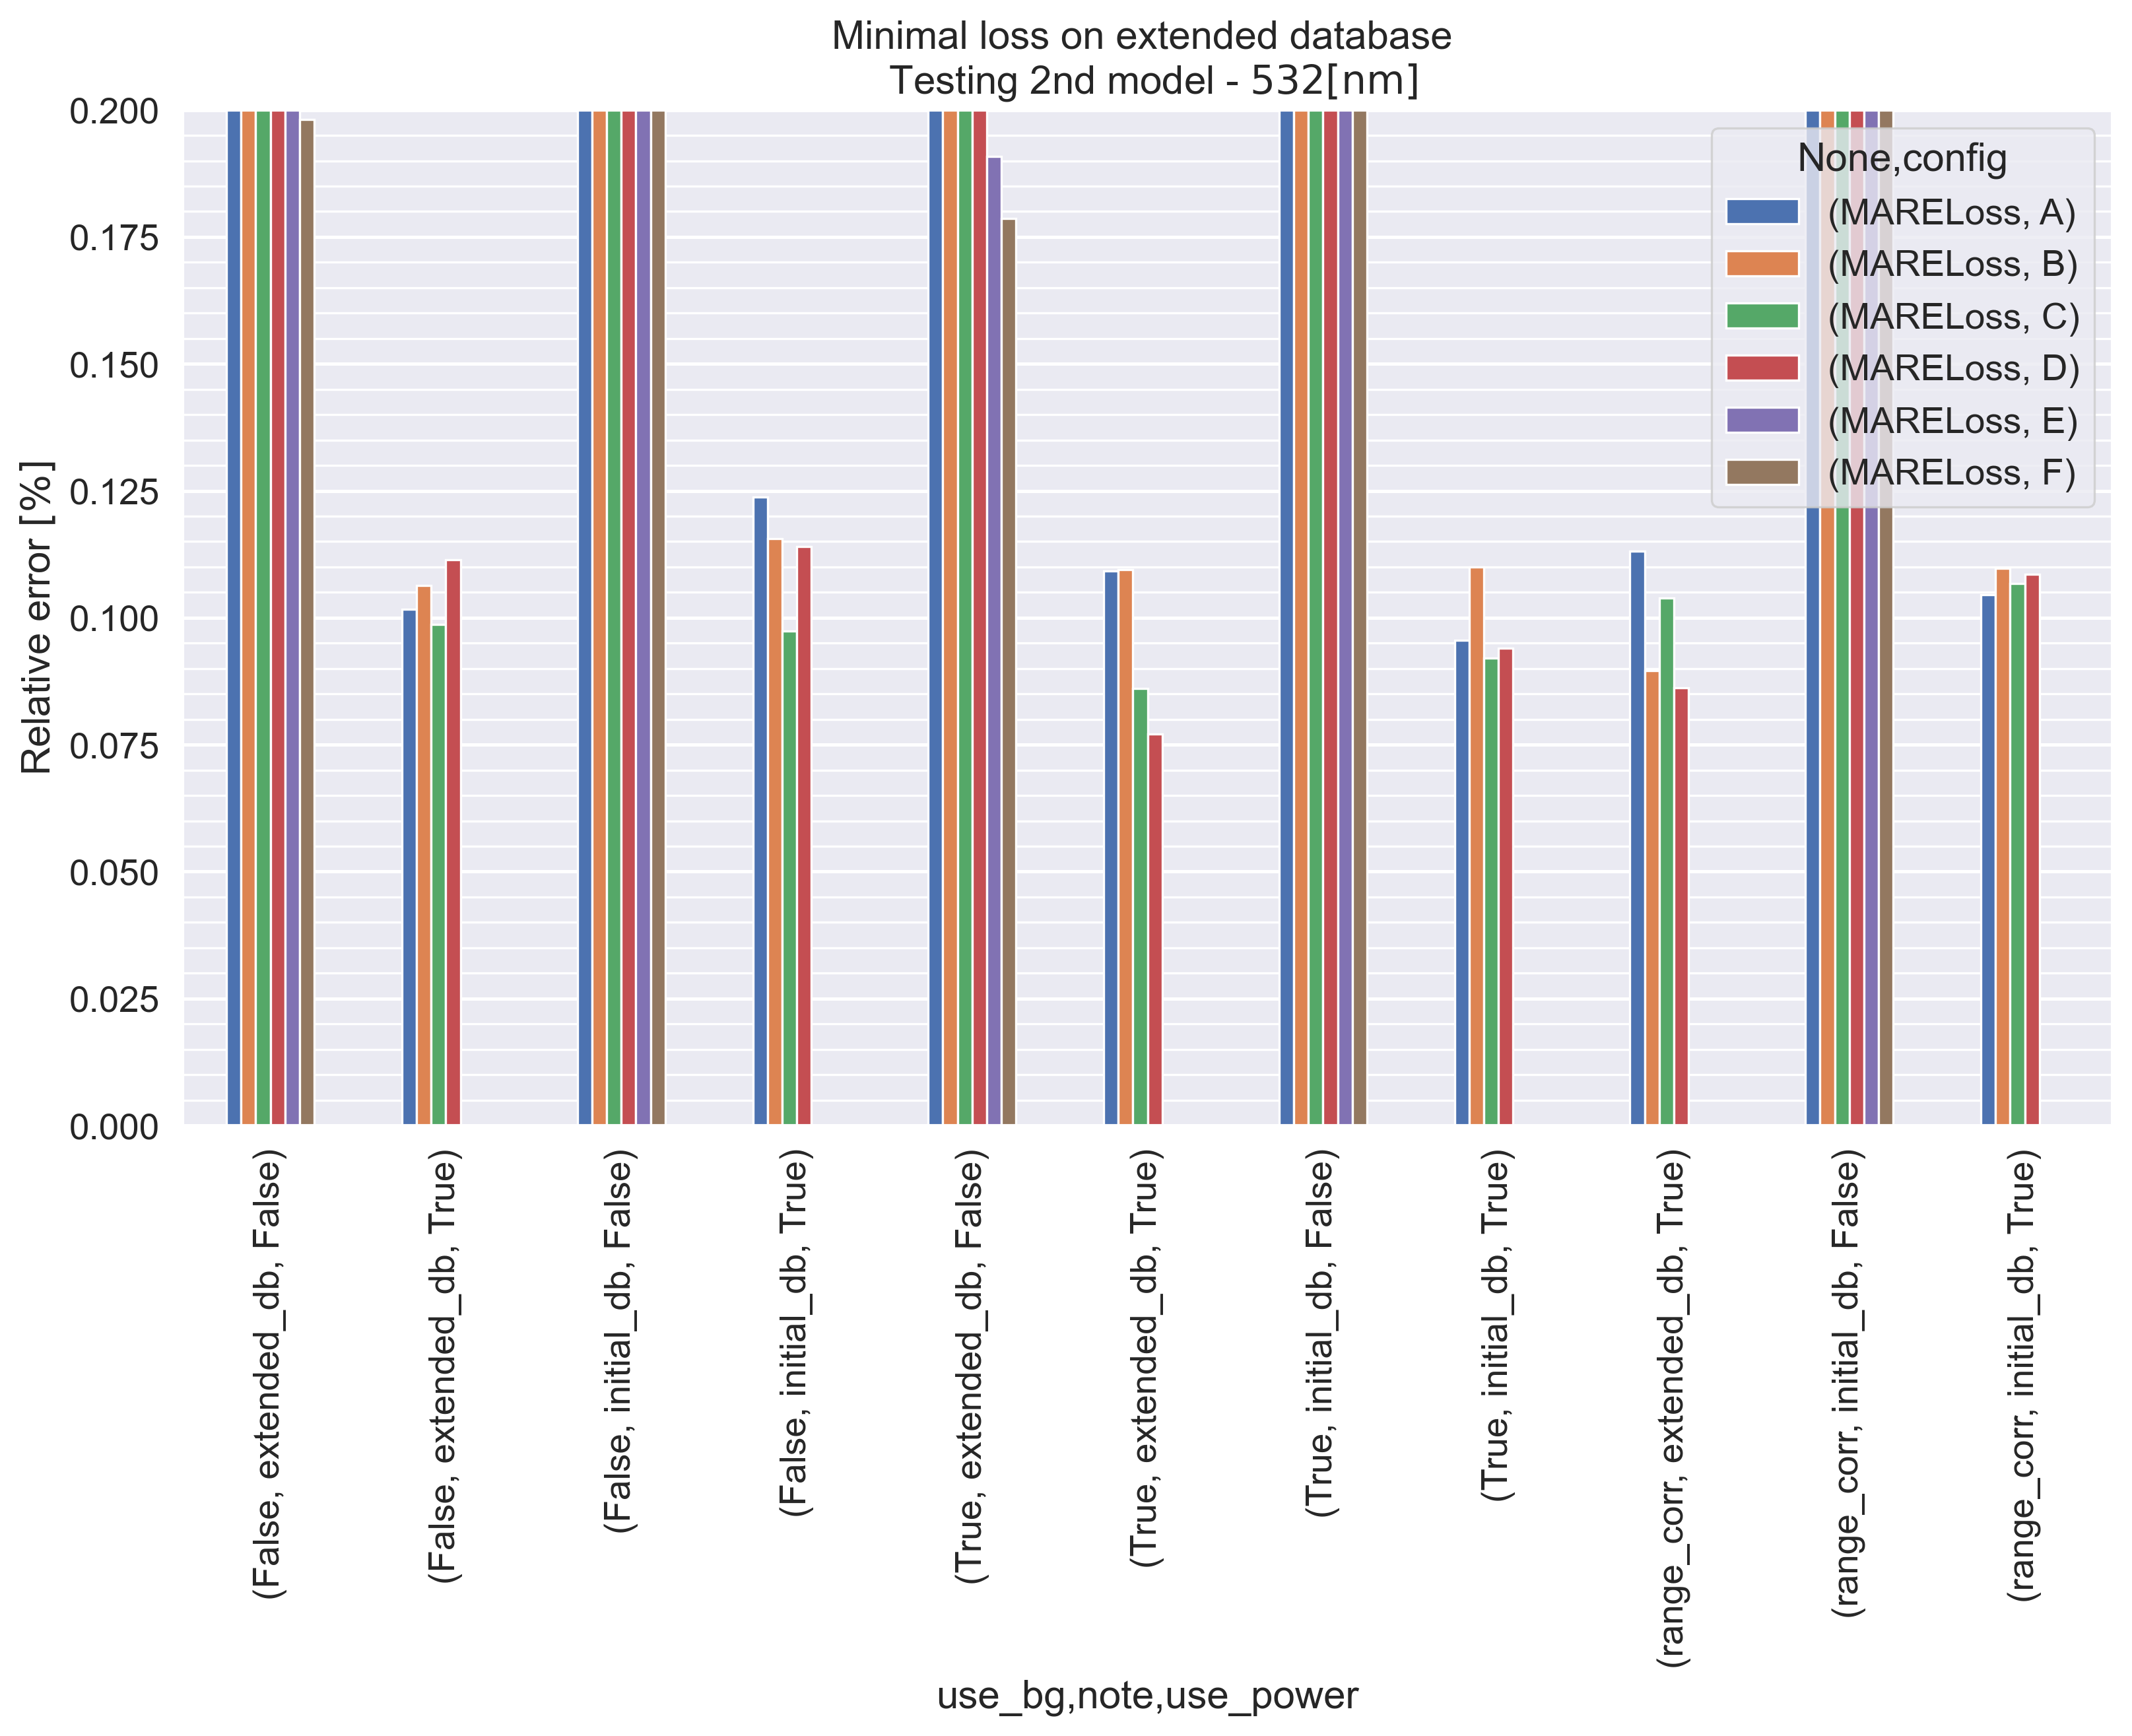

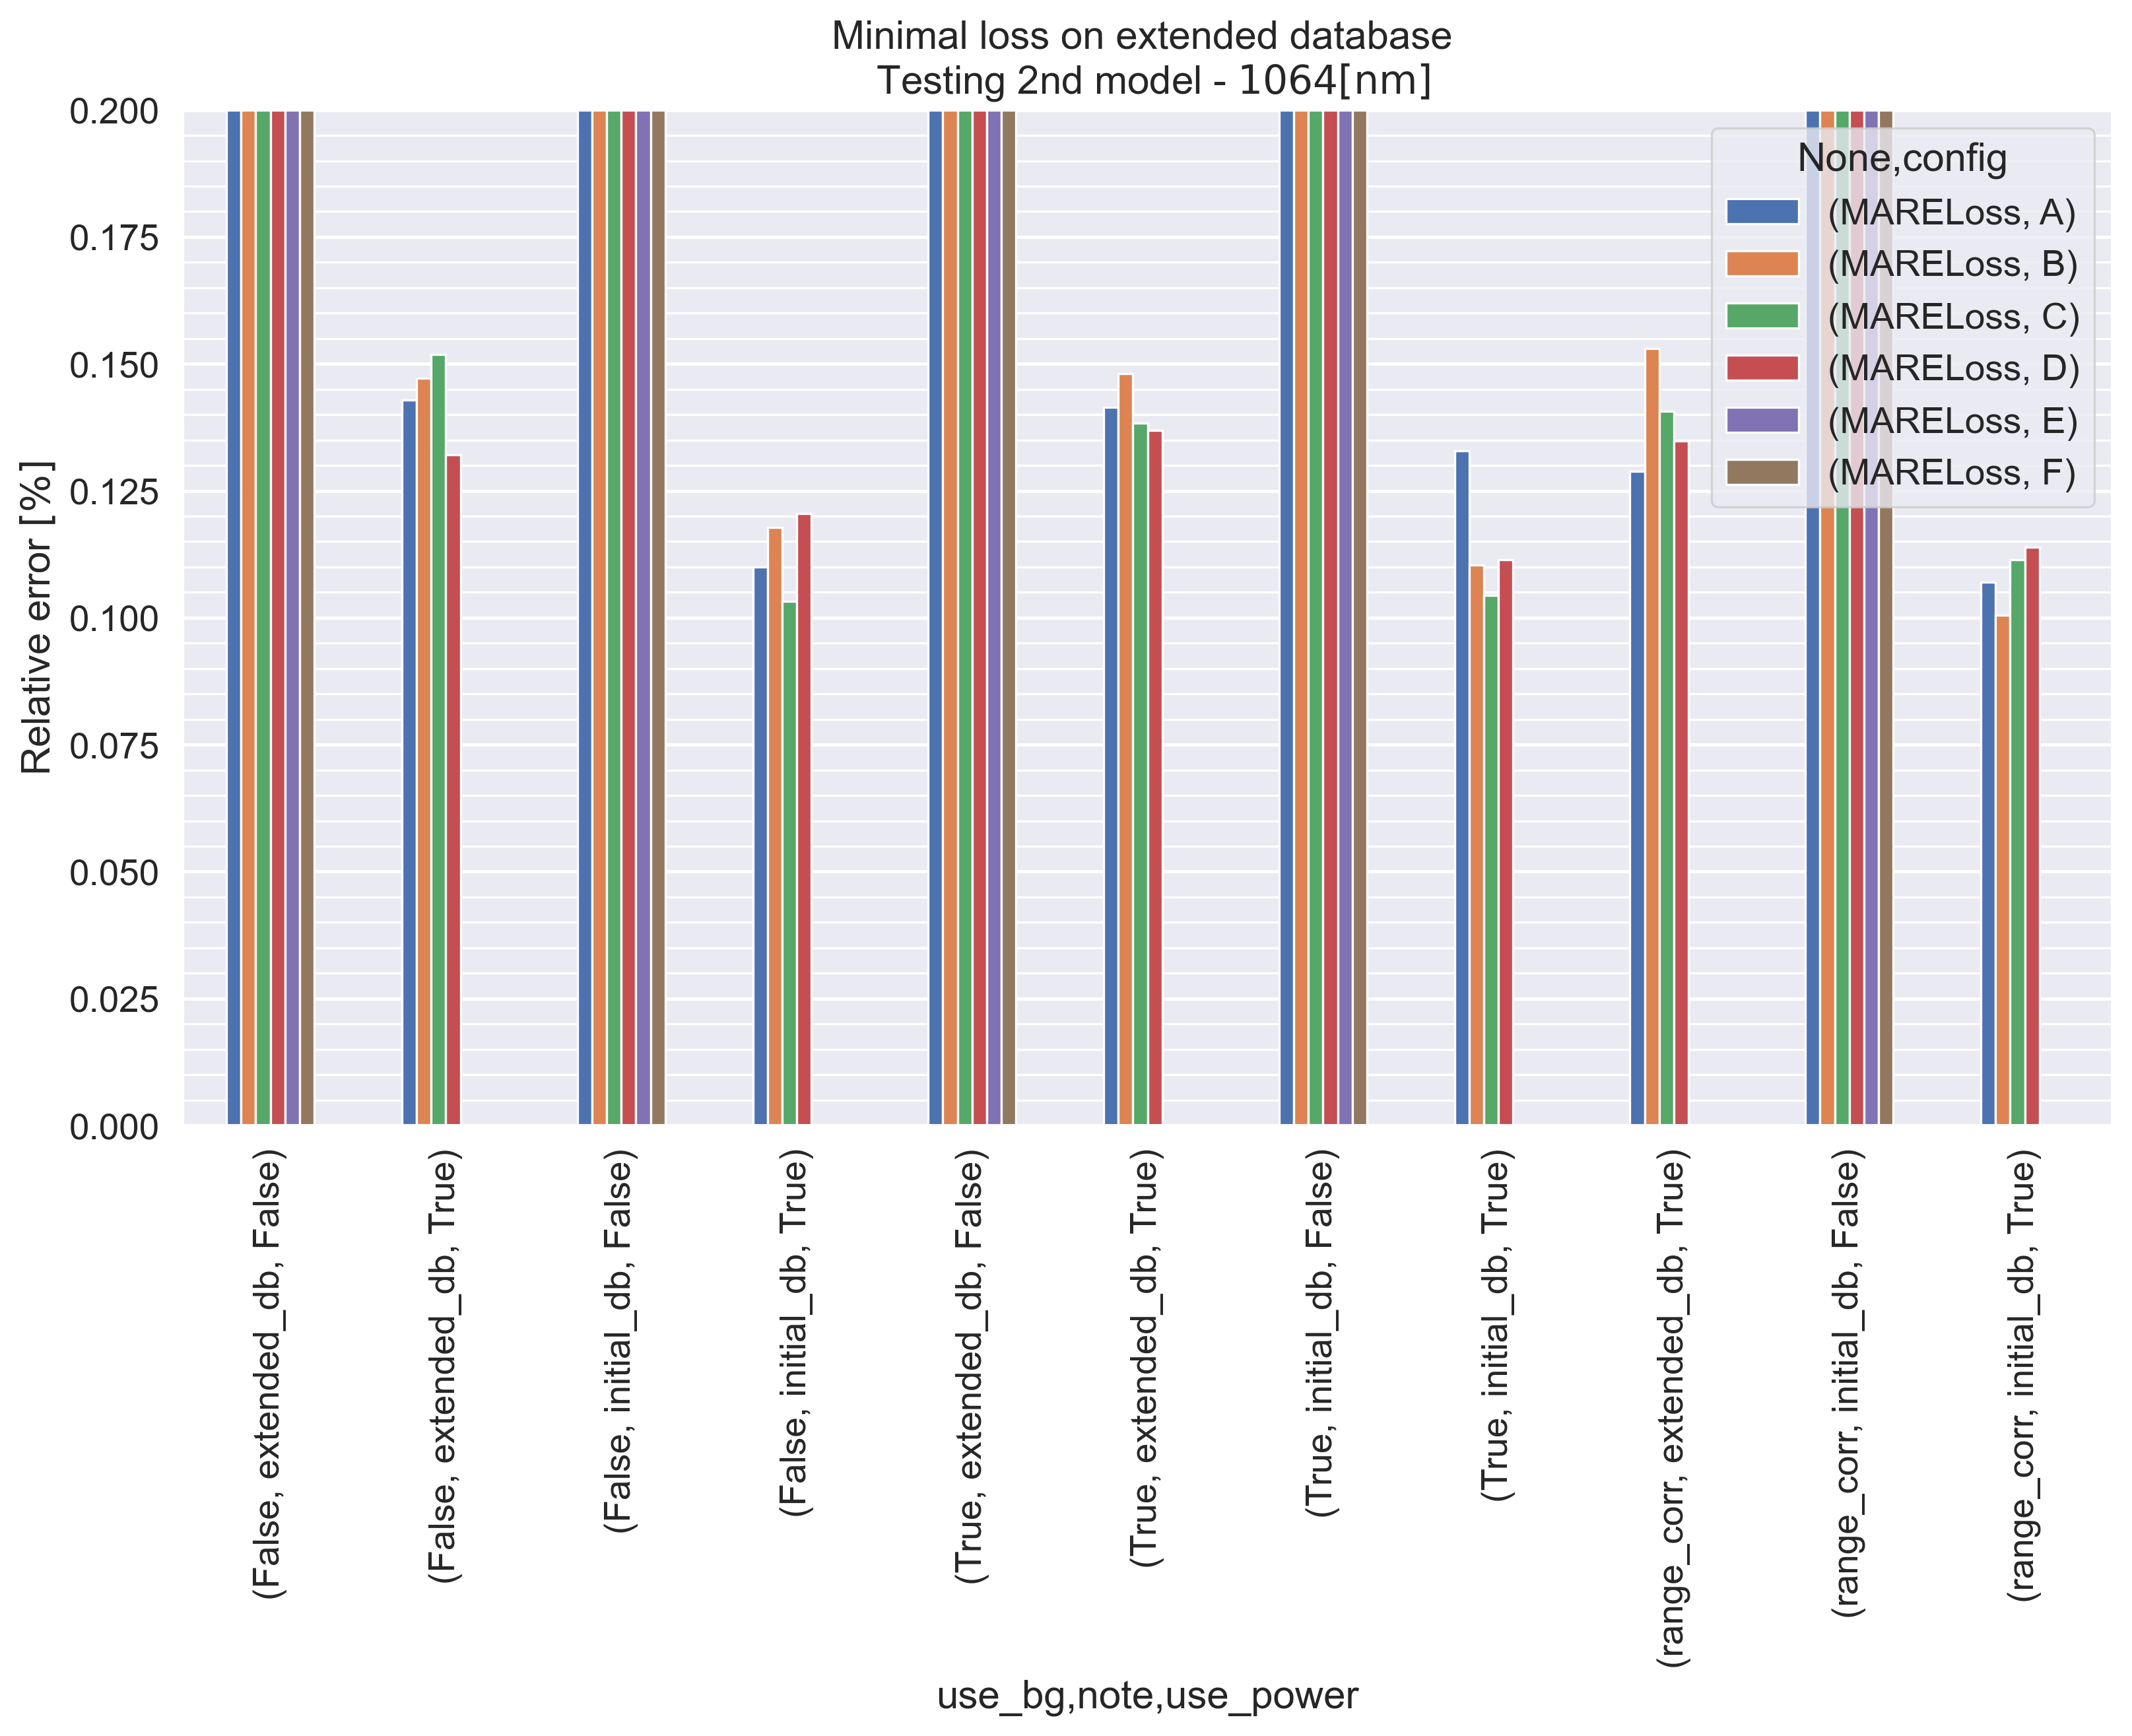

In [81]:
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 9))
    pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'note','use_power'],
                   aggfunc=np.min).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on extended database \n Testing 2nd model - '+ fr'${wavelength}[\rm nm]$' )
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    ax.set_ylim([0.0, 0.2])
    plt.tight_layout()
    plt.show()


<ipython-input-82-d21fc444f707>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']
<ipython-input-82-d21fc444f707>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']
<ipython-input-82-d21fc444f707>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']


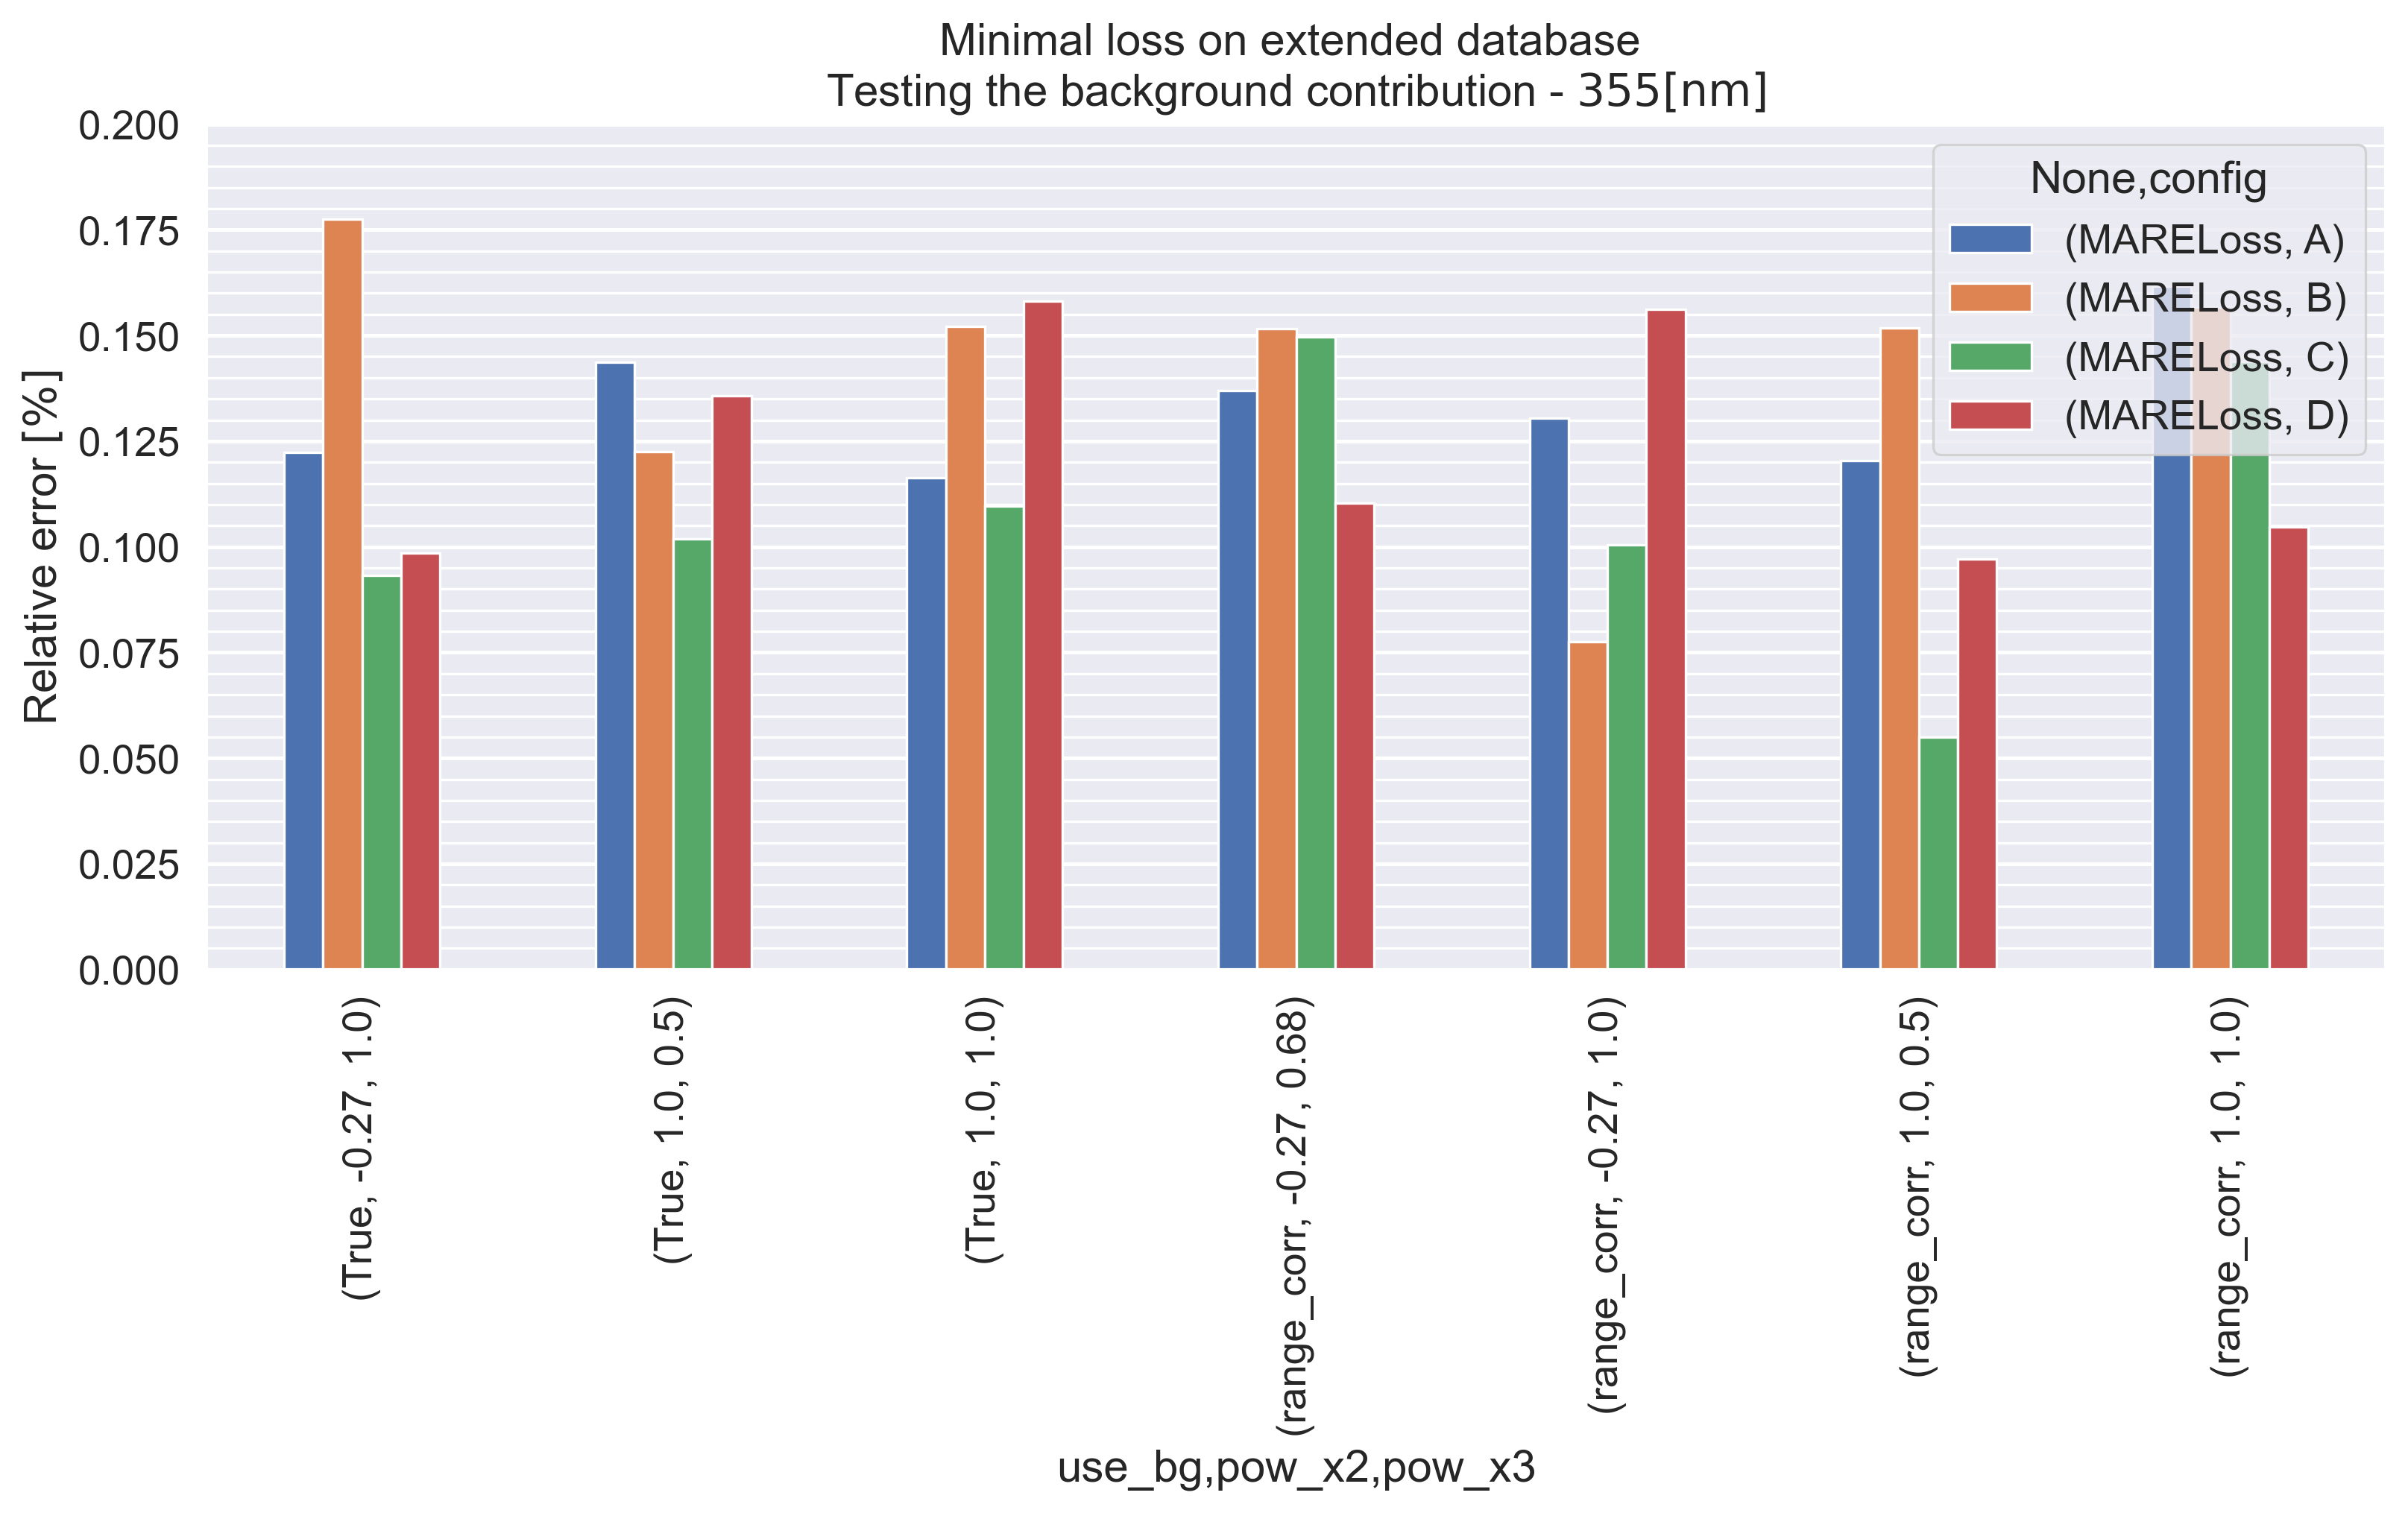

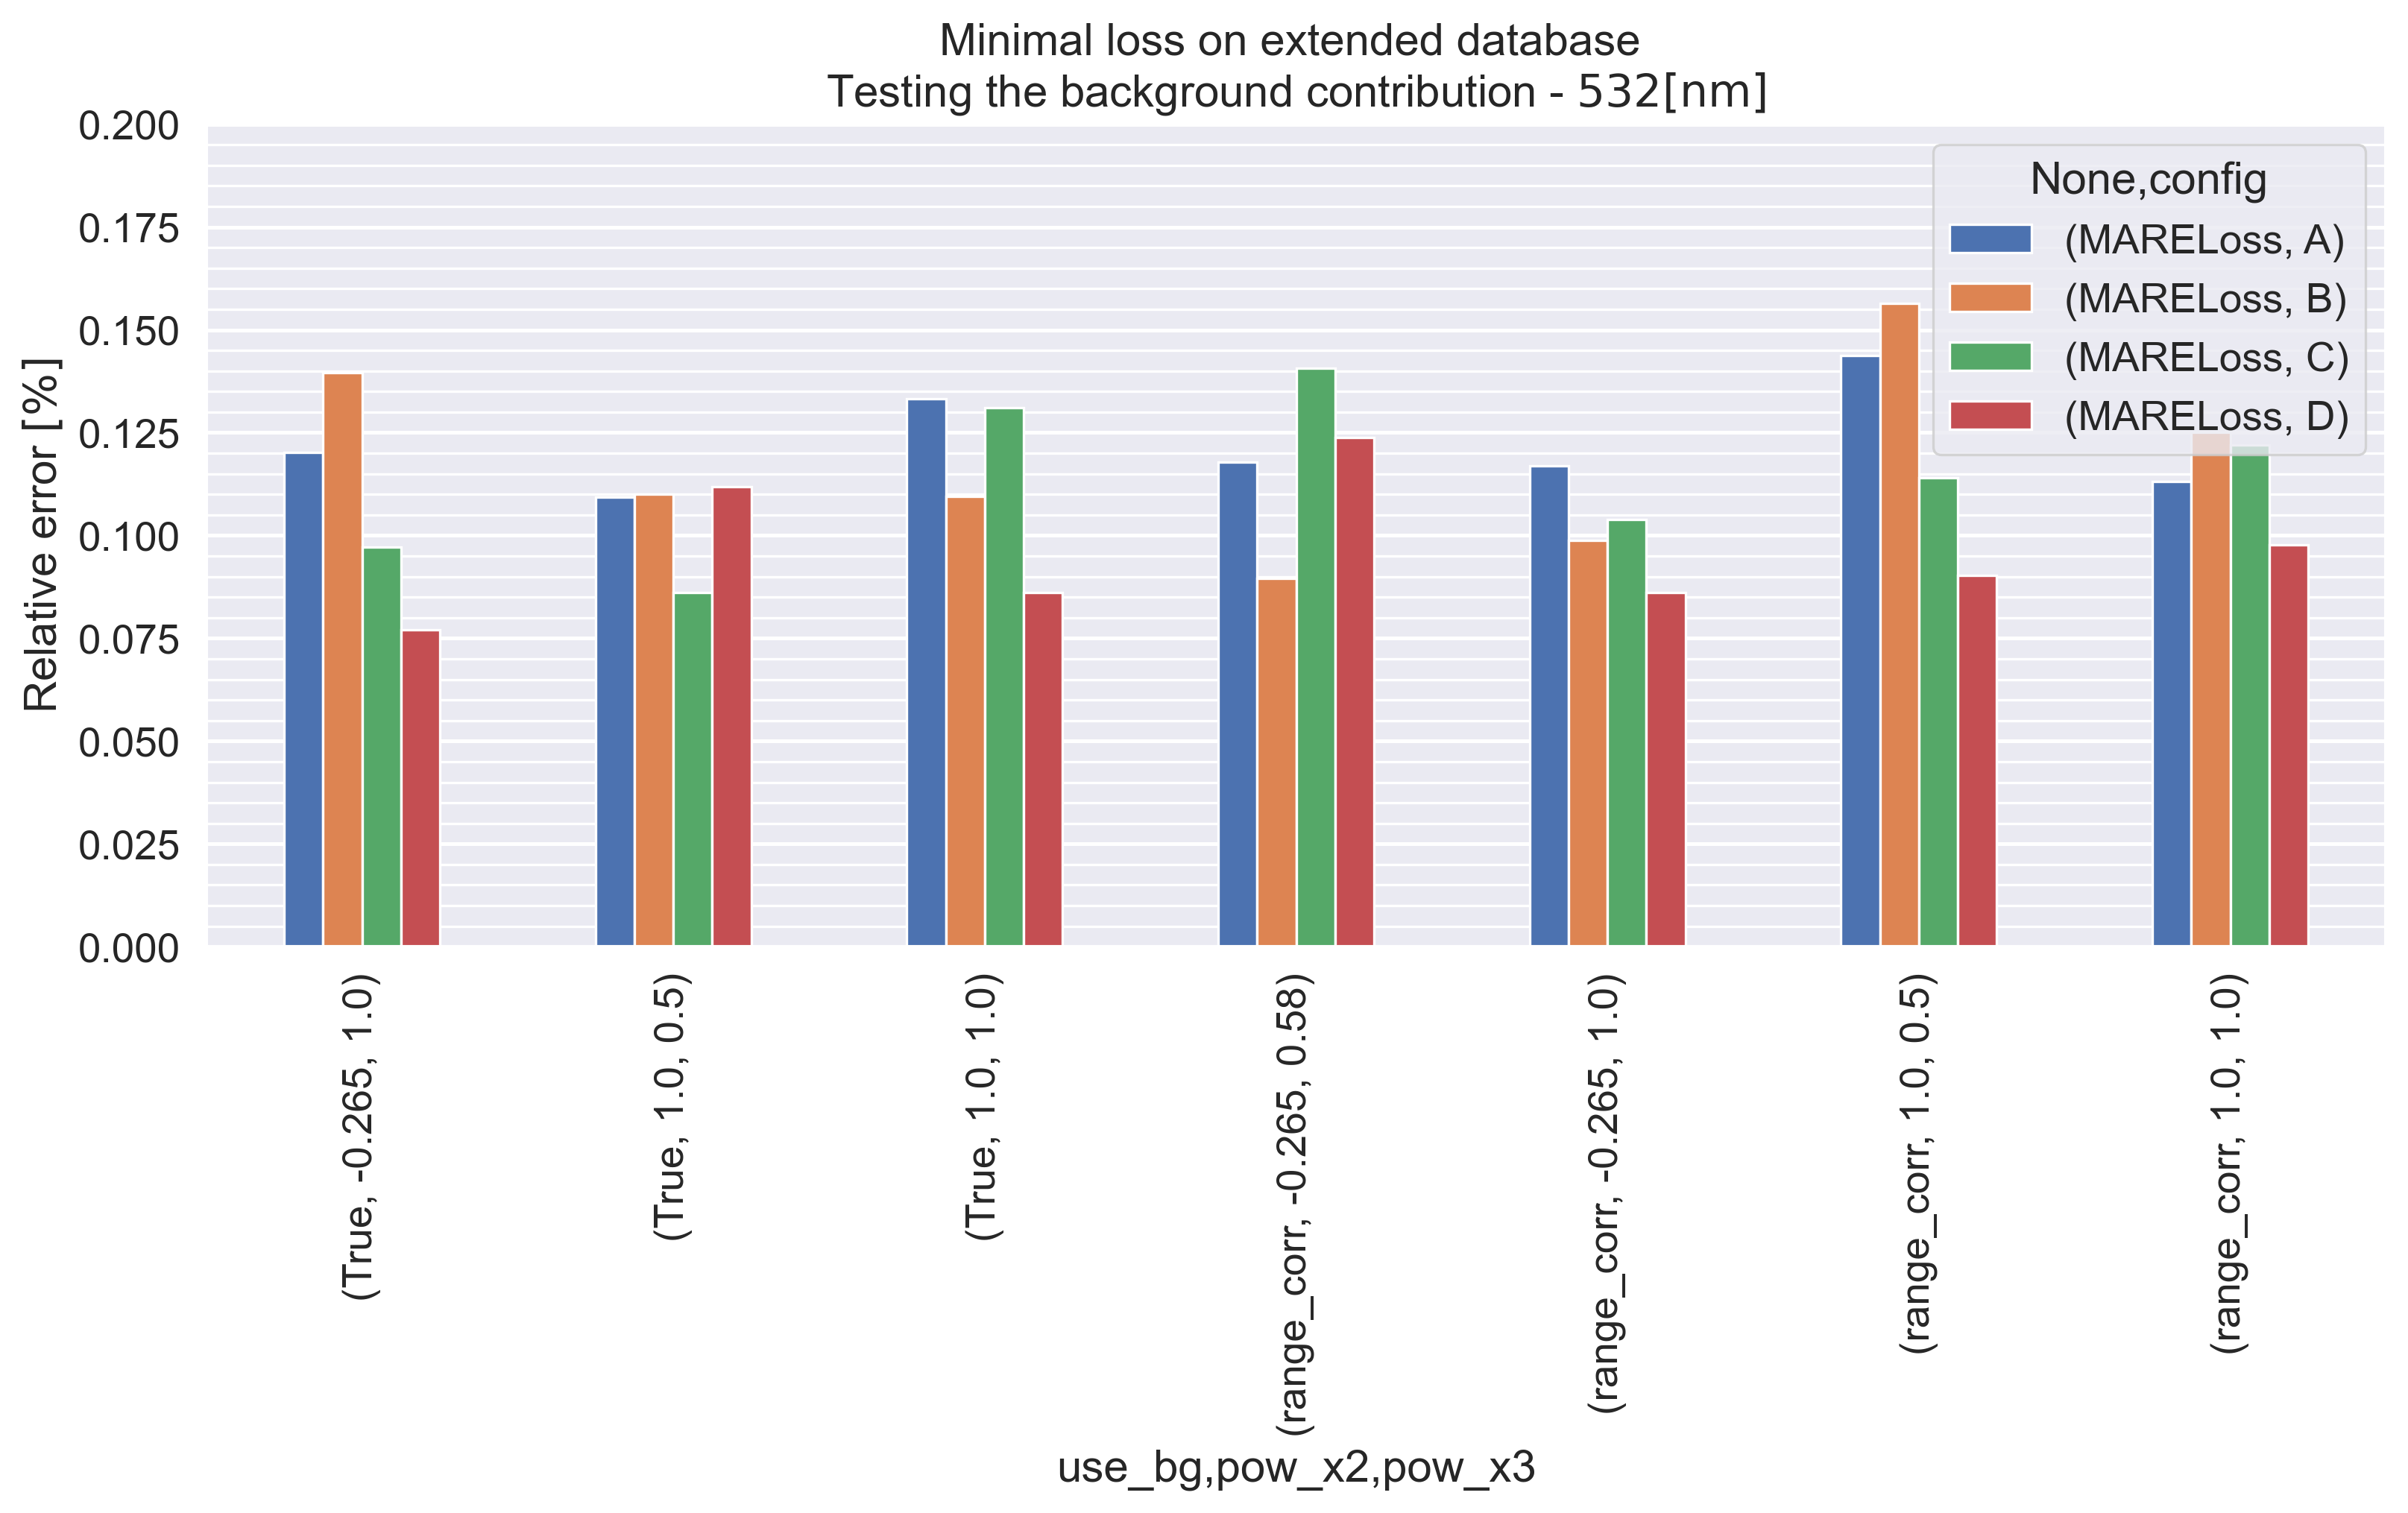

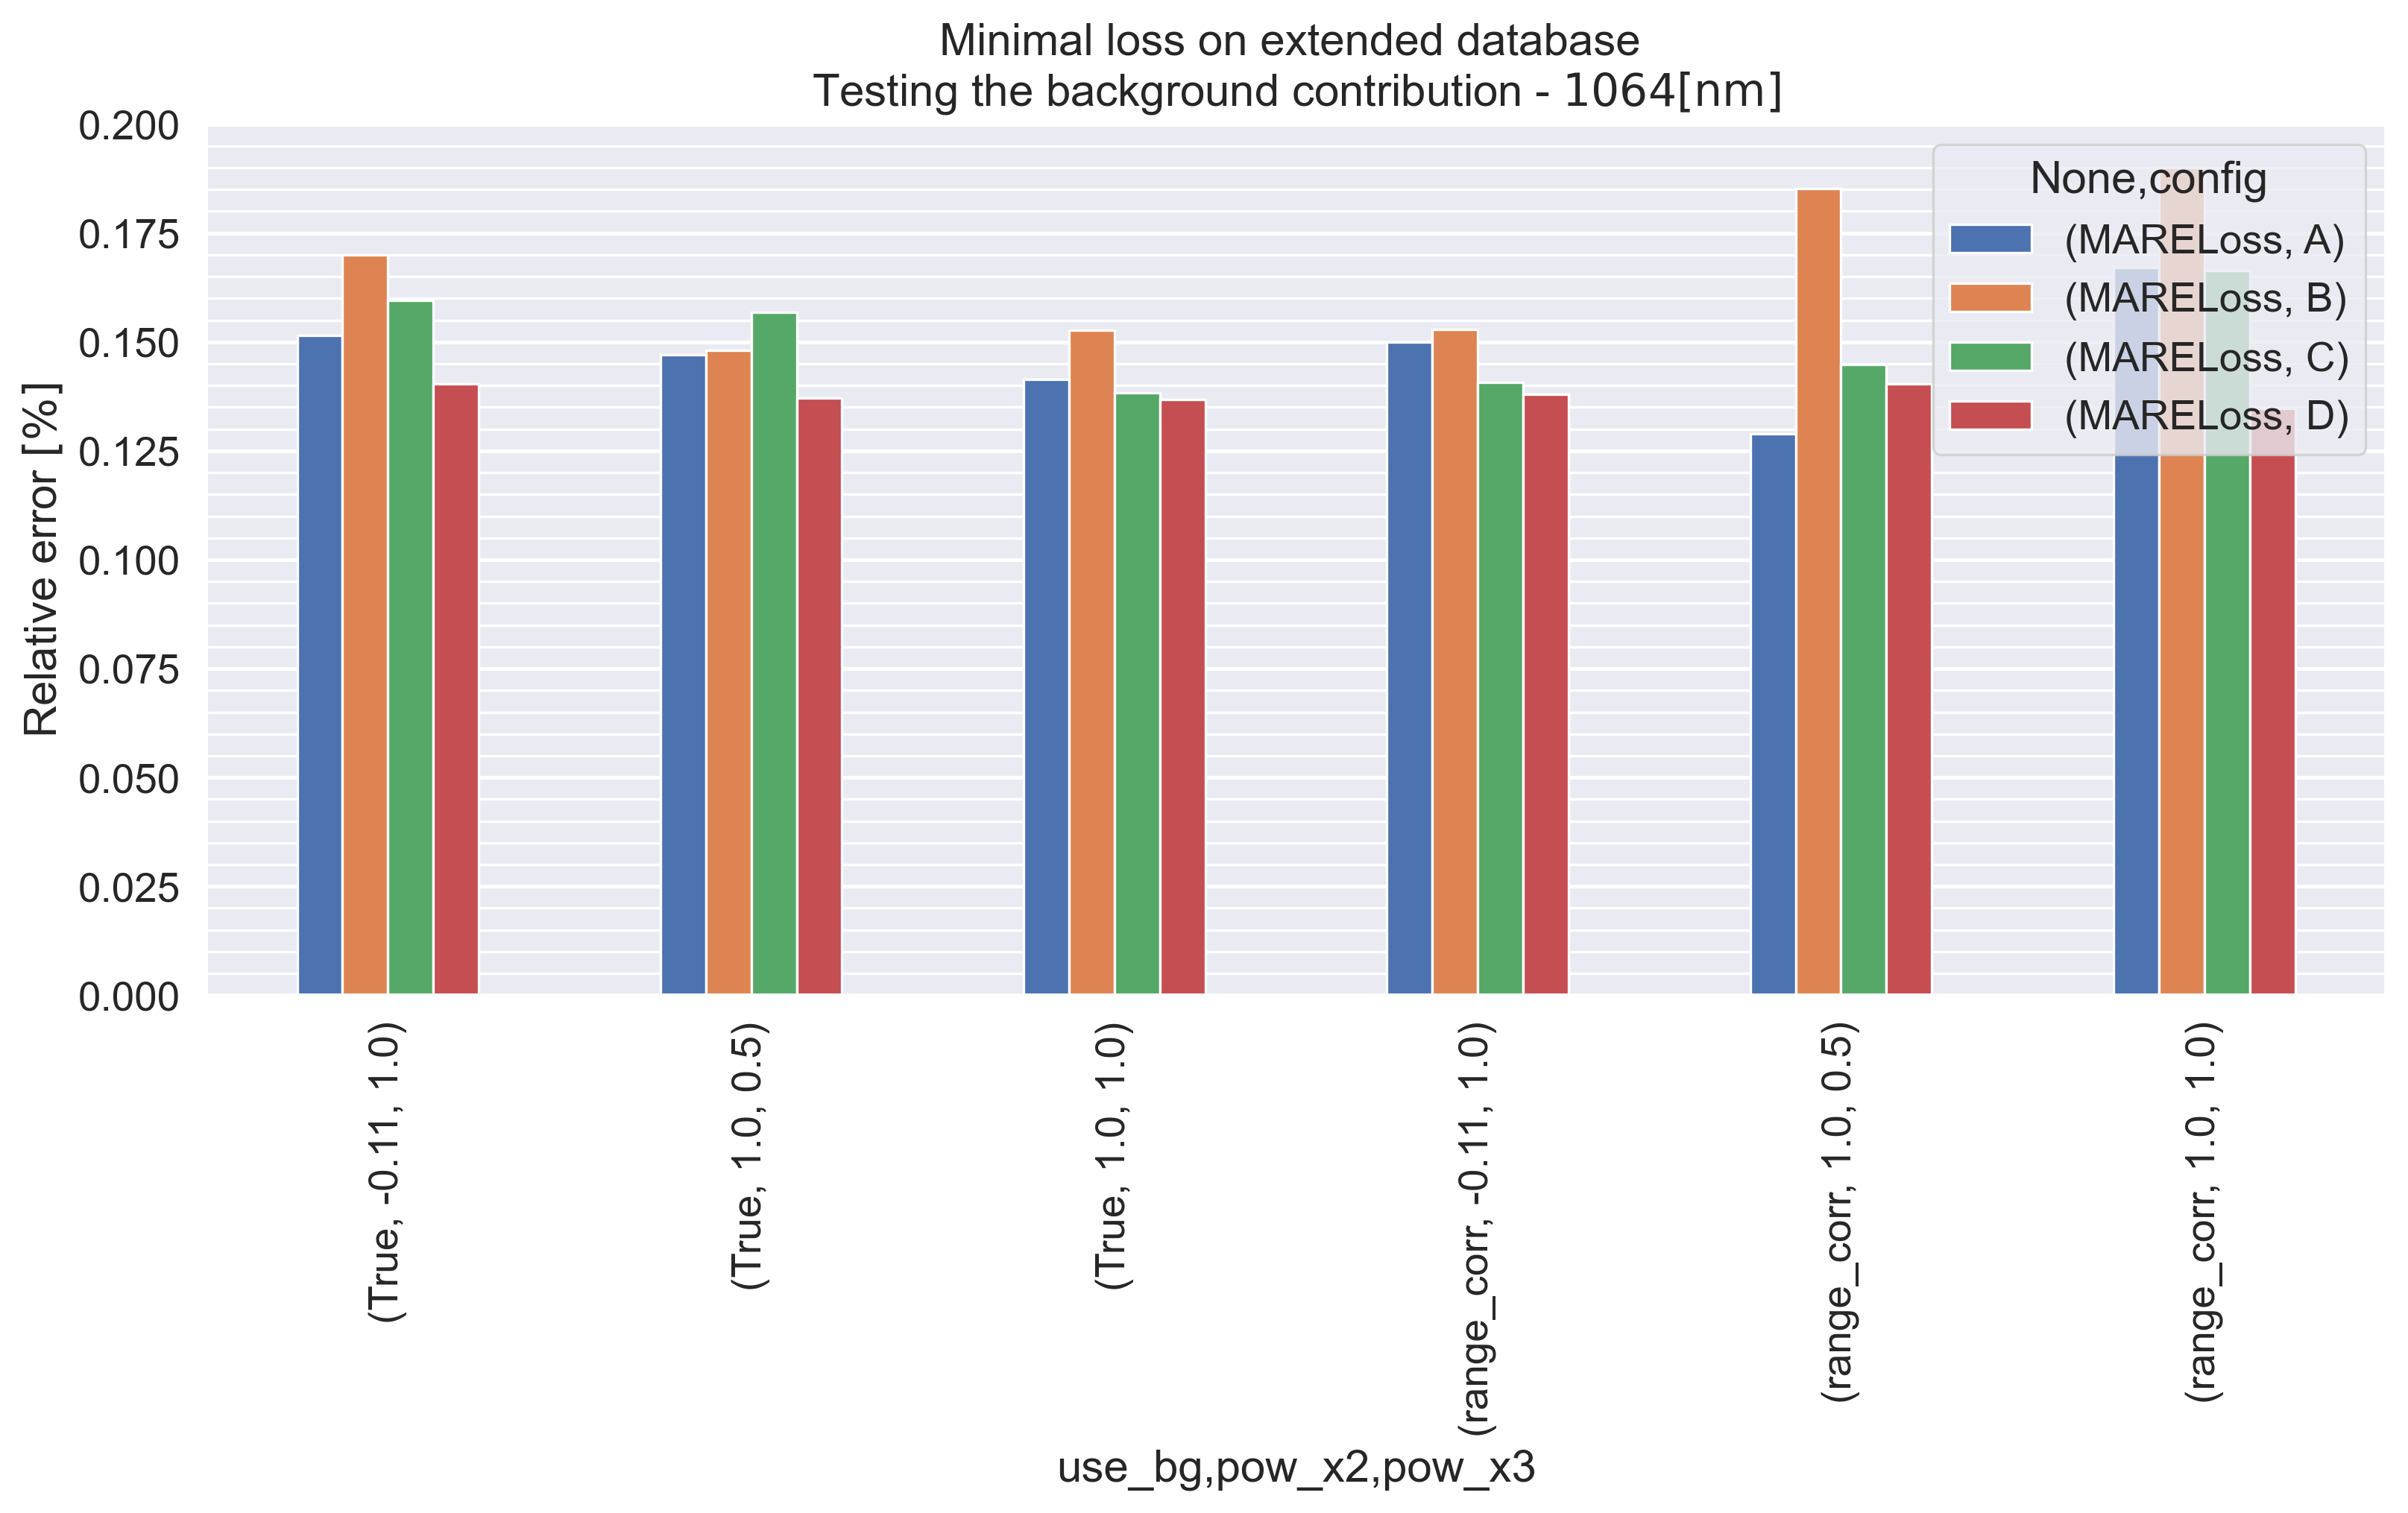

In [82]:
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

    pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'pow_x2','pow_x3'],
                   aggfunc=np.min).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on extended database \n'+fr'Testing the background contribution - ${wavelength}[\rm nm]$')
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    ax.set_ylim([0.0, 0.2])
    plt.tight_layout()
    plt.show()

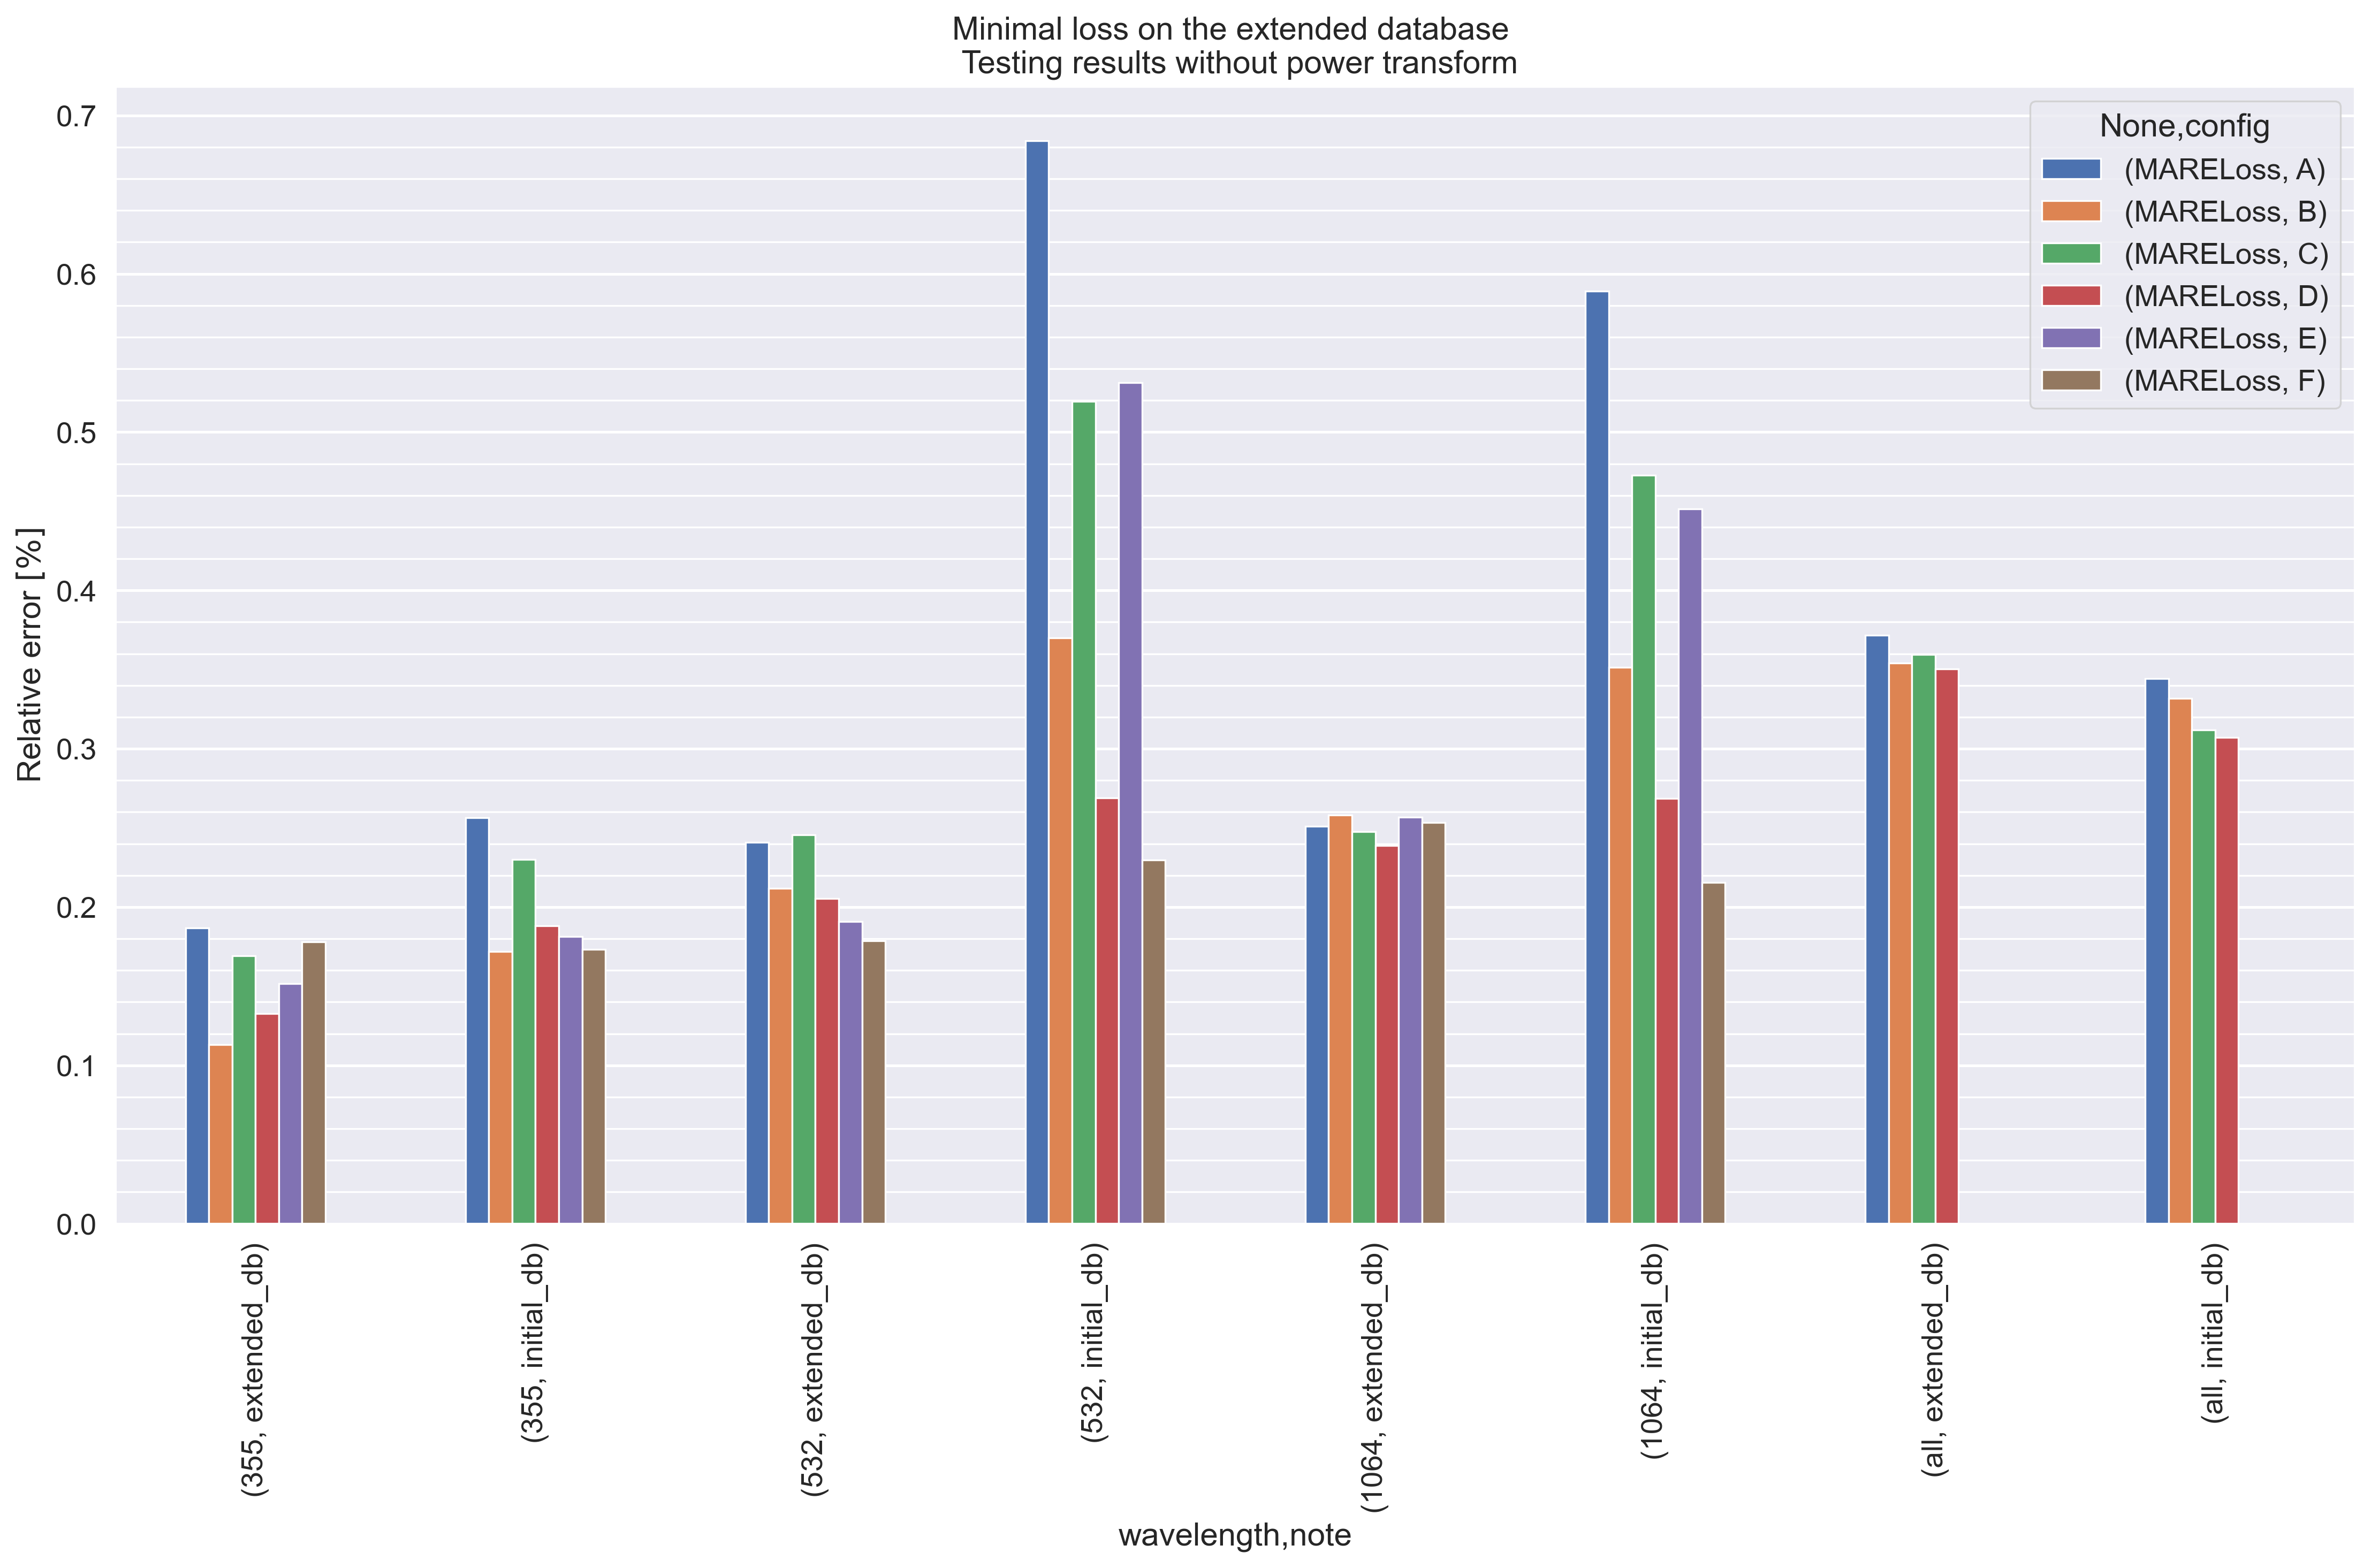

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power==False],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','note'],#'use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on the extended database \n Testing results without power transform')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()